## Initialization

In [160]:
import os, sys
import torch
import transformers
from torch.utils.data import DataLoader, SequentialSampler
import argparse
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_curve, auc
import seaborn as sns
from itertools import count
from scipy.signal import find_peaks
from findpeaks import findpeaks
import scipy.signal
from rouge_score import rouge_scorer

In [2]:
import sys
sys.path.append("/home/divy/FiD")

In [3]:
import src
from src.data import load_data
from src.evaluation import ems
import src.model

## Load data

Try out NQ with NQ pretrained checkpoint

In [4]:
nq_path =  "/mnt/disks/external_mounted_disk/datasets/NQ/NQ/dev.json"
compose_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/dev.json"
control_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/control.json"
control_copy_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/control_copy.json"


one_correct_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/one_correct.json"
none_correct_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/none_correct.json"


In [5]:
# uncorrupted examples
eval_examples = load_data(
                            compose_path,
                            global_rank=0,
                            world_size=1,
                            )


# examples with 4 nonsensical support, one correct
one_correct_examples = load_data(
                            one_correct_path,
                            global_rank=0,
                            world_size=1,
                            )

# all 5 support passages are nonsensical
none_correct_examples = load_data(
                            none_correct_path,
                            global_rank=0,
                            world_size=1,
                            )


In [6]:
# setting to 5 so as to keep it short for testing
n_passages = 25

In [7]:
eval_dataset_dev = src.data.Dataset(eval_examples, n_passages)
sampler_dev = SequentialSampler(eval_dataset_dev)
len(eval_dataset_dev)

386

In [8]:
one_correct_dataset = src.data.Dataset(one_correct_examples, n_passages)
sampler_one_correct = SequentialSampler(one_correct_dataset)
len(one_correct_dataset)

2

In [9]:
none_correct_dataset = src.data.Dataset(none_correct_examples, n_passages)
sampler_none_correct = SequentialSampler(none_correct_dataset)
len(none_correct_dataset)

2

In [10]:
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')
collator = src.data.Collator(200, tokenizer, answer_maxlength=-1)

In [11]:
dataloader_dev = DataLoader(eval_dataset_dev,
        sampler=sampler_dev,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

In [12]:
dataloader_oc = DataLoader(one_correct_dataset,
        sampler=sampler_one_correct,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

In [13]:
dataloader_nc = DataLoader(none_correct_dataset,
        sampler=sampler_none_correct,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

## Load model

In [14]:
model_name = 't5-base'
model_class = src.model.FiDT5

In [15]:
load_path = "/home/divy/FiD/model_ckpts/test_experiment_large_fid_qa_compose"
model = model_class.from_pretrained(load_path)

In [16]:
model = model.to('cuda')

### load an example input, generated output and ground truth output

In [150]:
cherry_picked_example = 75
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [151]:
for i, batch in enumerate(dataloader_dev):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i == cherry_picked_example:
        
        print(idx)
        print(context_ids.shape)
        
        for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            
            
        print("")
        print("")
        print("generated answer:")
        # generated_output = model.generate(
        #         input_ids=context_ids.cuda(),
        #         attention_mask=context_mask.cuda(),
        #         max_length=50
        #     ).cpu()
        
        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=False,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,
                
            )
        
        # generated_output = generated_output.cpu()
        
        # print(generated_output.sequences)
        # print(generated_output.scores)
        
        # print(generated_output)
        # print(len(generated_output[0]))
        
        human_readable_generated_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
        print(human_readable_generated_output)
        
        print("")
        print("")
        print("ground truth answer:")
        ground_truth_answer = tokenizer.decode(labels[0], skip_special_tokens=True)
        print(ground_truth_answer)
        print(len(labels[0]))
        
        print("")
        print("log_prob")
        print(log_prob)
        
        print("")
        print("rouge score")
        rouge_score = scorer.score(ground_truth_answer, human_readable_generated_output)['rougeL'].fmeasure
        print(rouge_score)
        break
    
        


tensor([75])
torch.Size([1, 12, 176])
====
0
question: What does the plaintiff have to establish when the defendant's allegedly extreme and outrageous conduct was directed towards someone other than the plaintiff? title: context: The plaintiff must show that the defendant's conduct was extreme and outrageous.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

## compute g_{q,p} / max-pool attention matrices

### Compute a potential score

In [126]:
def subfinder(mylist, pattern):
    matches = []
    for i in range(len(mylist)):
        if mylist[i] == pattern[0] and mylist[i:i+len(pattern)] == pattern:
            matches.append((i + len(pattern), pattern))
    return matches

In [127]:
with open("../numpy_drops/rouge_similarity_answers_dev", "rb") as f:
    rouge_matches = pickle.load(f)


In [128]:
high_rouge_similarities = [el for el in rouge_matches if el[2] >= 0.9]
high_rouge_similarity_indices = [el[3] for el in high_rouge_similarities]

In [129]:
low_rouge_similarities = [el for el in rouge_matches if el[2] <= 0.3]
low_rouge_similarity_indices = [el[3] for el in low_rouge_similarities]

len(low_rouge_similarity_indices)

28

In [130]:
low_rouge_similarities

[('Certain exceptions to application of the “ABC” test exist, wherein courts must apply the Borello standard, including if the worker is covered by an exception expressly made by the Labor Code or an Industrial Welfare Commission order, as well as occupations specifically listed in the statute such as certain insurance, health care, professional services, investment, fishing, and media positions.',
  'The “ABC” test, applied rigidly and in isolation, is often of little use in evaluating the infinite variety of service arrangements. If a court rules that the three-part test cannot be applied to a particular context based on grounds other than an express exception to employment status as provided under paragraph (2), then the determination of employee or independent contractor status in that context shall instead be governed by the California Supreme Court’s decision in S.G. Borello & Sons, Inc. v. Department of Industrial Relations (1989) 49 Cal.3dii',
  0.1733333333333333,
  9),
 ('Gen

In [39]:
high_rouge_similarities[:10]

[('An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  'An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  1.0,
  2),
 ('A defendant who obtains a dismissal can be considered the prevailing party.\xa0',
  'A defendant who obtains a dismissal can be considered the prevailing party.',
  1.0,
  19),
 ('If a contract provides for attorney fees, that provision is construed to apply to the entire contract, unless each party was represented by counsel in the negotiation and execution of the contract, and the fact of that representation is specified in the contract.',
  'If a contract provides for attorney fees, it is assumed that the provision applies to the entire contract, unless each party was represented by counsel in the negotiation and execution of the contract and the fact of that representation is specified in the contract.',
  0.91954022988505

In [181]:
min_savgols_low_similarity = []
max_savgols_low_similarity = []

min_savgols_high_similarity = []
max_savgols_high_similarity = []

passage_max_scores = []
passage_mean_scores = []

rouge_scores = []
log_probs = []

# set criterion on the number of passages that must be used
topk_passages = 5
topk_passage_means = []
topk_passage_stdevs = []


In [182]:
for i, batch in tqdm(enumerate(dataloader_dev)):
    (idx, labels, _, context_ids, context_mask) = batch
            
    # print(i)
    
    # if i in low_rouge_similarity_indices:
    
    print(i)
    with torch.no_grad():

        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=False,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,

            )

        model_forward = model.forward(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            # decoder_input_ids=labels.cuda(),
            decoder_input_ids=generated_output.cuda(),
            output_attentions=True,
            output_unnormalized_attentions=True,
        )

    cross_attentions = model_forward.cross_attentions
    stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
    msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

    masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

    avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()
    context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
    all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])

    start_pattern = ['▁title', ':', '▁context', ':']
    end_pattern = ['</s>']

    start_index_pattern = subfinder(all_input_tokens, start_pattern)
    end_index_pattern = subfinder(all_input_tokens, end_pattern)

    start_indices = [el[0] for el in start_index_pattern]
    end_indices = [el[0] for el in end_index_pattern]

    relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]
    print(relevant_ranges)
    
    mean_savgols = []
    for relevant_range in relevant_ranges:
        spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]

        maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
        minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()

        m = maxpool
        # m = maxpool - minpool
        try:
            savgol = scipy.signal.savgol_filter(m, 10, 3)

        except ValueError:
            try:
                savgol = scipy.signal.savgol_filter(m, 5, 3)

            except ValueError:
                try:
                    savgol = scipy.signal.savgol_filter(m, 3, 2)

                except ValueError:
                    try:
                        savgol = scipy.signal.savgol_filter(m, 2, 1)

                    except ValueError:
                        try:
                            savgol = scipy.signal.savgol_filter(m, 1, 0)

                        except ValueError:
                            savgol = [-float('inf')]

        mean_savgol = np.mean(savgol)

        mean_savgols.append(mean_savgol)

    passage_max_scores.append(max(mean_savgols))
    passage_mean_scores.append(np.mean(mean_savgols))
    print(mean_savgols)
    
    rouge_scores.append(rouge_matches[i][2])
    log_probs.append(log_prob)
    print(max(mean_savgols), min(mean_savgols))
    print(rouge_matches[i][2])
    
    mean_savgols_np = np.array(mean_savgols)
    topk_means_savgols = np.partition(mean_savgols_np, -topk_passages)[-topk_passages:]
    
    print(topk_means_savgols)
    
    mean_topk_mean_savgols = np.mean(topk_means_savgols)
    std_topk_mean_savgols = np.std(topk_means_savgols)
    
    print(std_topk_mean_savgols)
    
    topk_passage_means.append(mean_topk_mean_savgols)
    topk_passage_stdevs.append(std_topk_mean_savgols)
  


0it [00:00, ?it/s]

0


1it [00:02,  2.22s/it]

[(30, 88), (230, 271), (430, 476), (630, 690), (830, 884), (1030, 1070), (1230, 1285), (1430, 1482), (1630, 1684), (1830, 1888), (2030, 2199), (2230, 2312), (2430, 2599), (2630, 2712)]
[0.09722672, 0.035961956, 1.385124, 0.8521029, 1.0795133, 0.42338902, 0.95472276, 1.4571953, 1.2572294, 1.0908605, -1.2826912, -1.2958845, -1.2826912, -1.2958845]
1.4571953 -1.2958845
0.8266666666666667
[1.0795133 1.0908605 1.2572294 1.385124  1.4571953]
0.15202127
1


2it [00:04,  2.23s/it]

[(36, 59), (236, 261), (436, 461), (636, 657), (836, 863), (1036, 1059), (1236, 1259), (1436, 1472), (1636, 1675), (1836, 1867), (2036, 2098), (2236, 2307), (2436, 2599)]
[-1.5983444, -1.6664832, -1.6664832, -1.2532346, -1.5556364, -1.6425496, -1.6425496, -1.1384568, -1.8597382, -1.714814, -0.50836825, 0.6989463, -0.36014405]
0.6989463 -1.8597382
0.5074626865671642
[-1.2532346  -1.1384568  -0.50836825  0.6989463  -0.36014405]
0.69732934
2


3it [00:05,  1.69s/it]

[(30, 79), (135, 167), (240, 267), (345, 372), (450, 482), (555, 629), (660, 695), (765, 792), (870, 905), (975, 1037), (1080, 1146), (1185, 1241), (1290, 1351), (1395, 1461), (1500, 1561), (1605, 1671), (1710, 1776), (1815, 1871)]
[-1.506421, -1.857425, -1.5619498, -2.0615804, -1.9215717, -1.2851454, -1.159129, -1.4848357, -1.7595612, -1.4084375, -1.5848768, -1.005441, -1.006616, -1.5848768, -1.006616, -1.5848768, -1.5848768, -1.005441]
-1.005441 -2.0615804
1.0
[-1.159129 -1.006616 -1.006616 -1.005441 -1.005441]
0.061242476
3


4it [00:07,  1.67s/it]

[(19, 54), (219, 276), (419, 471), (619, 639), (819, 840), (1019, 1051), (1219, 1259), (1419, 1455), (1619, 1659), (1819, 1860), (2019, 2199), (2219, 2399)]
[-0.806493, -1.1690782, -1.314888, -1.2788199, -0.9131406, -1.7853014, -1.7238843, -2.0996246, -1.8583053, -1.1964879, -0.0778188, -0.0699618]
-0.0699618 -2.0996246
0.4444444444444445
[-1.1690782 -0.9131406 -0.806493  -0.0778188 -0.0699618]
0.45119703
4


5it [00:08,  1.73s/it]

[(27, 57), (156, 185), (285, 325), (414, 450), (543, 579), (672, 737), (801, 884), (930, 984), (1059, 1092), (1188, 1238), (1317, 1391), (1446, 1494), (1575, 1640), (1704, 1767), (1833, 1914), (1962, 2063), (2091, 2118), (2220, 2294), (2349, 2397), (2478, 2560)]
[-1.0082282, -0.42948732, -0.70434517, -0.9272571, -0.9272571, -0.30211803, -0.6080733, -1.2066728, -1.0369202, -0.5656351, -0.18483634, 0.49038443, -0.2916806, -0.23003814, 0.09089057, -0.37091047, -0.1149813, -0.16647543, 0.03145859, -0.030995002]
0.49038443 -1.2066728
0.3835616438356164
[-0.1149813  -0.030995    0.09089057  0.03145859  0.49038443]
0.20992215
5


6it [00:10,  1.71s/it]

[(30, 105), (230, 249), (430, 469), (630, 650), (830, 886), (1030, 1078), (1230, 1278), (1430, 1453), (1630, 1657), (1830, 1865), (2030, 2060), (2230, 2399), (2430, 2460), (2630, 2799), (2830, 2860), (3030, 3199)]
[0.36124215, -0.7817743, -1.0322014, -1.3061774, -1.5169894, -1.2642195, -1.1654935, -1.9331814, -1.4085691, -1.9271463, -0.27829963, -0.21966518, -0.27829963, -0.21966518, -0.27829963, -0.21966518]
0.36124215 -1.9331814
0.8307692307692308
[-0.27829963 -0.21966518 -0.21966518 -0.21966518  0.36124215]
0.23930632
6


7it [00:11,  1.55s/it]

[(31, 73), (134, 176), (237, 271), (340, 380), (443, 476), (546, 579), (649, 682), (752, 803), (855, 916), (958, 999), (1061, 1114), (1164, 1235), (1267, 1320), (1370, 1441), (1473, 1526), (1576, 1647), (1679, 1732), (1782, 1853)]
[-2.684211, -2.684211, -2.1545157, -1.7040567, -2.4370456, -1.8213952, -1.8213952, -2.3020127, -1.9610484, -1.9174998, -0.9552623, -0.7830328, -0.9552623, -0.7830328, -0.9552623, -0.7830328, -0.9552623, -0.7830328]
-0.7830328 -2.684211
0.3939393939393939
[-0.9552623 -0.7830328 -0.7830328 -0.7830328 -0.7830328]
0.068891816
7


8it [00:15,  2.33s/it]

[(36, 68), (236, 291), (436, 514), (636, 713), (836, 901), (1036, 1074), (1236, 1278), (1436, 1477), (1636, 1687), (1836, 1892), (2036, 2199)]
[-1.4861536, -1.4710865, 0.6293255, -1.4840935, -1.1064081, -1.1697454, -0.76163566, -0.9713969, -1.131874, -0.48752815, 2.1860394]
2.1860394 -1.4861536
0.6168224299065421
[-0.9713969   0.6293255  -0.76163566 -0.48752815  2.1860394 ]
1.1717888
8


9it [00:16,  1.85s/it]

[(13, 24), (67, 83), (121, 134), (175, 194), (229, 249), (283, 294), (337, 347), (391, 405), (445, 469), (499, 538), (553, 593), (607, 627), (661, 698), (715, 740), (769, 808), (823, 856), (877, 911)]
[-1.1203955, -1.5435851, -1.7391893, -1.6794965, -1.1804621, -1.7026271, -1.2347126, -1.6782905, -2.0700161, -1.7290964, -0.045576807, -0.38988727, -0.50504017, 0.7571844, -0.12850173, 0.0055303313, -0.1821801]
0.7571844 -2.0700161
0.625
[-0.1821801  -0.12850173 -0.04557681  0.00553033  0.7571844 ]
0.34412122
9


10it [00:20,  2.32s/it]

[(19, 35), (219, 236), (419, 439), (619, 631), (819, 834), (1019, 1039), (1219, 1230), (1419, 1438), (1619, 1630), (1819, 1829), (2019, 2122), (2219, 2399)]
[-0.787754, -0.6895984, -0.38717598, -1.7828914, -0.94236296, -0.14824429, -1.6807499, -0.90075433, -1.7916322, -2.1111581, 2.612205, 1.4437795]
2.612205 -2.1111581
0.1733333333333333
[-0.6895984  -0.38717598 -0.14824429  2.612205    1.4437795 ]
1.2611637
10


11it [00:21,  2.00s/it]

[(20, 39), (161, 178), (302, 322), (443, 461), (584, 603), (725, 744), (866, 902), (1007, 1021), (1148, 1163), (1289, 1307), (1430, 1480), (1571, 1651), (1712, 1753), (1853, 1973), (1994, 2052), (2135, 2195), (2276, 2346), (2417, 2461), (2558, 2608), (2699, 2779)]
[-2.1102297, -1.6780543, -1.3915062, -2.0773363, -2.0006242, -2.0006242, -1.5360446, -2.276259, -2.611725, -1.8228891, -0.15635802, -0.5861765, -0.9101183, -0.40053624, -0.34187382, -0.76559, -0.46207285, 0.23738004, -0.15635802, -0.5861765]
0.23738004 -2.611725
0.6666666666666666
[-0.40053624 -0.34187382 -0.15635802 -0.15635802  0.23738004]
0.22307408
11


12it [00:23,  1.96s/it]

[(24, 43), (178, 215), (332, 409), (486, 520), (640, 680), (794, 835), (948, 962), (1102, 1121), (1256, 1275), (1410, 1432), (1564, 1630), (1718, 1847), (1872, 1948), (2026, 2106), (2180, 2268), (2334, 2416), (2488, 2596), (2642, 2708), (2796, 2925), (2950, 3026)]
[-1.0941534, -2.409592, -1.7588199, -1.6658814, -1.4712692, -1.2644747, -2.0936017, -2.1272187, -2.5516224, -1.7558522, -0.873411, -0.556872, -0.4759291, 0.14677212, 0.396651, 0.24651039, -0.18965799, -0.873411, -0.556872, -0.4759291]
0.396651 -2.5516224
0.3529411764705882
[-0.4759291  -0.18965799  0.14677212  0.24651039  0.396651  ]
0.31592017
12


13it [00:24,  1.73s/it]

[(22, 70), (121, 141), (220, 261), (319, 368), (418, 465), (517, 551), (616, 647), (715, 772), (814, 836), (913, 945), (1012, 1073), (1111, 1157), (1210, 1227), (1309, 1364), (1408, 1434), (1507, 1553), (1606, 1682), (1705, 1759), (1804, 1870), (1903, 1964)]
[-1.5422901, -0.9967371, -1.4176717, -1.5839452, -1.3709828, -0.9349016, -0.8750173, -1.700381, -0.8588197, -0.954656, -1.4065521, -0.35152575, -0.77396196, -0.59198433, -0.38118094, -0.35152575, -0.7105923, -0.37761807, -0.6612835, -1.4065521]
-0.35152575 -1.700381
0.5660377358490567
[-0.59198433 -0.38118094 -0.37761807 -0.35152575 -0.35152575]
0.09146908
13


14it [00:25,  1.66s/it]

[(29, 55), (229, 261), (429, 456), (629, 656), (829, 856), (1029, 1056), (1229, 1256), (1429, 1453), (1629, 1653), (1829, 1859), (2029, 2146), (2229, 2301), (2429, 2503), (2629, 2719), (2829, 2999), (3029, 3146), (3229, 3301), (3429, 3503), (3629, 3718), (3829, 3999)]
[-1.5015391, -1.0723451, -1.5595793, -1.5595793, -1.5570853, -1.5595793, -1.5595793, -1.4693413, -1.483048, -1.455278, -0.9525502, -0.61620957, -0.5287986, -0.53007674, -1.113136, -0.9525502, -0.61620957, -0.5287986, -0.54702127, -1.113136]
-0.5287986 -1.5595793
0.5306122448979591
[-0.61620957 -0.5287986  -0.5287986  -0.54702127 -0.53007674]
0.03372937
14


15it [00:27,  1.52s/it]

[(16, 26), (216, 228), (416, 428), (616, 641), (816, 837), (1016, 1029), (1216, 1232), (1416, 1426), (1616, 1636), (1816, 1829), (2016, 2059), (2216, 2249), (2416, 2437), (2616, 2650), (2816, 2923), (3016, 3199), (3216, 3257), (3416, 3460), (3616, 3662), (3816, 3864)]
[-0.7481293, -1.5918859, -1.4001927, -1.6240693, -1.8213303, -1.154188, -1.0931301, -1.4336182, -2.0391252, -1.3530152, -1.0314679, -0.6308762, -1.7740846, -1.0649647, -1.2662431, -1.0906585, -1.139716, -2.0316305, -1.4947975, -1.4469033]
-0.6308762 -2.0391252
0.7000000000000001
[-1.0906585 -1.0649647 -1.0314679 -0.7481293 -0.6308762]
0.18733202
15


16it [00:28,  1.54s/it]

[(45, 148), (245, 332), (445, 528), (645, 718), (845, 872), (1045, 1072), (1245, 1272), (1445, 1472), (1645, 1686), (1845, 1886), (2045, 2199), (2245, 2397), (2445, 2560), (2645, 2799), (2845, 2997), (3045, 3160)]
[-1.6545672, -2.0929148, -1.1032197, -1.9712241, -2.326547, -2.326547, -2.326547, -2.326547, -1.7456714, -1.7456714, -1.3174229, -0.81571436, -1.7218451, -1.3174229, -0.81571436, -1.7218451]
-0.81571436 -2.326547
0.5
[-1.3174229  -1.3174229  -0.81571436 -0.81571436 -1.1032197 ]
0.22484931
16


17it [00:31,  1.80s/it]

[(35, 77), (235, 320), (435, 525), (635, 693), (835, 973), (1035, 1108), (1235, 1271), (1435, 1474), (1635, 1686), (1835, 1901), (2035, 2199), (2235, 2399)]
[-1.1933542, -1.2314074, -0.9106277, -1.0335444, -1.2359155, -1.240407, -1.2782235, -0.86224765, -1.8868803, -1.2034682, 0.4589201, 1.0827712]
1.0827712 -1.8868803
0.5849056603773584
[-1.0335444  -0.9106277  -0.86224765  0.4589201   1.0827712 ]
0.8606999
17


18it [00:31,  1.45s/it]

[(21, 51), (114, 139), (207, 237), (300, 335), (393, 464), (486, 507), (579, 597), (672, 689), (765, 782), (858, 888), (951, 999)]
[-0.96997446, -0.52166647, -1.6007073, -0.45118222, -1.7161887, -0.42932224, -1.2578591, -1.244569, -1.244569, -1.804696, -0.059348375]
-0.059348375 -1.804696
0.3333333333333333
[-0.96997446 -0.52166647 -0.45118222 -0.42932224 -0.05934837]
0.29050273
18


19it [00:33,  1.53s/it]

[(42, 92), (217, 257), (392, 444), (567, 613), (742, 788), (917, 964), (1092, 1137), (1267, 1312), (1442, 1510), (1617, 1685), (1792, 1924)]
[0.9142909, 1.3272731, -0.9529345, 0.34861934, 0.1997174, 0.5637995, 0.974988, 0.974988, 1.0030051, 1.0030051, 0.73553085]
1.3272731 -0.9529345
0.8666666666666666
[0.974988  0.974988  1.0030051 1.0030051 1.3272731]
0.1358895
19


20it [00:34,  1.37s/it]

[(24, 49), (224, 245), (424, 447), (624, 648), (824, 851), (1024, 1048), (1224, 1245), (1424, 1447), (1624, 1648), (1824, 1844), (2024, 2123), (2224, 2399)]
[-2.003312, -2.6848435, -3.009356, -1.6966597, -2.3042562, -2.826824, -2.5900633, -2.7711024, -1.978113, -1.953716, -0.89185053, -1.1455479]
-0.89185053 -3.009356
1.0
[-1.978113   -1.953716   -1.6966597  -0.89185053 -1.1455479 ]
0.4388858
20


21it [00:35,  1.38s/it]

[(47, 108), (158, 219), (269, 330), (380, 441), (491, 552), (602, 662), (713, 773), (824, 887), (935, 998), (1046, 1109), (1157, 1217)]
[0.36698377, 0.5016031, 0.5016031, 0.27554995, 0.27554995, 1.0437526, 1.0437526, 0.6032279, 0.6032279, 0.48658806, 1.0437526]
1.0437526 0.27554995
0.9195402298850575
[0.6032279 0.6032279 1.0437526 1.0437526 1.0437526]
0.21581212
21


22it [00:37,  1.33s/it]

[(15, 141), (167, 201), (319, 385), (471, 491), (623, 642), (775, 809), (927, 960), (1079, 1121), (1231, 1272), (1383, 1433), (1535, 1671)]
[-1.1289598, -0.96928775, -0.9563459, -1.9669441, -1.802359, -1.4704086, -1.0058451, -0.54091275, -1.6089902, -1.1845783, 0.25621247]
0.25621247 -1.9669441
0.8979591836734694
[-1.0058451  -0.96928775 -0.54091275 -0.9563459   0.25621247]
0.4806892
22


23it [00:38,  1.30s/it]

[(18, 36), (121, 137), (224, 247), (327, 357), (430, 514), (533, 560), (636, 645), (739, 756), (842, 883), (945, 968), (1048, 1107), (1151, 1170)]
[-2.1122158, -1.4374118, -1.3081816, -2.5539672, -1.490117, -1.7146026, -1.0582845, -1.9474859, -1.5426621, -2.4046614, 1.6405059, -2.7922823]
1.6405059 -2.7922823
0.9411764705882354
[-1.490117  -1.4374118 -1.3081816  1.6405059 -1.0582845]
1.1949536
23


24it [00:40,  1.58s/it]

[(24, 64), (213, 247), (402, 449), (591, 612), (780, 822), (969, 996), (1158, 1185), (1347, 1374), (1536, 1580), (1725, 1775), (1914, 2032), (2103, 2267), (2292, 2326), (2481, 2528), (2670, 2704), (2859, 2977), (3048, 3212)]
[-1.4885505, -1.3007088, -1.3529326, -1.2966324, -1.7415835, -1.0303941, -1.0303941, -1.0303941, -1.5801605, -0.84012914, -0.1747986, 0.2521608, 0.50477105, -0.30604598, 0.50477105, -0.1747986, 0.2521608]
0.50477105 -1.7415835
0.4842105263157895
[-0.1747986   0.2521608   0.50477105  0.50477105  0.2521608 ]
0.24847263
24


25it [00:44,  2.30s/it]

[(46, 111), (246, 289), (446, 495), (646, 705), (846, 886), (1046, 1086), (1246, 1298), (1446, 1495), (1646, 1687), (1846, 1883), (2046, 2199)]
[-0.47294724, -0.16175178, -0.15020217, -1.2200426, -0.35439676, -0.3149178, -0.7847335, -0.2708022, -0.050563127, -0.11562717, 2.8410509]
2.8410509 -1.2200426
0.3333333333333333
[-0.16175178 -0.15020217 -0.05056313 -0.11562717  2.8410509 ]
1.1848675
25


26it [00:45,  2.00s/it]

[(30, 49), (230, 284), (430, 451), (630, 661), (830, 862), (1030, 1066), (1230, 1279), (1430, 1470), (1630, 1666), (1830, 1897), (2030, 2063), (2230, 2324), (2430, 2563), (2630, 2799), (2830, 2925), (3030, 3188)]
[-1.3356616, -1.4243315, -1.7463226, -2.0871115, -1.8002619, -2.0833328, -2.163486, -2.3547409, -1.5820543, -1.1609724, -1.6561426, -1.1580491, -1.3496715, -0.853802, -1.0462626, -1.2879423]
-0.853802 -2.3547409
0.8421052631578948
[-1.2879423 -1.1609724 -1.1580491 -1.0462626 -0.853802 ]
0.14553411
26


27it [00:46,  1.61s/it]

[(29, 67), (97, 132), (165, 194), (233, 250), (301, 336), (369, 399), (437, 459), (505, 520), (573, 597), (641, 665), (709, 747)]
[0.2275562, -1.7836624, -1.3184716, -1.9949951, -1.7117695, -1.4808627, -0.86200386, -1.2733127, -2.2421591, -2.2421591, 0.2275562]
0.2275562 -2.2421591
0.7692307692307693
[-1.3184716  -1.2733127  -0.86200386  0.2275562   0.2275562 ]
0.693959
27


28it [00:47,  1.56s/it]

[(28, 53), (194, 222), (360, 388), (526, 554), (692, 727), (858, 902), (1024, 1068), (1190, 1217), (1356, 1391), (1522, 1542), (1688, 1746), (1854, 1991), (2020, 2083), (2186, 2249), (2352, 2410), (2518, 2655)]
[-1.5657235, -1.2205602, -1.2205602, -1.2205602, -1.2106162, -1.4573175, -1.4573175, -1.1329314, -1.5681037, -1.3962766, 0.0010825411, -0.73070914, -0.4323266, -0.4323266, 0.0010825411, -0.73070914]
0.0010825411 -1.5681037
0.6842105263157895
[-0.73070914 -0.4323266  -0.4323266   0.00108254  0.00108254]
0.28287637
28


29it [00:49,  1.48s/it]

[(38, 104), (217, 286), (396, 433), (575, 715), (754, 793), (933, 979), (1112, 1133), (1291, 1325), (1470, 1510), (1649, 1696), (1828, 1895)]
[-0.098818466, -2.0508137, -2.1959224, -1.7269003, -2.7391188, -2.4195251, -3.2456222, -2.5115297, -2.4811788, -3.2024274, 0.38468134]
0.38468134 -3.2456222
0.5625000000000001
[-2.1959224  -2.0508137  -1.7269003  -0.09881847  0.38468134]
1.0674913
29


30it [00:50,  1.37s/it]

[(18, 53), (218, 230), (418, 447), (618, 626), (818, 840), (1018, 1034), (1218, 1243), (1418, 1433), (1618, 1626), (1818, 1832), (2018, 2199)]
[-1.6050472, -2.6662922, -1.1263427, -2.7367237, -2.2676332, -2.86973, -2.0213997, -2.6102347, -2.127686, -2.82337, -0.780261]
-0.780261 -2.86973
0.4
[-2.127686  -2.0213997 -1.6050472 -1.1263427 -0.780261 ]
0.5156276
30


31it [00:52,  1.59s/it]

[(28, 101), (196, 271), (364, 396), (532, 564), (700, 732), (868, 889), (1036, 1075), (1204, 1254), (1372, 1409), (1540, 1576), (1708, 1761), (1876, 2015), (2044, 2097), (2212, 2351), (2380, 2433), (2548, 2687)]
[0.6138765, 0.62945235, -0.9482684, -0.9482684, -0.69753647, -1.0457181, -0.6599661, 0.71732354, -0.95264876, -0.8826945, -0.5822145, 0.64850825, -0.5822145, 0.64850825, -0.5822145, 0.64850825]
0.71732354 -1.0457181
0.5333333333333333
[0.62945235 0.64850825 0.64850825 0.64850825 0.71732354]
0.030342948
31


32it [00:53,  1.53s/it]

[(17, 30), (122, 144), (227, 234), (332, 344), (437, 449), (542, 556), (647, 662), (752, 787), (857, 880), (962, 985), (1067, 1154), (1172, 1259), (1277, 1364)]
[-1.6914808, -1.0998302, -1.4184217, -1.9601439, -0.8884573, -1.3250376, -2.2069585, -1.1865214, -1.4063356, -1.4550123, -0.07069035, -0.07069035, -0.07069035]
-0.07069035 -2.2069585
0.5762711864406781
[-1.0998302  -0.8884573  -0.07069035 -0.07069035 -0.07069035]
0.45730922
32


33it [00:55,  1.53s/it]

[(43, 94), (243, 280), (443, 523), (643, 685), (843, 875), (1043, 1080), (1243, 1299), (1443, 1487), (1643, 1685), (1843, 1874), (2043, 2199), (2243, 2328), (2443, 2599)]
[-1.3166285, -1.6895878, -1.5453558, -1.6555994, -1.3944911, -0.92562693, -1.1285902, -1.8768445, -1.7277118, -1.7410291, -0.32617104, -0.6639309, -0.32617104]
-0.32617104 -1.8768445
0.9508196721311476
[-1.1285902  -0.92562693 -0.32617104 -0.6639309  -0.32617104]
0.32001242
33


34it [00:56,  1.45s/it]

[(23, 57), (128, 161), (233, 259), (338, 359), (443, 478), (548, 591), (653, 696), (758, 789), (863, 894), (968, 1049), (1073, 1119), (1178, 1236)]
[-0.062466726, -0.13918698, -1.4050395, -1.2066969, 0.2772924, -2.082614, -2.0961065, -0.6149275, -0.6149275, -0.11093663, 2.044686, 0.17453374]
2.044686 -2.0961065
0.711111111111111
[-0.11093663 -0.06246673  0.2772924   2.044686    0.17453374]
0.803111
34


35it [00:57,  1.33s/it]

[(16, 29), (114, 138), (212, 293), (310, 350), (408, 437), (506, 535), (604, 624), (702, 725), (800, 816), (898, 914), (996, 1037)]
[-1.6590495, -1.7002152, -0.8057636, -1.5000445, -1.8220268, -1.8220268, -1.5779185, -1.4563972, -2.177233, -1.8255084, 0.5830396]
0.5830396 -2.177233
0.19047619047619047
[-1.5779185 -1.5000445 -1.4563972 -0.8057636  0.5830396]
0.8153862
35


36it [00:58,  1.32s/it]

[(27, 43), (129, 149), (231, 251), (333, 355), (435, 460), (537, 556), (639, 661), (741, 763), (843, 865), (945, 970), (1047, 1121), (1149, 1187), (1251, 1273), (1353, 1381), (1455, 1471), (1557, 1622), (1659, 1682), (1761, 1782), (1863, 1897), (1965, 1983)]
[-1.0063227, -0.9527105, -0.9527105, -0.611336, -1.2701951, -0.78136176, -0.7795773, -0.7795773, -0.7795773, -1.0969485, -0.82448614, -0.23833363, -0.7795773, -1.2353812, -1.0063227, -0.69250876, -0.48993036, -1.6636093, -1.0162861, -1.7883909]
-0.23833363 -1.7883909
1.0
[-0.7795773  -0.48993036 -0.611336   -0.23833363 -0.69250876]
0.1880212
36


37it [01:00,  1.31s/it]

[(18, 49), (91, 118), (164, 204), (237, 277), (310, 341), (383, 414), (456, 494), (529, 567), (602, 640), (675, 693), (748, 802), (821, 875)]
[-0.8697037, -0.38605893, -1.3199716, -1.3199716, -1.2688749, -1.2688749, -2.1833363, -0.7281932, -0.7281932, -0.47986227, -1.056582, -1.056582]
-0.38605893 -2.1833363
0.326530612244898
[-0.8697037  -0.7281932  -0.7281932  -0.38605893 -0.47986227]
0.1780097
37


38it [01:01,  1.25s/it]

[(26, 115), (176, 208), (326, 364), (476, 516), (626, 672), (776, 815), (926, 946), (1076, 1118), (1226, 1258), (1376, 1408), (1526, 1649)]
[-0.89213055, -0.7957188, -0.4475364, -0.7480548, -0.66036105, -0.8057387, -0.9385557, -0.6303794, -0.693361, -0.70633453, -1.0721358]
-0.4475364 -1.0721358
0.65
[-0.70633453 -0.693361   -0.66036105 -0.6303794  -0.4475364 ]
0.09383766
38


39it [01:02,  1.30s/it]

[(17, 55), (217, 234), (417, 447), (617, 643), (817, 833), (1017, 1043), (1217, 1234), (1417, 1444), (1617, 1634), (1817, 1853), (2017, 2199)]
[-1.7330822, -1.8640124, -0.86086214, -1.7211169, -1.4649062, -2.0186408, -1.7869496, -0.46367377, -1.4419835, -1.0334442, -0.19106418]
-0.19106418 -2.0186408
0.2777777777777778
[-1.4419835  -1.0334442  -0.86086214 -0.46367377 -0.19106418]
0.4368627
39


40it [01:04,  1.44s/it]

[(27, 65), (227, 253), (427, 454), (627, 650), (827, 888), (1027, 1051), (1227, 1251), (1427, 1455), (1627, 1649), (1827, 1847), (2027, 2199)]
[-2.2773616, -1.9305269, -1.3877592, -1.0934128, -2.0997255, -1.7946059, -1.7946059, -2.256703, -1.5784073, -1.818285, -0.04179255]
-0.04179255 -2.2773616
0.5074626865671642
[-1.7946059  -1.5784073  -1.3877592  -1.0934128  -0.04179255]
0.61361927
40


41it [01:06,  1.56s/it]

[(34, 116), (234, 292), (434, 463), (634, 647), (834, 866), (1034, 1053), (1234, 1262), (1434, 1476), (1634, 1655), (1834, 1867), (2034, 2199), (2234, 2399)]
[-0.9421117, -1.6021446, -2.0329442, -2.3294148, -2.0836508, -2.395376, -0.78089964, -1.3282683, -1.9162169, -1.4043114, -0.06338698, -0.06338698]
-0.06338698 -2.395376
0.3962264150943396
[-1.3282683  -0.9421117  -0.78089964 -0.06338698 -0.06338698]
0.49994126
41


42it [01:07,  1.40s/it]

[(18, 46), (112, 187), (206, 230), (300, 346), (394, 416), (488, 513), (582, 611), (676, 704), (770, 795), (864, 879), (958, 1000), (1052, 1074), (1146, 1161), (1240, 1270), (1334, 1359), (1428, 1443), (1522, 1578), (1616, 1647), (1710, 1733), (1804, 1838)]
[-1.4894485, -1.3088675, -0.995261, -1.1781017, -1.3249103, -1.6935606, -1.3239399, -0.8039625, -1.7431958, -1.7752618, -0.93049365, -1.1892318, -1.2048519, -0.8031013, -2.565307, 0.4286669, -0.15821263, -1.1790253, -1.3884838, -0.30650604]
0.4286669 -2.565307
0.5909090909090909
[-0.8039625  -0.8031013  -0.30650604 -0.15821263  0.4286669 ]
0.45915014
42


43it [01:08,  1.27s/it]

[(21, 47), (177, 204), (333, 356), (489, 512), (645, 668), (801, 824), (957, 980), (1113, 1136), (1269, 1293), (1425, 1447), (1581, 1715)]
[-0.8171259, -1.8839186, -2.0996475, -2.0996475, -2.0996475, -2.0996475, -2.0662074, -2.0161722, -1.8307859, -1.3617179, -0.42949963]
-0.42949963 -2.0996475
0.3137254901960784
[-1.8839186  -1.8307859  -1.3617179  -0.8171259  -0.42949963]
0.56765825
43


44it [01:10,  1.38s/it]

[(20, 38), (220, 251), (420, 452), (620, 653), (820, 839), (1020, 1045), (1220, 1246), (1420, 1437), (1620, 1640), (1820, 1862), (2020, 2125), (2220, 2399), (2420, 2567), (2620, 2725)]
[-1.3776608, -1.8412923, -1.7944286, -1.2897513, -0.4488256, -1.3622736, -1.3757195, -1.1626719, -0.71533453, -2.0378559, 0.23315826, -1.1342384, 0.13580748, 0.23315826]
0.23315826 -2.0378559
0.5714285714285715
[-0.71533453 -0.4488256   0.13580748  0.23315826  0.23315826]
0.39424366
44


45it [01:11,  1.49s/it]

[(20, 69), (109, 124), (198, 213), (287, 307), (376, 390), (465, 493), (554, 577), (643, 657), (732, 772), (821, 849), (910, 978), (999, 1067)]
[-1.9914758, -1.9184588, -1.9184588, -2.8450122, -1.9822646, -2.6983297, -1.607277, -2.679311, -2.192753, -2.5880134, 2.2817836, 2.2817836]
2.2817836 -2.8450122
0.9514563106796116
[-1.9184588 -1.9184588 -1.607277   2.2817836  2.2817836]
2.0100884
45


46it [01:12,  1.38s/it]

[(25, 61), (118, 147), (211, 240), (304, 328), (397, 429), (490, 512), (583, 617), (676, 710), (769, 803), (862, 896), (955, 1013), (1048, 1115)]
[-2.2755733, -2.5364938, -2.5364938, -2.6691484, -1.8404506, -2.4378927, -2.4307258, -2.4307258, -2.4307258, -2.3873057, -0.025134185, 0.11335138]
0.11335138 -2.6691484
0.48717948717948717
[-2.3873057  -2.2755733  -1.8404506  -0.02513419  0.11335138]
1.0997697
46


47it [01:15,  1.60s/it]

[(30, 83), (230, 283), (430, 599), (630, 683), (830, 859), (1030, 1069), (1230, 1283), (1430, 1457), (1630, 1669), (1830, 1860), (2030, 2199), (2230, 2301), (2430, 2599), (2630, 2701), (2830, 2901), (3030, 3092), (3230, 3399), (3430, 3501), (3630, 3692), (3830, 3999)]
[-1.6220312, -1.6220312, -1.6544706, -1.4545857, -2.0101583, -1.1043154, -1.8320708, -0.8023191, -1.4455541, -1.5126382, -0.1738415, 0.09424857, -0.1738415, 0.09424857, 0.09424857, -0.8308464, -0.1738415, 0.09424857, -0.8308464, -0.1738415]
0.09424857 -2.0101583
0.2222222222222222
[-0.1738415   0.09424857  0.09424857  0.09424857  0.09424857]
0.107236035
47


48it [01:16,  1.62s/it]

[(53, 106), (175, 228), (297, 323), (419, 467), (541, 593), (663, 692), (785, 828), (907, 951), (1029, 1082), (1151, 1197), (1273, 1341)]
[-2.6594996, -2.6594996, -2.625037, -2.5070086, -1.8279463, -2.3764386, -2.6335297, -1.9533435, -2.6349018, 0.43577844, 1.5650116]
1.5650116 -2.6594996
0.6736842105263159
[-2.3764386  -1.9533435  -1.8279463   0.43577844  1.5650116 ]
1.5483886
48


49it [01:17,  1.47s/it]

[(37, 67), (105, 127), (173, 195), (241, 259), (309, 336), (377, 404), (445, 472), (513, 540), (581, 608), (649, 676), (717, 744), (785, 812), (853, 880)]
[-0.9654146, -1.1333448, -1.1333448, -1.0347652, 0.17096145, 0.17096145, 0.17096145, 0.17096145, 0.17096145, 0.17096145, 0.17096145, 0.17096145, 0.17096145]
0.17096145 -1.1333448
0.9836065573770492
[0.17096145 0.17096145 0.17096145 0.17096145 0.17096145]
0.0
49


50it [01:19,  1.54s/it]

[(43, 133), (196, 271), (349, 411), (502, 563), (655, 716), (808, 917), (961, 1023), (1114, 1223), (1267, 1325), (1420, 1481), (1573, 1631), (1726, 1784)]
[0.35675463, -0.10217938, -0.96597916, 0.56090033, 0.56090033, 0.0415494, 0.4512281, 0.06711914, 1.2440524, 1.3426962, 1.2440524, 1.2440524]
1.3426962 -0.96597916
0.4536082474226804
[0.56090033 1.2440524  1.2440524  1.3426962  1.2440524 ]
0.28569123
50


51it [01:21,  1.75s/it]

[(28, 71), (228, 258), (428, 464), (628, 671), (828, 902), (1028, 1057), (1228, 1261), (1428, 1481), (1628, 1675), (1828, 1877), (2028, 2199), (2228, 2399)]
[1.8553933, -0.739276, 0.31872573, -0.024118219, -1.3115916, -1.3274585, -0.8652369, -0.35202736, -1.2520124, -0.39928922, -0.313351, 0.5302539]
1.8553933 -1.3274585
0.5348837209302325
[-0.313351    0.31872573 -0.02411822  0.5302539   1.8553933 ]
0.7488075
51


52it [01:22,  1.44s/it]

[(14, 21), (77, 84), (140, 147), (203, 210), (266, 273), (329, 336), (392, 399), (455, 462), (518, 525), (581, 587), (644, 663), (707, 755), (770, 791), (833, 852), (896, 924), (959, 976), (1022, 1049), (1085, 1113)]
[-1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.1694418, -1.0135719, 0.6261088, -0.76457644, 0.23506664, 0.6261088, 1.0281638, 0.96197206, 0.4072219, 0.673032]
1.0281638 -1.1694418
0.6470588235294117
[0.6261088  0.6261088  0.673032   0.96197206 1.0281638 ]
0.17519069
52


53it [01:23,  1.28s/it]

[(34, 58), (183, 208), (332, 357), (481, 505), (630, 663), (779, 841), (928, 968), (1077, 1127), (1226, 1276), (1375, 1392), (1524, 1638), (1673, 1787)]
[-1.4199762, -1.4470776, -1.4470776, -1.3828325, -1.935044, -1.7421999, -1.8437321, -1.3260193, -1.3260193, -1.0860497, -1.1176064, -1.1176064]
-1.0860497 -1.935044
0.923076923076923
[-1.3260193 -1.3260193 -1.0860497 -1.1176064 -1.1176064]
0.10787144
53


54it [01:24,  1.29s/it]

[(13, 27), (136, 154), (259, 311), (382, 398), (505, 521), (628, 664), (751, 771), (874, 900), (997, 1008), (1120, 1133), (1243, 1352), (1366, 1411), (1489, 1550), (1612, 1683), (1735, 1844), (1858, 1912), (1981, 2034), (2104, 2213), (2227, 2281), (2350, 2403)]
[-3.0288932, -2.253479, -1.7224647, -1.9465306, -2.7809505, -2.1149676, -1.6526047, -1.8080025, -2.7479525, -2.29283, -0.6272366, 0.4125878, -0.2871588, -0.09795912, -0.6272366, 0.5059123, -0.3497293, -0.6272366, 0.5059123, -0.3497293]
0.5059123 -3.0288932
0.7567567567567567
[-0.2871588  -0.09795912  0.4125878   0.5059123   0.5059123 ]
0.3341116
54


55it [01:25,  1.25s/it]

[(21, 42), (187, 208), (353, 370), (519, 540), (685, 719), (851, 869), (1017, 1047), (1183, 1213), (1349, 1373), (1515, 1544), (1681, 1825)]
[-0.94450444, -0.5971172, -1.0132917, -0.38218558, -0.97764957, -0.60661584, -0.17777728, -0.17777728, 0.19374776, -0.5796886, -0.6028112]
0.19374776 -1.0132917
0.47368421052631576
[-0.5796886  -0.38218558  0.19374776 -0.17777728 -0.17777728]
0.2570294
55


56it [01:26,  1.14s/it]

[(15, 28), (136, 241), (257, 283), (378, 432), (499, 554), (620, 665), (741, 771), (862, 871), (983, 1044), (1104, 1152), (1225, 1312)]
[-2.93336, -2.025235, -2.1222823, -1.9361746, -2.2589672, -1.9679805, -2.247423, -2.295261, -1.5561203, -2.8631744, 0.03589022]
0.03589022 -2.93336
0.3888888888888889
[-2.025235   -1.9679805  -1.5561203  -1.9361746   0.03589022]
0.78060573
56


57it [01:28,  1.40s/it]

[(27, 60), (149, 182), (271, 298), (393, 413), (515, 526), (637, 657), (759, 779), (881, 919), (1003, 1023), (1125, 1142), (1247, 1341), (1369, 1434)]
[-2.078069, -2.078069, -2.0783992, -2.021054, -2.1221883, -2.0796087, -2.0796087, -1.5453398, -2.0762522, -2.012844, 1.992932, 0.69088686]
1.992932 -2.1221883
0.5376344086021505
[-2.021054   -1.5453398  -2.012844    1.992932    0.69088686]
1.6307476
57


58it [01:30,  1.50s/it]

[(15, 26), (175, 202), (335, 374), (495, 506), (655, 691), (815, 827), (975, 987), (1135, 1147), (1295, 1307), (1455, 1467), (1615, 1759), (1775, 1919)]
[-2.0147123, -1.447496, -2.52411, -2.7543867, -0.77985215, -2.032615, -2.032615, -2.032615, -2.032615, -2.032615, 0.3191117, 0.3191117]
0.3191117 -2.7543867
0.4776119402985075
[-2.0147123  -1.447496   -0.77985215  0.3191117   0.3191117 ]
0.9347316
58


59it [01:32,  1.56s/it]

[(21, 75), (221, 250), (421, 450), (621, 652), (821, 888), (1021, 1050), (1221, 1262), (1421, 1441), (1621, 1645), (1821, 1842), (2021, 2046), (2221, 2314), (2421, 2599), (2621, 2667), (2821, 2846), (3021, 3114), (3221, 3399), (3421, 3467), (3621, 3646), (3821, 3914)]
[-2.0304787, -2.3347058, -2.3347058, -2.6043649, -0.59530485, -2.3777568, -1.36509, -2.3036106, -2.6921937, -1.5788162, -0.6591794, -0.7389374, -0.8058736, 0.947094, -0.6591794, -0.7389374, -0.8058736, 0.947094, -0.6591794, -0.7389374]
0.947094 -2.6921937
0.7692307692307693
[-0.6591794  -0.6591794  -0.59530485  0.947094    0.947094  ]
0.7768296
59


60it [01:33,  1.48s/it]

[(24, 52), (222, 243), (420, 456), (618, 658), (816, 880), (1014, 1095), (1212, 1254), (1410, 1435), (1608, 1631), (1806, 1828), (2004, 2177), (2202, 2375)]
[-1.7125995, -1.4980816, -1.8214154, -2.2701497, -2.3248134, -2.0837014, -2.4830716, -2.4604445, -1.6134369, -2.4644907, -0.7756083, -0.7756083]
-0.7756083 -2.4830716
0.6349206349206349
[-1.7125995 -1.6134369 -1.4980816 -0.7756083 -0.7756083]
0.41342044
60


61it [01:34,  1.36s/it]

[(18, 41), (116, 133), (214, 245), (312, 332), (410, 454), (508, 550), (606, 636), (704, 737), (802, 835), (900, 945), (998, 1077), (1096, 1134)]
[-1.5567106, -1.7049031, -2.1857092, -1.0687345, -1.0204989, -1.7837546, -0.70256823, -2.1215944, -2.1215944, -0.8589935, 0.25781384, 1.7152947]
1.7152947 -2.1857092
0.7058823529411765
[-1.0204989  -0.8589935  -0.70256823  0.25781384  1.7152947 ]
1.0205321
61


62it [01:36,  1.61s/it]

[(27, 72), (207, 241), (387, 407), (567, 587), (747, 770), (927, 953), (1107, 1133), (1287, 1310), (1467, 1496), (1647, 1671), (1827, 1979), (2007, 2159)]
[-0.9809884, -0.18959415, -1.1928751, -1.1928751, -0.20790467, 0.11644523, 0.11644523, 0.6087784, -0.9399777, -0.9800394, 0.8456669, 0.8456669]
0.8456669 -1.1928751
0.4390243902439024
[0.11644523 0.6087784  0.11644523 0.8456669  0.8456669 ]
0.33009532
62


63it [01:37,  1.41s/it]

[(28, 67), (108, 147), (188, 217), (268, 298), (348, 394), (428, 462), (508, 559), (588, 639), (668, 700), (748, 776), (828, 861)]
[-1.5396569, -1.5396569, -1.2106351, -1.416427, -2.1443622, -1.7555518, -1.5256524, -1.5256524, -1.5396276, -1.7333386, -0.6201126]
-0.6201126 -2.1443622
0.5333333333333333
[-1.5256524 -1.5256524 -1.416427  -1.2106351 -0.6201126]
0.33985412
63


64it [01:40,  1.69s/it]

[(19, 47), (216, 246), (413, 436), (610, 625), (807, 844), (1004, 1040), (1201, 1235), (1398, 1432), (1595, 1626), (1792, 1833), (1989, 2149), (2186, 2267), (2383, 2556), (2580, 2735), (2777, 2819), (2974, 3019), (3171, 3348), (3368, 3400), (3565, 3687), (3762, 3813)]
[-2.0508664, -2.49139, -1.8497239, -0.84911335, -2.0431702, -1.5108285, -0.32756552, -0.32756552, -1.679931, -1.9473174, -0.23004219, -0.5687364, -0.5613534, 0.8149215, 0.0021596735, -1.0319612, -0.68710035, 0.18951856, -0.48860896, -1.553336]
0.8149215 -2.49139
0.8282828282828283
[-0.32756552 -0.23004219  0.18951856  0.8149215   0.00215967]
0.4049491
64


65it [01:42,  1.92s/it]

[(33, 93), (233, 312), (433, 506), (633, 710), (833, 894), (1033, 1104), (1233, 1298), (1433, 1498), (1633, 1698), (1833, 1906), (2033, 2163), (2233, 2309), (2433, 2506), (2633, 2799), (2833, 2903), (3033, 3108), (3233, 3305), (3433, 3521), (3633, 3720), (3833, 3885)]
[0.30633196, 0.82261235, 0.8016191, 0.6566742, 0.53242207, 0.9144274, 1.9866948, 1.9866948, 1.9866948, 0.9935949, 0.1723557, 0.32193518, 1.1682125, -0.33886516, 2.052016, 1.7923826, -0.4532703, -0.5927179, -0.5429027, -0.5534618]
2.052016 -0.5927179
0.5925925925925926
[1.7923826 1.9866948 1.9866948 1.9866948 2.052016 ]
0.08797314
65


66it [01:44,  1.81s/it]

[(25, 49), (225, 268), (425, 466), (625, 655), (825, 855), (1025, 1052), (1225, 1252), (1425, 1485), (1625, 1657), (1825, 1851), (2025, 2100), (2225, 2281), (2425, 2599), (2625, 2700), (2825, 2881)]
[-1.7697014, -1.1710248, -2.4097972, -1.5384904, -1.5384904, -1.6446515, -1.6446515, -0.6018372, -1.2958076, -1.9148269, -0.31422582, 0.043513842, -0.53666335, -0.31422582, 0.043513842]
0.043513842 -2.4097972
0.2692307692307692
[-0.53666335 -0.31422582 -0.31422582  0.04351384  0.04351384]
0.2266344
66


67it [01:44,  1.49s/it]

[(27, 69), (133, 176), (239, 275), (345, 373), (451, 489), (557, 635), (663, 704), (769, 802), (875, 943), (981, 1005), (1087, 1149), (1193, 1227)]
[-2.8727858, -3.051398, -2.3886352, -1.9937271, -2.3366902, -2.2152126, -0.96104693, -2.4423928, -1.2777065, -2.218305, -0.36684406, -0.5567032]
-0.36684406 -3.051398
0.23076923076923075
[-1.9937271  -1.2777065  -0.96104693 -0.36684406 -0.5567032 ]
0.57596207
67


68it [01:45,  1.30s/it]

[(12, 36), (161, 188), (310, 346), (459, 465), (608, 622), (757, 777), (906, 931), (1055, 1191), (1204, 1221), (1353, 1364), (1502, 1601), (1651, 1750)]
[-2.2898228, -2.3833914, -1.5188873, -1.2154632, -1.2599617, -2.6009583, -2.1374626, -2.451507, -2.4748006, -1.889856, -0.3914991, -0.3914991]
-0.3914991 -2.6009583
0.7096774193548386
[-1.5188873 -1.2599617 -1.2154632 -0.3914991 -0.3914991]
0.4719909
68


69it [01:47,  1.35s/it]

[(16, 32), (216, 251), (416, 452), (616, 661), (816, 853), (1016, 1044), (1216, 1254), (1416, 1444), (1616, 1642), (1816, 1850), (2016, 2132), (2216, 2399), (2416, 2532), (2616, 2799), (2816, 2932), (3016, 3199)]
[-2.2656722, -2.2468426, -1.9517566, -0.040831964, -2.0037055, -0.9406673, -1.1911945, -0.9237657, -1.4653567, -1.3676369, -0.5061102, -0.7007624, -0.5061102, -0.7007624, -0.5061102, -0.7007624]
-0.040831964 -2.2656722
0.34567901234567905
[-0.7007624  -0.5061102  -0.5061102  -0.5061102  -0.04083196]
0.21896374
69


70it [01:48,  1.42s/it]

[(17, 42), (206, 228), (395, 435), (584, 610), (773, 817), (962, 1019), (1151, 1167), (1340, 1385), (1529, 1596), (1718, 1736), (1907, 2029), (2096, 2187), (2285, 2406), (2474, 2505), (2663, 2785), (2852, 3023), (3041, 3180), (3230, 3262), (3419, 3558), (3608, 3653)]
[-1.8040656, -1.2717052, -0.42545885, 0.8737762, -0.8625842, -1.0662938, -1.690251, -1.7761334, 0.24350382, -1.5192019, -0.4532996, -0.093441635, -0.2636971, 0.5766937, -0.31469512, -0.39001513, -0.43734908, 0.121913776, -0.1890173, -0.5482355]
0.8737762 -1.8040656
0.5294117647058824
[-0.09344164  0.12191378  0.24350382  0.8737762   0.5766937 ]
0.34222358
70


71it [01:49,  1.32s/it]

[(19, 40), (96, 120), (173, 208), (250, 272), (327, 377), (404, 454), (481, 507), (558, 577), (635, 648), (712, 736), (789, 846)]
[-0.5857821, -1.3835049, 1.1021117, -1.2350944, -0.11383098, -0.11383098, -1.519777, -1.0661995, -1.8165984, -0.9027874, -0.13786867]
1.1021117 -1.8165984
0.53125
[-0.5857821  -0.13786867 -0.11383098  1.1021117  -0.11383098]
0.565361
71


72it [01:51,  1.38s/it]

[(30, 55), (230, 258), (430, 455), (630, 661), (830, 845), (1030, 1056), (1230, 1290), (1430, 1490), (1630, 1649), (1830, 1862), (2030, 2090), (2230, 2399), (2430, 2599), (2630, 2654), (2830, 2900), (3030, 3199), (3230, 3359), (3430, 3498), (3630, 3690), (3830, 3999)]
[-1.1789902, -1.2726895, -1.7340716, -1.1861434, -1.1278871, -1.0733978, -2.3467574, -2.3467574, -0.9025954, -2.2200046, -0.7205856, -1.1703262, -1.2109144, -0.6485579, -1.6791279, -1.589062, -1.6145467, -1.0459818, -0.7205856, -1.1703262]
-0.6485579 -2.3467574
1.0
[-1.0459818 -0.9025954 -0.7205856 -0.7205856 -0.6485579]
0.14579943
72


73it [01:52,  1.21s/it]

[(21, 69), (93, 143), (165, 196), (237, 262), (309, 326), (381, 424), (453, 470), (525, 564), (597, 625), (669, 688), (741, 761), (813, 860)]
[-1.1057521, -1.1652694, -1.2519264, -1.3545903, -1.940679, -0.87173533, -1.6480348, -0.6118762, -0.9638558, -1.2894219, -0.95877564, -0.15092622]
-0.15092622 -1.940679
0.4897959183673469
[-0.9638558  -0.95877564 -0.87173533 -0.6118762  -0.15092622]
0.30811423
73


74it [01:53,  1.22s/it]

[(31, 79), (111, 159), (191, 239), (271, 319), (351, 399), (431, 463), (511, 544), (591, 616), (671, 704), (751, 795), (831, 878)]
[0.6522399, 0.6522399, 0.6522399, 0.6522399, 0.6522399, -1.5257728, -1.6363188, -0.9007402, -0.91710967, -2.104637, 1.0467813]
1.0467813 -2.104637
0.7945205479452054
[0.6522399 0.6522399 0.6522399 0.6522399 1.0467813]
0.15781656
74


75it [01:54,  1.16s/it]

[(33, 100), (146, 213), (259, 287), (372, 441), (485, 540), (598, 677), (711, 785), (824, 879), (937, 992), (1050, 1105), (1163, 1207)]
[-1.4175603, -1.4175603, -0.9131756, -1.5842165, -1.7120305, -0.7700164, -1.4705006, -1.1289203, -1.1289203, -1.1289203, -1.0772218]
-0.7700164 -1.7120305
0.4680851063829787
[-1.1289203 -1.1289203 -1.0772218 -0.9131756 -0.7700164]
0.14111583
75


76it [01:56,  1.32s/it]

[(33, 48), (209, 226), (385, 402), (561, 574), (737, 753), (913, 936), (1089, 1108), (1265, 1284), (1441, 1460), (1617, 1635), (1793, 1935), (1969, 2111)]
[-2.5507078, -2.7198644, -2.473354, -2.1446784, -2.5492277, -2.5785704, -2.5186539, -2.5186539, -2.5186539, -2.570046, 0.2851735, 0.2851735]
0.2851735 -2.7198644
0.9777777777777777
[-2.5186539 -2.473354  -2.1446784  0.2851735  0.2851735]
1.3114899
76


77it [01:57,  1.39s/it]

[(27, 79), (224, 254), (421, 460), (618, 644), (815, 835), (1012, 1053), (1209, 1241), (1406, 1447), (1603, 1630), (1800, 1822), (1997, 2082), (2194, 2363), (2391, 2522), (2588, 2715), (2785, 2928), (2982, 3140)]
[-0.7968304, -0.9444593, -1.3042555, -1.2848599, 0.6493649, -0.68211627, -2.250187, -1.1334816, -1.709546, -1.4560351, -0.61632, -0.9861176, -1.2603534, -1.1055124, -0.8338905, -0.9400333]
0.6493649 -2.250187
0.7317073170731707
[-0.8338905  -0.7968304  -0.68211627 -0.61632     0.6493649 ]
0.558145
77


78it [01:58,  1.34s/it]

[(20, 54), (176, 203), (332, 400), (488, 562), (644, 670), (800, 871), (956, 1012), (1112, 1170), (1268, 1288), (1424, 1441), (1580, 1715), (1736, 1871)]
[-1.5125864, -3.122578, -2.1718156, -1.8157957, -0.32272545, -2.0056796, -2.0506651, -1.8614155, -2.8073506, -2.514925, -0.53829616, -0.53829616]
-0.32272545 -3.122578
0.2857142857142857
[-1.8157957  -1.5125864  -0.32272545 -0.53829616 -0.53829616]
0.5997466
78


79it [02:01,  1.70s/it]

[(53, 104), (239, 307), (425, 463), (611, 699), (797, 918), (983, 1029), (1169, 1252), (1355, 1385), (1541, 1571), (1727, 1769), (1913, 2045), (2099, 2166), (2285, 2417), (2471, 2538)]
[-1.7421836, -1.573775, -0.15748115, -2.0895464, -0.53898203, -0.26804885, -1.6822227, -1.5335542, -1.5335542, -1.8037862, -0.122808576, -0.6194375, -0.122808576, -0.6194375]
-0.122808576 -2.0895464
0.6666666666666666
[-0.53898203 -0.26804885 -0.12280858 -0.12280858 -0.15748115]
0.15775518
79


80it [02:02,  1.61s/it]

[(27, 88), (225, 251), (423, 467), (621, 683), (819, 876), (1017, 1063), (1215, 1248), (1413, 1457), (1611, 1657), (1809, 1861), (2007, 2177), (2205, 2276)]
[-0.6669127, -0.21764813, -1.1241056, 0.4216153, -0.8683958, -1.1536235, -0.5131294, -0.2831195, -1.2565686, -1.4131236, -0.7930018, -0.39471865]
0.4216153 -1.4131236
0.8333333333333334
[-0.5131294  -0.39471865 -0.2831195   0.4216153  -0.21764813]
0.32544047
80


81it [02:03,  1.40s/it]

[(26, 47), (126, 148), (226, 247), (326, 340), (426, 440), (526, 555), (626, 653), (726, 753), (826, 841), (926, 944), (1026, 1099)]
[-2.3865216, -2.326701, -1.6863667, -2.272101, -2.272101, -2.0555115, -2.375694, -2.375694, -1.7700686, -2.3725824, -0.80879134]
-0.80879134 -2.3865216
0.7391304347826085
[-2.272101   -2.0555115  -1.7700686  -1.6863667  -0.80879134]
0.5002624
81


82it [02:05,  1.41s/it]

[(18, 39), (105, 163), (192, 219), (279, 316), (366, 410), (453, 476), (540, 576), (627, 652), (714, 732), (801, 833), (888, 956), (975, 1043), (1062, 1130), (1149, 1217), (1236, 1304), (1323, 1391), (1410, 1478), (1497, 1565), (1584, 1652), (1671, 1739)]
[-1.8560086, -1.6725037, -1.5874063, -0.92151994, -1.7216557, -1.8859483, -1.9241117, -1.3489598, -1.7023594, -2.0612783, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933, 0.134933]
0.134933 -2.0612783
0.27906976744186046
[0.134933 0.134933 0.134933 0.134933 0.134933]
0.0
82


83it [02:08,  2.13s/it]

[(17, 28), (208, 228), (399, 420), (590, 630), (781, 814), (972, 985), (1163, 1185), (1354, 1372), (1545, 1563), (1736, 1750), (1927, 2100), (2118, 2291), (2309, 2482), (2500, 2673)]
[-0.87143475, -0.22497053, -1.0393759, -1.8519192, -1.7155524, -1.6132033, -1.5843619, -1.3420193, -1.3420193, -2.1544964, 2.3474076, 2.3474076, 2.3474076, 2.3474076]
2.3474076 -2.1544964
0.6666666666666666
[-0.22497053  2.3474076   2.3474076   2.3474076   2.3474076 ]
1.0289512
83


84it [02:09,  1.80s/it]

[(24, 58), (144, 162), (264, 281), (384, 417), (504, 520), (624, 640), (744, 778), (864, 898), (984, 1018), (1104, 1138), (1224, 1319)]
[-2.0871212, -2.221509, -2.3969967, -2.2231648, -2.1583662, -2.1583662, -2.185409, -2.6480956, -2.6480956, -2.6480956, 0.2025432]
0.2025432 -2.6480956
0.4057971014492754
[-2.185409  -2.1583662 -2.1583662 -2.0871212  0.2025432]
0.9405092
84


85it [02:11,  1.76s/it]

[(32, 70), (232, 307), (432, 471), (632, 657), (832, 909), (1032, 1100), (1232, 1276), (1432, 1502), (1632, 1657), (1832, 1857), (2032, 2199)]
[-0.63689643, -0.87461627, -0.91951966, -0.6162793, -0.8109359, -0.8783783, -1.177983, -0.54635817, -1.0467051, -1.0467051, -0.44792476]
-0.44792476 -1.177983
0.5294117647058824
[-0.8109359  -0.63689643 -0.54635817 -0.6162793  -0.44792476]
0.11953465
85


86it [02:13,  1.66s/it]

[(23, 43), (140, 157), (257, 289), (374, 395), (491, 514), (608, 637), (725, 776), (842, 870), (959, 981), (1076, 1098), (1193, 1286), (1310, 1396), (1427, 1497), (1544, 1586), (1661, 1699), (1778, 1821), (1895, 1939), (2012, 2051), (2129, 2163), (2246, 2326)]
[-2.1782622, -1.7269441, -1.715375, -2.1417537, -2.4530828, -2.2315137, -2.2952688, -2.482509, -0.9078104, -1.2150654, -0.19351055, 0.15293935, 0.21927814, 0.031710878, -0.3890664, 0.9376951, 0.6163386, 0.95320785, -0.09379646, 0.26543045]
0.95320785 -2.482509
0.7368421052631577
[0.21927814 0.26543045 0.95320785 0.6163386  0.9376951 ]
0.31493926
86


87it [02:14,  1.46s/it]

[(32, 56), (193, 227), (354, 381), (515, 560), (676, 721), (837, 882), (998, 1067), (1159, 1192), (1320, 1388), (1481, 1523), (1642, 1770)]
[-1.035741, -2.1711953, -1.1921258, -2.591184, -2.591184, -2.591184, -2.0991898, -2.2814994, -2.0817897, -1.6179157, -1.314194]
-1.035741 -2.591184
1.0
[-2.0817897 -1.6179157 -1.314194  -1.1921258 -1.035741 ]
0.369836
87


88it [02:15,  1.48s/it]

[(29, 59), (123, 154), (217, 240), (311, 349), (405, 433), (499, 526), (593, 614), (687, 713), (781, 808), (875, 905), (969, 1033), (1063, 1127), (1157, 1221), (1251, 1315), (1345, 1409), (1439, 1503), (1533, 1597), (1627, 1691), (1721, 1785), (1815, 1879)]
[-0.6499938, -1.5691155, -1.408917, -0.55235356, -0.88883436, -2.5684938, -1.9097662, -2.133677, -1.499192, -1.461019, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072, 0.04318072]
0.04318072 -2.5684938
0.5238095238095238
[0.04318072 0.04318072 0.04318072 0.04318072 0.04318072]
0.0
88


89it [02:17,  1.53s/it]

[(36, 59), (166, 191), (296, 339), (426, 449), (556, 579), (686, 709), (816, 845), (946, 962), (1076, 1094), (1206, 1223), (1336, 1389), (1466, 1528), (1596, 1625), (1726, 1789), (1856, 1949)]
[-1.2524464, -1.3989354, -2.6800807, -1.9854496, -1.9854496, -1.9854496, -1.5059234, -1.49423, -2.1166255, -1.4189218, -0.48650396, -0.78443635, -0.33722207, -0.65531653, 0.0071348003]
0.0071348003 -2.6800807
0.5806451612903226
[-0.78443635 -0.65531653 -0.48650396 -0.33722207  0.0071348 ]
0.2745972
89


90it [02:20,  1.99s/it]

[(30, 59), (230, 251), (430, 462), (630, 657), (830, 848), (1030, 1062), (1230, 1254), (1430, 1454), (1630, 1662), (1830, 1855), (2030, 2199)]
[-0.6762588, -0.7924319, -0.4889788, -1.0451311, -0.94929504, -0.8584887, -0.92627907, -1.2457141, -0.99178374, -0.835907, 1.8812574]
1.8812574 -1.2457141
0.6535947712418301
[-0.835907  -0.7924319 -0.6762588 -0.4889788  1.8812574]
1.0388242
90


91it [02:20,  1.62s/it]

[(16, 31), (99, 133), (182, 211), (265, 278), (348, 400), (431, 445), (514, 554), (597, 612), (680, 724), (763, 791), (846, 912)]
[-2.509998, -1.1591544, -0.70107585, -1.9920757, -1.2182193, -2.5575943, -2.1133523, -1.4872731, -1.3883914, -1.4557207, -0.48962662]
-0.48962662 -2.5575943
0.4347826086956522
[-1.3883914  -1.2182193  -1.1591544  -0.70107585 -0.48962662]
0.3386016
91


92it [02:22,  1.50s/it]

[(19, 63), (174, 250), (329, 464), (484, 511), (639, 697), (794, 828), (949, 966), (1104, 1145), (1259, 1293), (1414, 1461), (1569, 1603)]
[-0.10477387, -1.1247096, -1.3102969, 0.7715144, -1.1773283, -1.979065, -1.3193426, -1.381386, -1.2610592, -1.4365947, 2.375585]
2.375585 -1.979065
0.4680851063829788
[-1.1773283  -1.1247096  -0.10477387  0.7715144   2.375585  ]
1.3259778
92


93it [02:23,  1.37s/it]

[(19, 46), (109, 142), (199, 215), (289, 359), (379, 407), (469, 489), (559, 587), (649, 667), (739, 758), (829, 859), (919, 952), (1009, 1032), (1099, 1108)]
[-1.0805697, -2.215735, -1.0467409, -1.3405927, -0.7044779, -0.7232304, -1.5040748, -1.6555282, 0.09063162, -1.225248, 2.2399192, -0.43472406, 0.17775291]
2.2399192 -2.215735
0.425531914893617
[-0.7044779  -0.43472406  0.09063162  0.17775291  2.2399192 ]
1.036092
93


94it [02:24,  1.37s/it]

[(28, 68), (143, 165), (258, 281), (373, 411), (488, 527), (603, 629), (718, 765), (833, 860), (948, 975), (1063, 1118), (1178, 1221), (1293, 1375), (1408, 1447), (1523, 1583), (1638, 1670), (1753, 1839), (1868, 1899), (1983, 2008), (2098, 2119), (2213, 2287)]
[-0.8110243, -1.6803119, -0.94436246, -0.38430324, -1.7182163, -1.8005662, -1.173241, -1.8994336, -1.8994336, -0.25324705, -0.36895865, -0.5771578, -0.28194013, -0.29791805, 0.044248834, 0.07388849, 0.491125, -0.8974937, -0.15233734, -0.40409452]
0.491125 -1.8994336
0.888888888888889
[-0.25324705  0.491125    0.04424883 -0.15233734  0.07388849]
0.25599414
94


95it [02:26,  1.38s/it]

[(14, 29), (214, 224), (414, 423), (614, 626), (814, 833), (1014, 1022), (1214, 1224), (1414, 1423), (1614, 1623), (1814, 1829), (2014, 2199), (2214, 2399), (2414, 2599), (2614, 2799), (2814, 2999)]
[-2.0506394, -2.494672, -2.154544, -1.1030532, -1.9452053, -1.4305904, -1.7269989, -1.8553685, -0.4285725, -1.9155406, -0.14286344, -0.14286344, -0.14286344, -0.14286344, -0.14286344]
-0.14286344 -2.494672
0.9411764705882353
[-0.14286344 -0.14286344 -0.14286344 -0.14286344 -0.14286344]
0.0
95


96it [02:27,  1.31s/it]

[(26, 48), (89, 111), (152, 188), (215, 238), (278, 298), (341, 362), (404, 424), (467, 483), (530, 552), (593, 611), (656, 688)]
[-1.7736313, -2.5874681, -1.8608854, -2.3273776, -0.9218205, -2.3967617, -2.274134, -1.5610176, -1.4992332, -2.4101138, 2.404512]
2.404512 -2.5874681
0.6857142857142857
[-1.7736313 -1.5610176 -1.4992332 -0.9218205  2.404512 ]
1.563047
96


97it [02:28,  1.18s/it]

[(25, 54), (89, 118), (153, 182), (217, 246), (281, 310), (345, 373), (409, 437), (473, 501), (537, 565), (601, 629), (665, 703)]
[-1.0501217, -1.0501217, -1.0501217, -1.0501217, -1.0501217, -0.85681933, -0.85681933, -0.85681933, -0.85681933, -0.85681933, 1.0296875]
1.0296875 -1.0501217
1.0
[-0.85681933 -0.85681933 -0.85681933 -0.85681933  1.0296875 ]
0.75460273
97


98it [02:29,  1.18s/it]

[(12, 30), (112, 124), (212, 230), (312, 345), (412, 432), (512, 538), (612, 634), (712, 728), (812, 822), (912, 926), (1012, 1099), (1112, 1199)]
[-1.7863908, -1.2535352, -2.1773236, -2.2372253, -1.5192571, -1.6145872, -2.4333818, -2.2153409, -1.6380523, -1.1289879, 0.13181561, 0.13181561]
0.13181561 -2.4333818
0.3636363636363636
[-1.5192571  -1.2535352  -1.1289879   0.13181561  0.13181561]
0.71297
98


99it [02:30,  1.16s/it]

[(27, 52), (96, 119), (165, 191), (234, 260), (303, 319), (372, 386), (441, 467), (510, 536), (579, 595), (648, 683), (717, 757), (786, 826), (855, 895), (924, 964), (993, 1033), (1062, 1102), (1131, 1171), (1200, 1241)]
[-1.4092156, -1.2506692, -1.5385686, -1.5385686, -1.9020756, -1.6956846, -1.4816642, -1.4816642, -1.817308, -2.1684494, 0.17695212, 0.17695212, 0.17695212, 0.17695212, 0.17695212, 0.17695212, 0.17695212, 0.22784552]
0.22784552 -2.1684494
0.8461538461538461
[0.17695212 0.17695212 0.17695212 0.17695212 0.22784552]
0.02035736
99


100it [02:32,  1.58s/it]

[(41, 66), (241, 256), (441, 486), (641, 688), (841, 873), (1041, 1087), (1241, 1315), (1441, 1476), (1641, 1708), (1841, 1878), (2041, 2199), (2241, 2325)]
[-1.9130746, -1.7587688, -2.5804434, -2.3099883, -2.7407367, -2.0060372, -2.5184805, -2.2147148, -1.5044237, -2.4179025, -0.27867967, 2.9439936]
2.9439936 -2.7407367
0.7200000000000001
[-1.9130746  -1.5044237  -1.7587688  -0.27867967  2.9439936 ]
1.8166009
100


101it [02:33,  1.40s/it]

[(21, 50), (72, 86), (123, 139), (174, 196), (225, 248), (276, 290), (327, 350), (378, 400), (429, 438), (480, 490), (531, 560)]
[-1.0117329, -0.69366485, -0.72132534, -0.7954907, -1.5295609, -1.5278312, -1.3811466, -1.3370806, 0.13403714, -0.5965581, 1.6783868]
1.6783868 -1.5295609
1.0
[-0.72132534 -0.69366485  0.13403714 -0.5965581   1.6783868 ]
0.91480935
101


102it [02:34,  1.30s/it]

[(20, 36), (92, 108), (164, 180), (236, 284), (308, 343), (380, 416), (452, 488), (524, 575), (596, 637), (668, 709), (740, 788)]
[-2.1386378, -2.1386378, -2.1386378, -1.4817423, -2.1204638, -2.747964, -2.747964, -1.7620398, -1.8425794, -1.8425794, 1.5891024]
1.5891024 -2.747964
0.9180327868852459
[-1.8425794 -1.8425794 -1.7620398 -1.4817423  1.5891024]
1.3351415
102


103it [02:36,  1.46s/it]

[(57, 114), (217, 305), (377, 410), (537, 591), (697, 753), (857, 917), (1017, 1071), (1177, 1214), (1337, 1385), (1497, 1545), (1657, 1759), (1817, 1869), (1977, 2071), (2137, 2239)]
[0.04715177, -1.2637534, -0.99734426, -1.5401587, -1.3384222, -1.0595261, -1.7710383, -1.3468263, -1.2870204, -1.2870204, 0.16245705, -1.1106309, -0.7574211, 0.16245705]
0.16245705 -1.7710383
1.0
[-0.99734426 -0.7574211   0.04715177  0.16245705  0.16245705]
0.49820045
103


104it [02:38,  1.44s/it]

[(32, 73), (193, 246), (354, 407), (515, 561), (676, 722), (837, 878), (998, 1052), (1159, 1210), (1320, 1412), (1481, 1528), (1642, 1685), (1803, 1853), (1964, 2014), (2125, 2157), (2286, 2335), (2447, 2487), (2608, 2736), (2769, 2812), (2930, 2980), (3091, 3141)]
[-1.605889, -0.92930883, -0.92930883, -0.9923475, -0.9923475, -1.0031713, -1.3080645, -1.4077908, -1.525172, -1.2136055, -0.82333523, -1.197538, -1.197538, -0.73944587, -0.5328974, -0.1451359, -0.28537688, -0.82333523, -1.197538, -1.197538]
-0.1451359 -1.605889
0.8275862068965517
[-0.82333523 -0.73944587 -0.5328974  -0.1451359  -0.28537688]
0.25877273
104


105it [02:39,  1.36s/it]

[(20, 36), (152, 168), (284, 298), (416, 429), (548, 557), (680, 711), (812, 823), (944, 955), (1076, 1087), (1208, 1225), (1340, 1451), (1472, 1502)]
[-1.8832687, -1.8832687, -0.93260974, -0.42423168, -1.5072074, -0.78598064, -1.1952376, -0.8274863, -1.28382, -1.2763457, 0.08781375, 1.5588588]
1.5588588 -1.8832687
0.6
[-0.8274863  -0.78598064 -0.42423168  0.08781375  1.5588588 ]
0.88200265
105


106it [02:40,  1.21s/it]

[(20, 51), (120, 199), (220, 299), (320, 399), (420, 440), (520, 539), (620, 639), (720, 729), (820, 838), (920, 945), (1020, 1099), (1120, 1199)]
[-3.2349744, -1.8546461, -1.8546461, -1.8546461, -2.4635863, -2.8968217, -2.8968217, -2.6324, -3.2429338, -1.6717304, 0.25252274, 0.25252274]
0.25252274 -3.2429338
0.9411764705882353
[-1.8546461  -1.8546461  -1.6717304   0.25252274  0.25252274]
1.0046504
106


107it [02:41,  1.30s/it]

[(25, 47), (115, 130), (205, 242), (295, 309), (385, 400), (475, 495), (565, 581), (655, 666), (745, 760), (835, 847), (925, 989), (1015, 1079), (1105, 1169), (1195, 1259)]
[-2.4008987, -1.4814289, -1.1107652, -1.1953888, -0.53710854, -2.1073213, -0.5771623, -1.4231898, -1.5914584, -1.2852592, 1.5273199, 1.5273199, 1.5273199, 1.5273199]
1.5273199 -2.4008987
0.8571428571428571
[-0.53710854  1.5273199   1.5273199   1.5273199   1.5273199 ]
0.8257714
107


108it [02:42,  1.15s/it]

[(17, 49), (143, 163), (269, 289), (395, 421), (521, 629), (647, 680), (773, 827), (899, 932), (1025, 1086), (1151, 1159), (1277, 1312), (1403, 1438)]
[-1.4439528, -1.4839, -1.4839, -0.9245665, -0.79966503, -2.1288266, -1.6852242, -1.8504977, -2.4796839, -2.1605687, -0.3095406, -0.3095406]
-0.3095406 -2.4796839
0.5454545454545454
[-1.4439528  -0.79966503 -0.9245665  -0.3095406  -0.3095406 ]
0.42479214
108


109it [02:44,  1.41s/it]

[(16, 30), (135, 151), (254, 268), (373, 385), (492, 502), (611, 621), (730, 743), (849, 867), (968, 979), (1087, 1097), (1206, 1308)]
[-1.2900627, -1.1235613, -1.1118771, -1.2523226, -1.0040714, -1.0040714, -2.3443754, -1.5507486, -1.4223732, -0.9869361, 2.0957963]
2.0957963 -2.3443754
0.8545454545454545
[-1.1118771 -1.0040714 -1.0040714 -0.9869361  2.0957963]
1.2498033
109


110it [02:45,  1.23s/it]

[(25, 63), (130, 175), (235, 281), (340, 386), (445, 496), (550, 594), (655, 707), (760, 778), (865, 885), (970, 1002), (1075, 1154), (1180, 1195), (1285, 1364), (1390, 1405)]
[-2.0863256, -2.2769485, -2.2012665, -2.2012665, -0.25114283, -1.7745684, -1.692252, -1.8930078, -1.7622244, -1.3042109, -1.2200749, -1.0207185, -1.2200749, -1.0207185]
-0.25114283 -2.2769485
1.0
[-1.2200749  -1.2200749  -1.0207185  -1.0207185  -0.25114283]
0.35894978
110


111it [02:46,  1.27s/it]

[(21, 59), (221, 243), (421, 446), (621, 647), (821, 837), (1021, 1064), (1221, 1258), (1421, 1451), (1621, 1652), (1821, 1837), (2021, 2199)]
[-2.6027446, -1.7113315, -1.1925781, -2.1998477, -2.8594337, -2.56746, -2.45168, -1.5760696, -1.9388671, -2.0541267, -0.24857037]
-0.24857037 -2.8594337
0.391304347826087
[-1.9388671  -1.7113315  -1.5760696  -1.1925781  -0.24857037]
0.5941376
111


112it [02:47,  1.22s/it]

[(25, 87), (207, 305), (389, 434), (571, 616), (753, 829), (935, 1032), (1117, 1273), (1299, 1395), (1481, 1569), (1663, 1729), (1845, 1966)]
[-1.5010629, -1.0845035, -0.6613274, -0.6613274, -1.0517046, -1.3018451, -0.8855731, -1.6077805, -1.299151, -1.4533966, 0.28034437]
0.28034437 -1.6077805
0.56
[-1.0517046  -0.8855731  -0.6613274  -0.6613274   0.28034437]
0.46217617
112


113it [02:50,  1.63s/it]

[(24, 54), (224, 254), (424, 454), (624, 666), (824, 879), (1024, 1148), (1224, 1264), (1424, 1465), (1624, 1662), (1824, 1862), (2024, 2096), (2224, 2339), (2424, 2450), (2624, 2799), (2824, 2896), (3024, 3139), (3224, 3250), (3424, 3599), (3624, 3696), (3824, 3939)]
[-1.9347411, -1.9347411, -1.9347411, -2.1883938, 0.368356, -0.97842073, -0.3776473, -1.9109006, -1.8425345, -1.8425345, 2.2934046, -0.58804715, -0.557821, -0.610288, 2.2934046, -0.58804715, -0.557821, -0.610288, 2.2934046, -0.58804715]
2.2934046 -2.1883938
0.8602150537634409
[-0.3776473  2.2934046  0.368356   2.2934046  2.2934046]
1.150261
113


114it [02:51,  1.45s/it]

[(20, 46), (140, 172), (260, 293), (380, 413), (500, 534), (620, 666), (740, 783), (860, 891), (980, 1003), (1100, 1127), (1220, 1319), (1340, 1367), (1460, 1506)]
[-1.4049008, -0.356917, -0.14425425, -0.14425425, -1.4463905, -0.75881875, -0.7565482, -1.1136048, -0.84991604, -2.0106647, -1.1488049, -0.76258177, -0.47744912]
-0.14425425 -2.0106647
0.6842105263157895
[-0.7565482  -0.356917   -0.14425425 -0.14425425 -0.47744912]
0.22929682
114


115it [02:52,  1.29s/it]

[(13, 23), (203, 215), (393, 414), (583, 593), (773, 797), (963, 983), (1153, 1163), (1343, 1387), (1533, 1545), (1723, 1743), (1913, 2089)]
[-1.7848364, -1.7582097, -1.73594, -1.6564087, -1.2956358, -0.8116394, -2.3350956, -0.56870943, -1.4674238, -1.0483463, -0.9777553]
-0.56870943 -2.3350956
0.5454545454545454
[-1.2956358  -1.0483463  -0.9777553  -0.56870943 -0.8116394 ]
0.24247617
115


116it [02:54,  1.58s/it]

[(22, 40), (165, 181), (308, 334), (451, 512), (594, 611), (737, 758), (880, 899), (1023, 1036), (1166, 1208), (1309, 1331), (1452, 1572)]
[-1.1823268, -2.2446043, -1.2227147, -1.7491581, -2.3555033, -1.4371463, -2.2509181, -2.1257432, -0.4306603, -1.6128658, 1.7571357]
1.7571357 -2.3555033
0.4380952380952381
[-1.4371463 -1.2227147 -1.1823268 -0.4306603  1.7571357]
1.1803008
116


117it [02:56,  1.56s/it]

[(17, 42), (129, 143), (241, 276), (353, 384), (465, 512), (577, 592), (689, 699), (801, 814), (913, 931), (1025, 1039), (1137, 1231)]
[-1.8458382, -2.3351803, -1.6170326, -1.7446977, -1.5871329, -2.2103126, -1.7471454, -2.5044188, -1.5732993, -2.149404, 1.2355905]
1.2355905 -2.5044188
0.48936170212765956
[-1.7446977 -1.6170326 -1.5871329 -1.5732993  1.2355905]
1.1480541
117


118it [02:57,  1.53s/it]

[(27, 44), (111, 158), (195, 242), (279, 304), (363, 403), (447, 478), (531, 562), (615, 644), (699, 728), (783, 817), (867, 923)]
[-1.2704843, -1.3209527, -1.3209527, -0.6347432, -1.1634114, -0.8748753, -0.8748753, -2.155911, -2.155911, -0.38596594, 2.0020654]
2.0020654 -2.155911
0.7631578947368421
[-0.8748753  -0.8748753  -0.6347432  -0.38596594  2.0020654 ]
1.092965
118


119it [02:58,  1.47s/it]

[(37, 163), (237, 322), (437, 514), (637, 668), (837, 899), (1037, 1090), (1237, 1279), (1437, 1479), (1637, 1672), (1837, 1873), (2037, 2199)]
[-1.1496632, -1.8985721, -1.5576903, -1.5793761, -1.8473338, -1.897055, -1.4144827, -1.4144827, -1.535123, -1.9614699, -1.9269933]
-1.1496632 -1.9614699
1.0
[-1.5576903 -1.535123  -1.4144827 -1.4144827 -1.1496632]
0.14504597
119


120it [03:00,  1.56s/it]

[(16, 29), (72, 84), (128, 140), (184, 198), (240, 249), (296, 307), (352, 363), (408, 425), (464, 487), (520, 531), (576, 615)]
[-1.7209948, -1.7605505, -1.7101651, -1.6632761, -1.6193674, -0.9172533, -0.9172533, -1.2629675, -0.92964166, -1.3582276, 1.7882694]
1.7882694 -1.7605505
1.0
[-1.2629675  -0.92964166 -0.9172533  -0.9172533   1.7882694 ]
1.1258284
120


121it [03:01,  1.41s/it]

[(25, 75), (138, 195), (251, 286), (364, 451), (477, 558), (590, 652), (703, 717), (816, 840), (929, 953), (1042, 1060), (1155, 1196)]
[-0.23401903, -1.1344982, -1.8635666, -1.4162401, -1.3306869, -1.8954605, -0.8432805, -2.6539876, -2.6539876, -2.2317817, 1.1755695]
1.1755695 -2.6539876
0.9545454545454546
[-1.3306869  -0.8432805  -1.1344982  -0.23401903  1.1755695 ]
0.9039034
121


122it [03:02,  1.34s/it]

[(24, 57), (127, 149), (230, 287), (333, 407), (436, 455), (539, 580), (642, 679), (745, 764), (848, 894), (951, 1013), (1054, 1112), (1157, 1235), (1260, 1322), (1363, 1418), (1466, 1526)]
[-1.6093426, -1.3485688, -1.5104927, -1.2385752, -2.5351338, -1.2528659, -1.6957047, -1.4919337, -0.9967465, -1.2415484, -0.44278863, -0.20858517, -0.26484737, 0.2823372, 0.45203418]
0.45203418 -2.5351338
0.4444444444444444
[-0.44278863 -0.26484737 -0.20858517  0.2823372   0.45203418]
0.34268034
122


123it [03:04,  1.35s/it]

[(16, 43), (168, 184), (320, 347), (472, 500), (624, 692), (776, 787), (928, 943), (1080, 1115), (1232, 1243), (1384, 1404), (1536, 1638), (1688, 1771), (1840, 1975)]
[-2.1948788, -2.8779666, -1.6882108, -2.1747873, -1.2827928, -0.7911613, -0.8372682, -2.16929, -1.3724798, -1.0550675, -0.20638137, 0.65592635, 0.18785897]
0.65592635 -2.8779666
0.7323943661971831
[-0.8372682  -0.7911613  -0.20638137  0.65592635  0.18785897]
0.57247734
123


124it [03:05,  1.17s/it]

[(25, 52), (86, 121), (147, 175), (208, 236), (269, 297), (330, 358), (391, 416), (452, 475), (513, 540), (574, 602), (635, 664), (696, 725), (757, 786), (818, 847)]
[-0.3245377, -1.0203859, -1.9267381, -1.1103579, -1.1103579, -1.1103579, -0.8993714, -1.3544623, -1.6319305, -1.2146797, -0.88656807, -0.88656807, -0.88656807, -0.88656807]
-0.3245377 -1.9267381
0.9142857142857143
[-0.88656807 -0.88656807 -0.88656807 -0.88656807 -0.3245377 ]
0.22481214
124


125it [03:06,  1.25s/it]

[(29, 59), (123, 163), (217, 260), (311, 354), (405, 446), (499, 540), (593, 641), (687, 713), (781, 806), (875, 901), (969, 1002), (1063, 1094), (1157, 1221), (1251, 1280), (1345, 1378), (1439, 1479), (1533, 1566), (1627, 1647), (1721, 1741), (1815, 1850)]
[-1.0025343, 1.6183096, 1.2363654, 1.2363654, 1.6831164, 1.6831164, 1.4104406, -1.6350275, -1.3166134, -1.9255927, -0.5900661, -1.320501, -0.76300836, -1.5959702, -1.2791498, -0.1652506, -0.97489965, -1.1743923, -1.1743923, -1.0722795]
1.6831164 -1.9255927
1.0
[1.2363654 1.4104406 1.6183096 1.6831164 1.6831164]
0.17614426
125


126it [03:07,  1.08s/it]

[(23, 54), (89, 120), (155, 175), (221, 240), (287, 316), (353, 382), (419, 448), (485, 505), (551, 571), (617, 638), (683, 725)]
[-0.22062363, -0.22183149, -0.256277, -0.07334748, -0.5036689, -0.5036689, -0.5036689, -0.05179112, -0.059305273, -0.08508175, 0.04512042]
0.04512042 -0.5036689
0.9333333333333333
[-0.08508175 -0.07334748 -0.05930527 -0.05179112  0.04512042]
0.046438143
126


127it [03:09,  1.37s/it]

[(36, 58), (187, 230), (338, 384), (489, 538), (640, 675), (791, 847), (942, 982), (1093, 1155), (1244, 1288), (1395, 1439), (1546, 1660), (1697, 1758), (1848, 1939), (1999, 2113), (2150, 2211), (2301, 2392), (2452, 2566), (2603, 2664), (2754, 2845)]
[-0.5354013, -1.563553, -1.4775193, -1.4695425, -1.4583431, -0.4953134, -1.2304177, -1.7173927, -2.7964332, -2.5987182, 0.53523684, -0.5874112, -0.8489664, 0.53523684, -0.5874112, -0.8489664, 0.53523684, -0.5874112, -0.8489664]
0.53523684 -2.7964332
0.6428571428571429
[-0.5354013  -0.4953134   0.53523684  0.53523684  0.53523684]
0.51484007
127


128it [03:11,  1.61s/it]

[(23, 56), (223, 256), (423, 457), (623, 651), (823, 858), (1023, 1058), (1223, 1256), (1423, 1457), (1623, 1655), (1823, 1845), (2023, 2199)]
[-1.121513, -1.1438093, -1.2711893, -1.25422, -1.969986, -1.8605878, -1.5152342, -2.0395896, -2.4468207, -2.7912605, 0.12322817]
0.12322817 -2.7912605
0.4705882352941177
[-1.2711893  -1.25422    -1.1438093  -1.121513    0.12322817]
0.5316293
128


129it [03:12,  1.40s/it]

[(25, 56), (153, 180), (281, 306), (409, 434), (537, 561), (665, 691), (793, 818), (921, 951), (1049, 1073), (1177, 1201), (1305, 1407), (1433, 1535), (1561, 1663), (1689, 1791)]
[-2.2249453, -2.4183607, -2.4750104, -2.4750104, -2.285503, -2.558495, -2.4324846, -2.3027492, -2.3411374, -2.3160062, -1.0234916, -1.0234916, -1.0234916, -1.0234916]
-1.0234916 -2.558495
0.8205128205128205
[-2.2249453 -1.0234916 -1.0234916 -1.0234916 -1.0234916]
0.4805815
129


130it [03:15,  1.88s/it]

[(64, 121), (264, 333), (464, 498), (664, 743), (864, 898), (1064, 1122), (1264, 1303), (1464, 1496), (1664, 1725), (1864, 1943), (2064, 2199), (2264, 2399)]
[-0.7518126, -0.7219483, -2.0992384, -0.27335373, -1.9639361, -1.6546844, -1.9964819, -1.7945857, -1.0542744, -0.8129652, 0.669371, 0.669371]
0.669371 -2.0992384
0.6341463414634146
[-0.7518126  -0.7219483  -0.27335373  0.669371    0.669371  ]
0.63622564
130


131it [03:16,  1.75s/it]

[(21, 155), (221, 398), (421, 599), (621, 693), (821, 917), (1021, 1073), (1221, 1294), (1421, 1464), (1621, 1642), (1821, 1900)]
[-0.28984475, -0.67538744, -0.743828, -0.86402947, -0.54252726, -0.53807306, -0.6567255, -0.83161485, -0.15341322, -0.51411706]
-0.15341322 -0.86402947
0.6296296296296297
[-0.54252726 -0.53807306 -0.51411706 -0.15341322 -0.28984475]
0.15814658
131


132it [03:18,  1.74s/it]

[(17, 51), (183, 228), (349, 400), (515, 537), (681, 703), (847, 899), (1013, 1033), (1179, 1191), (1345, 1357), (1511, 1523), (1677, 1753), (1843, 1991), (2009, 2097), (2175, 2251), (2341, 2489), (2507, 2595)]
[-1.6518792, -2.0586357, -1.7221811, -2.5377982, -2.5377982, -1.0827419, -2.6369073, -2.079497, -2.079497, -2.2073486, 1.4539496, -0.8920209, -0.32712606, 1.4539496, -0.8920209, -0.32712606]
1.4539496 -2.6369073
0.9090909090909091
[-0.8920209  -0.32712606  1.4539496   1.4539496  -0.32712606]
0.986596
132


133it [03:20,  1.81s/it]

[(25, 52), (225, 277), (425, 447), (625, 659), (825, 863), (1025, 1050), (1225, 1268), (1425, 1468), (1625, 1666), (1825, 1865), (2025, 2199), (2225, 2239), (2425, 2473), (2625, 2732), (2825, 2854)]
[-1.8600625, -1.0556911, -2.274316, -1.5509461, -1.3573495, -1.9644382, -0.9174423, -0.9174423, -1.4253978, -0.87389165, 0.052582156, 0.7210991, 0.251444, -0.27277628, 0.4264201]
0.7210991 -2.274316
1.0
[-0.27277628  0.05258216  0.251444    0.4264201   0.7210991 ]
0.33595073
133


134it [03:23,  2.08s/it]

[(15, 28), (171, 191), (327, 340), (483, 496), (639, 652), (795, 808), (951, 964), (1107, 1120), (1263, 1276), (1419, 1432), (1575, 1715), (1731, 1871), (1887, 2027), (2043, 2183), (2199, 2339), (2355, 2495), (2511, 2651), (2667, 2807)]
[-2.7387848, -1.4153025, -1.0708644, -1.0708644, -1.0708644, -1.0708644, -1.0708644, -1.0708644, -1.0708644, -1.0708644, 1.2467453, 1.2467453, 1.2467453, 1.2467453, 1.2467453, 1.2467453, 1.2467453, 1.2467453]
1.2467453 -2.7387848
0.8553459119496856
[1.2467453 1.2467453 1.2467453 1.2467453 1.2467453]
0.0
134


135it [03:25,  2.09s/it]

[(25, 74), (217, 240), (409, 438), (601, 641), (793, 813), (985, 1011), (1177, 1200), (1369, 1407), (1561, 1580), (1753, 1787), (1945, 2090), (2137, 2303), (2329, 2474)]
[-0.31887498, -1.0920006, -0.8174188, -0.54220057, -1.0630122, -0.7131573, -0.67710596, -0.63727593, -1.0981861, -0.6350531, 0.50014645, -0.32586777, 0.50014645]
0.50014645 -1.0981861
0.3695652173913044
[-0.54220057 -0.32586777 -0.31887498  0.50014645  0.50014645]
0.446134
135


136it [03:26,  1.85s/it]

[(20, 33), (145, 190), (270, 290), (395, 415), (520, 537), (645, 662), (770, 787), (895, 912), (1020, 1037), (1145, 1162), (1270, 1321), (1395, 1448), (1520, 1578), (1645, 1689), (1770, 1869), (1895, 1916), (2020, 2092), (2145, 2249), (2270, 2296), (2395, 2417)]
[-1.1129401, -1.548274, -1.5773176, -1.5773176, -0.9351026, -0.9351026, -0.9351026, -0.9351026, -0.9351026, -0.9351026, -0.29603082, -0.17699657, 0.1266029, 1.3210201, -0.87805843, -0.13168912, -0.8148387, -0.82008743, -0.16087458, 0.26950982]
1.3210201 -1.5773176
0.6551724137931034
[-0.16087458 -0.13168912  0.1266029   0.26950982  1.3210201 ]
0.54242074
136


137it [03:27,  1.61s/it]

[(30, 62), (126, 151), (222, 241), (318, 331), (414, 441), (510, 535), (606, 655), (702, 751), (798, 823), (894, 920), (990, 1048), (1086, 1117), (1182, 1210), (1278, 1300), (1374, 1428), (1470, 1512), (1566, 1631), (1662, 1690), (1758, 1786), (1854, 1909)]
[-1.6186441, -1.3943387, -1.9937359, -2.0409873, -1.6316301, -1.8064874, -1.7160064, -1.7160064, -1.6365448, -2.0654237, -1.0201474, -0.52193344, -1.3685313, -1.3802416, -0.7963376, -1.1606734, -0.7156359, -1.5376568, -1.4367735, -0.93436885]
-0.52193344 -2.0654237
1.0
[-1.0201474  -0.93436885 -0.7156359  -0.52193344 -0.7963376 ]
0.1737497
137


138it [03:31,  2.36s/it]

[(25, 52), (224, 249), (423, 468), (622, 655), (821, 907), (1020, 1047), (1219, 1277), (1418, 1467), (1617, 1676), (1816, 1867), (2015, 2188), (2214, 2387), (2413, 2586), (2612, 2785), (2811, 2984), (3010, 3183), (3209, 3382)]
[-1.4075334, -1.0797896, -1.3062526, -1.7321291, -1.5479784, -1.6004273, -1.7868669, -1.4647104, -1.8899726, -1.6040888, 2.0113547, 2.0113547, 2.0113547, 2.0113547, 2.0113547, 2.0113547, 2.0113547]
2.0113547 -1.8899726
0.981651376146789
[2.0113547 2.0113547 2.0113547 2.0113547 2.0113547]
0.0
138


139it [03:32,  2.03s/it]

[(20, 35), (220, 235), (420, 434), (620, 637), (820, 835), (1020, 1038), (1220, 1236), (1420, 1437), (1620, 1637), (1820, 1853), (2020, 2199)]
[-1.815417, -1.9761734, -2.0177264, -1.8226082, -1.8986417, -1.4869425, -2.1482403, -2.007594, -2.007594, -2.0954852, -0.26534495]
-0.26534495 -2.1482403
0.25
[-1.8986417  -1.8226082  -1.815417   -1.4869425  -0.26534495]
0.6128808
139


140it [03:34,  1.97s/it]

[(17, 54), (116, 153), (215, 231), (314, 325), (413, 438), (512, 537), (611, 630), (710, 737), (809, 836), (908, 935), (1007, 1088), (1106, 1187), (1205, 1286)]
[-4.1065397, -4.1065397, -3.0320678, -2.8523388, -1.5399626, -2.1159108, -1.7016922, -3.198917, -2.9494812, -2.977746, 1.6158938, 1.6158938, 1.6158938]
1.6158938 -4.1065397
0.689655172413793
[-1.7016922 -1.5399626  1.6158938  1.6158938  1.6158938]
1.5864877
140


141it [03:35,  1.61s/it]

[(21, 44), (121, 135), (221, 235), (321, 341), (421, 433), (521, 540), (621, 641), (721, 742), (821, 839), (921, 936), (1021, 1099), (1121, 1199)]
[-1.5610551, -2.8485692, -2.8485692, -3.5246952, -2.9252522, -3.1917503, -2.9497044, -2.914004, -2.8024902, -2.7340133, -0.16413622, -0.16413622]
-0.16413622 -3.5246952
0.38596491228070173
[-2.8024902  -2.7340133  -1.5610551  -0.16413622 -0.16413622]
1.165415
141


142it [03:36,  1.49s/it]

[(13, 25), (213, 237), (413, 423), (613, 646), (813, 999), (1013, 1045), (1213, 1244), (1413, 1433), (1613, 1636), (1813, 1844), (2013, 2131), (2213, 2246), (2413, 2443), (2613, 2704)]
[-1.3353361, -1.5795578, -2.3138962, -0.012207041, -2.1783023, -1.3259082, -1.9880729, -1.4595406, -0.5817393, -0.8228484, -0.19522636, 0.8414544, -0.48165375, -0.08946123]
0.8414544 -2.3138962
0.8571428571428571
[-0.48165375 -0.19522636  0.8414544  -0.01220704 -0.08946123]
0.4439617
142


143it [03:37,  1.34s/it]

[(28, 60), (90, 122), (152, 184), (214, 246), (276, 308), (338, 370), (400, 432), (462, 494), (524, 556), (586, 619), (648, 675), (710, 737), (772, 799), (834, 861), (896, 923), (958, 985), (1020, 1047), (1082, 1109), (1144, 1171), (1206, 1233)]
[0.83388793, 0.76667434, 0.76667434, 0.72068024, 0.76667434, 0.76667434, 0.76667434, 0.76667434, 0.76667434, 0.75364983, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733, 1.4903733]
1.4903733 0.72068024
1.0
[1.4903733 1.4903733 1.4903733 1.4903733 1.4903733]
0.0
143


144it [03:38,  1.28s/it]

[(20, 50), (185, 205), (350, 377), (515, 531), (680, 710), (845, 855), (1010, 1040), (1175, 1188), (1340, 1370), (1505, 1531), (1670, 1814), (1835, 1907), (2000, 2042), (2165, 2309), (2330, 2402)]
[-2.152523, -1.9464424, -3.0437884, -2.8437276, -2.698467, -2.16809, -2.7794142, -2.3162336, -2.934754, -2.265696, -0.25385895, -0.45259917, -1.0285212, -0.25385895, -0.45259917]
-0.25385895 -3.0437884
0.42857142857142855
[-1.0285212  -0.45259917 -0.25385895 -0.25385895 -0.45259917]
0.2843636
144


145it [03:40,  1.44s/it]

[(19, 102), (219, 290), (419, 490), (619, 672), (819, 843), (1019, 1106), (1219, 1242), (1419, 1433), (1619, 1655), (1819, 1856), (2019, 2180), (2219, 2399), (2419, 2580), (2619, 2799), (2819, 2980), (3019, 3199), (3219, 3380), (3419, 3599), (3619, 3780), (3819, 3999)]
[-0.19623654, -0.7639629, -1.254838, -1.642796, -2.1105843, -1.60564, -2.3959308, -1.7658602, -2.095559, -1.4851071, -0.28629252, -0.6531952, -0.28629252, -0.6531952, -0.28629252, -0.6531952, -0.28629252, -0.6531952, -0.28629252, -0.6531952]
-0.19623654 -2.3959308
0.1558441558441558
[-0.28629252 -0.28629252 -0.28629252 -0.28629252 -0.19623654]
0.036022395
145


146it [03:42,  1.57s/it]

[(29, 85), (229, 299), (429, 484), (629, 703), (829, 921), (1029, 1103), (1229, 1257), (1429, 1564), (1629, 1703), (1829, 1951), (2029, 2199)]
[-0.96327823, -0.82191074, -0.9166239, -1.5256726, -1.3435363, -1.5594423, -0.93372947, -0.8772724, -0.52672875, -0.8620336, -0.4840183]
-0.4840183 -1.5594423
0.6086956521739131
[-0.8772724  -0.82191074 -0.52672875 -0.8620336  -0.4840183 ]
0.17214987
146


147it [03:44,  1.63s/it]

[(34, 69), (165, 201), (296, 331), (427, 462), (558, 593), (689, 724), (820, 855), (951, 1007), (1082, 1113), (1213, 1267), (1344, 1440)]
[-0.9752646, -0.9591683, -2.0733206, -1.6770961, -1.6770961, -1.6770961, -1.6770961, -1.1640539, -1.3318598, -1.8349098, 1.0189217]
1.0189217 -2.0733206
0.9347826086956522
[-1.3318598 -1.1640539 -0.9752646 -0.9591683  1.0189217]
0.86147016
147


148it [03:45,  1.56s/it]

[(19, 43), (191, 211), (363, 388), (535, 558), (707, 725), (879, 888), (1051, 1073), (1223, 1240), (1395, 1422), (1567, 1594), (1739, 1891), (1911, 1954), (2083, 2126), (2255, 2281)]
[-1.0769299, -1.9016078, -2.5331733, -2.016771, -1.9996204, -2.3132126, -1.9612621, -1.6360334, -2.410077, -2.410077, -0.95426416, 0.7229077, -0.17733242, 0.017268624]
0.7229077 -2.5331733
0.8260869565217391
[-1.0769299  -0.95426416  0.7229077  -0.17733242  0.01726862]
0.66234857
148


149it [03:47,  1.57s/it]

[(22, 137), (161, 258), (300, 378), (439, 518), (578, 601), (717, 761), (856, 972), (995, 1090), (1134, 1244), (1273, 1336), (1412, 1464), (1551, 1603), (1690, 1742), (1829, 1881), (1968, 2020), (2107, 2159), (2246, 2298)]
[-1.1384312, -0.567987, -1.9315728, -1.6920493, -1.4701065, -2.5006914, -2.6626291, -3.1838613, -2.650441, -1.5168025, 1.6925011, 1.6925011, 1.6925011, 1.6925011, 1.6925011, 1.6925011, 1.6925011]
1.6925011 -3.1838613
0.8405797101449276
[1.6925011 1.6925011 1.6925011 1.6925011 1.6925011]
0.0
149


150it [03:49,  1.63s/it]

[(28, 49), (228, 267), (428, 474), (628, 688), (828, 859), (1028, 1053), (1228, 1253), (1428, 1479), (1628, 1648), (1828, 1871), (2028, 2198), (2228, 2399), (2428, 2491), (2628, 2799), (2828, 2998)]
[-2.6435366, 0.84660983, -2.2061617, -1.7290936, -3.154576, -3.5032797, -3.0287075, -1.734331, -2.1962717, -2.946868, 0.25067553, -1.1685864, -1.39567, -1.1685864, 0.25067553]
0.84660983 -3.5032797
0.48101265822784806
[-1.1685864  -1.1685864   0.25067553  0.25067553  0.84660983]
0.8219373
150


151it [03:50,  1.56s/it]

[(49, 118), (197, 238), (345, 380), (493, 541), (641, 671), (789, 817), (937, 977), (1085, 1133), (1233, 1266), (1381, 1426), (1529, 1627)]
[-1.415419, -2.189948, -2.435275, -2.2114143, -1.7404342, -1.9345762, -2.2673185, -1.4050747, -2.585238, -1.6200093, 0.13478576]
0.13478576 -2.585238
0.688888888888889
[-1.7404342  -1.6200093  -1.415419   -1.4050747   0.13478576]
0.683837
151


152it [03:52,  1.63s/it]

[(41, 67), (241, 306), (441, 489), (641, 681), (841, 883), (1041, 1060), (1241, 1271), (1441, 1471), (1641, 1671), (1841, 1874), (2041, 2069), (2241, 2283), (2441, 2528), (2641, 2687), (2841, 2898), (3041, 3129), (3241, 3274), (3441, 3599), (3641, 3687), (3841, 3875)]
[-1.9394698, -2.0174959, -1.7655898, -1.4092727, -2.0907762, -1.7477676, -1.483641, -1.483641, -1.483641, -1.5125011, -0.8988735, -0.69953704, -1.275338, -1.3448052, -0.97636455, -1.2180647, -2.2816036, -0.9530272, -1.073513, -1.1672753]
-0.69953704 -2.2816036
0.9824561403508771
[-1.073513   -0.97636455 -0.9530272  -0.69953704 -0.8988735 ]
0.12400316
152


153it [03:53,  1.45s/it]

[(36, 74), (125, 164), (214, 261), (303, 331), (392, 440), (481, 521), (570, 611), (659, 687), (748, 778), (837, 877), (926, 978)]
[-1.7923423, -2.3660839, -1.8887373, -1.4533632, -1.6984138, -1.831171, -1.9152004, -1.546342, -1.9815872, -2.465789, -1.0369705]
-1.0369705 -2.465789
0.711111111111111
[-1.7923423 -1.546342  -1.6984138 -1.4533632 -1.0369705]
0.26206887
153


154it [03:54,  1.48s/it]

[(40, 66), (240, 267), (440, 459), (640, 668), (840, 859), (1040, 1059), (1240, 1258), (1440, 1458), (1640, 1658), (1840, 1858), (2040, 2199), (2240, 2399), (2440, 2599)]
[-0.5319555, -0.7847333, -0.20770176, -0.92397463, -0.6249003, -0.6249003, -0.74741155, -0.74741155, -0.74741155, -0.74741155, -0.7089219, -0.7089219, -0.7089219]
-0.20770176 -0.92397463
1.0
[-0.7089219  -0.6249003  -0.6249003  -0.20770176 -0.5319555 ]
0.17517823
154


155it [03:55,  1.28s/it]

[(25, 50), (95, 120), (165, 190), (235, 262), (305, 332), (375, 419), (445, 480), (515, 534), (585, 604), (655, 687), (725, 761), (795, 823)]
[0.750254, -1.7295203, -1.7295203, -1.4988142, -1.4988142, -1.08244, -0.8379888, -1.6038326, -1.6038326, -1.4216392, -1.1752391, 1.589522]
1.589522 -1.7295203
1.0
[-1.1752391 -1.08244   -0.8379888  0.750254   1.589522 ]
1.1162684
155


156it [03:57,  1.45s/it]

[(26, 50), (199, 219), (372, 392), (545, 565), (718, 738), (891, 911), (1064, 1084), (1237, 1257), (1410, 1430), (1583, 1603), (1756, 1795), (1929, 2034), (2102, 2234), (2275, 2365), (2448, 2594), (2621, 2717), (2794, 2842), (2967, 3107), (3140, 3245), (3313, 3373)]
[-2.3968656, -0.63953024, -0.63953024, -0.63953024, -0.63953024, -0.63953024, -0.63953024, -0.63953024, -0.63953024, -0.63953024, 1.0291656, -0.13522209, 0.29480043, 0.26864043, 0.25668293, 0.39528632, 0.5859517, -0.42110658, -0.13522209, 0.82842094]
1.0291656 -2.3968656
0.8333333333333334
[0.29480043 0.5859517  0.39528632 1.0291656  0.82842094]
0.27130792
156


157it [03:58,  1.35s/it]

[(35, 59), (130, 145), (225, 240), (320, 336), (415, 441), (510, 530), (605, 624), (700, 724), (795, 838), (890, 917), (985, 1044), (1080, 1113), (1175, 1234), (1270, 1303)]
[-0.9210178, -0.9048878, -0.9048878, -0.9260173, -1.4642563, -1.0054169, -0.33633018, -0.0057090223, -1.1116498, -1.1414716, -0.43250805, 0.3071761, -0.43250805, 0.3071761]
0.3071761 -1.4642563
0.7804878048780488
[-0.43250805 -0.33633018  0.3071761  -0.00570902  0.3071761 ]
0.31106126
157


158it [04:00,  1.45s/it]

[(27, 49), (121, 146), (215, 237), (309, 334), (403, 424), (497, 518), (591, 612), (685, 706), (779, 800), (873, 894), (967, 1014), (1061, 1093), (1155, 1196), (1249, 1315), (1343, 1364), (1437, 1467), (1531, 1569), (1625, 1668), (1719, 1774), (1813, 1839)]
[-2.2379029, -1.9590671, -2.0271912, -2.1451948, -2.0613632, -2.0613632, -2.0613632, -2.0613632, -2.0613632, -2.0613632, -0.17020507, -0.13967939, 0.09089731, -0.47255424, -0.721506, -1.0416157, 0.25660604, -0.101206355, -0.72280586, -0.61610407]
0.25660604 -2.2379029
0.7368421052631577
[-0.17020507 -0.13967939 -0.10120635  0.09089731  0.25660604]
0.162495
158


159it [04:01,  1.49s/it]

[(25, 53), (225, 253), (425, 453), (625, 659), (825, 859), (1025, 1059), (1225, 1268), (1425, 1457), (1625, 1657), (1825, 1857), (2025, 2199), (2225, 2313)]
[-1.984265, -1.984265, -1.984265, -1.8897779, -1.8897779, -1.8897779, -1.9565607, -1.9290425, -1.9290425, -1.9290425, -0.7130793, -0.3031028]
-0.3031028 -1.984265
0.48571428571428565
[-1.8897779 -1.8897779 -1.8897779 -0.7130793 -0.3031028]
0.6891895
159


160it [04:05,  2.21s/it]

[(41, 107), (241, 286), (441, 468), (641, 674), (841, 881), (1041, 1125), (1241, 1281), (1441, 1486), (1641, 1681), (1841, 1880), (2041, 2199)]
[-1.0470518, -1.4024408, -2.065482, -1.428628, -2.435224, -1.3272891, -2.1425807, -2.6924095, -1.356533, -2.2887676, 2.9736292]
2.9736292 -2.6924095
0.4429530201342282
[-1.4024408 -1.3272891 -1.356533  -1.0470518  2.9736292]
1.7073171
160


161it [04:07,  2.03s/it]

[(14, 25), (110, 169), (206, 259), (302, 337), (398, 419), (494, 513), (590, 620), (686, 701), (782, 795), (878, 918), (974, 1055), (1070, 1105), (1166, 1215), (1262, 1319)]
[-1.3346901, -1.1324078, -0.5602449, -2.0793388, -1.6655676, -1.5794722, -2.4969778, -1.112753, -1.9359397, -1.2714437, 1.2234123, 1.3835074, 0.15243773, -0.8382721]
1.3835074 -2.4969778
0.647887323943662
[-0.8382721  -0.5602449   1.3835074   0.15243773  1.2234123 ]
0.9033565
161


162it [04:08,  1.86s/it]

[(41, 78), (225, 260), (409, 481), (593, 648), (777, 802), (961, 995), (1145, 1174), (1329, 1370), (1513, 1538), (1697, 1731), (1881, 1918), (2065, 2207), (2249, 2286), (2433, 2575)]
[-0.42634803, -1.4297155, -1.6211826, -1.3469391, -1.5519975, -2.330164, -1.6587209, -1.3034475, -1.8045255, -1.8980542, -0.42634803, -0.98732036, -0.42634803, -0.98732036]
-0.42634803 -2.330164
0.9333333333333333
[-0.98732036 -0.98732036 -0.42634803 -0.42634803 -0.42634803]
0.2748192
162


163it [04:10,  1.66s/it]

[(30, 52), (139, 158), (248, 266), (357, 396), (466, 505), (575, 614), (684, 703), (793, 811), (902, 980), (1011, 1038), (1120, 1194)]
[-1.6902275, -2.1392934, -1.0512758, -1.7226881, -1.7226881, -1.7226881, -1.3305703, -2.0159311, -1.1859953, -1.2085586, -1.059673]
-1.0512758 -2.1392934
0.6086956521739131
[-1.3305703 -1.2085586 -1.1859953 -1.0512758 -1.059673 ]
0.10368619
163


164it [04:11,  1.63s/it]

[(36, 71), (209, 316), (382, 443), (555, 691), (728, 814), (901, 978), (1074, 1151), (1247, 1282), (1420, 1474), (1593, 1630), (1766, 1822), (1939, 1989), (2112, 2180), (2285, 2322), (2458, 2514), (2631, 2681), (2804, 2872), (2977, 3014), (3150, 3206), (3323, 3373)]
[0.9409756, 0.07319995, 0.63236195, 0.32133126, 0.2280721, 0.5317541, 0.5317541, 0.94613266, 0.97686774, -0.3475581, -0.90172994, -0.970413, 1.0821592, 0.6390564, -0.90172994, -0.970413, 1.0821592, 0.6390564, -0.90172994, -0.970413]
1.0821592 -0.970413
0.9333333333333333
[0.9409756  1.0821592  0.97686774 1.0821592  0.94613266]
0.0636566
164


165it [04:12,  1.54s/it]

[(38, 81), (150, 195), (262, 322), (374, 416), (486, 530), (598, 642), (710, 755), (822, 846), (934, 979), (1046, 1105), (1158, 1231), (1270, 1311)]
[-1.2616144, 0.26175797, -1.3956573, -1.9706043, 1.2130603, 0.79372114, -0.12700698, -2.8443537, -0.15489133, -1.6877923, -0.077871464, 1.503937]
1.503937 -2.8443537
0.9610389610389611
[-0.07787146  0.26175797  0.79372114  1.2130603   1.503937  ]
0.5844476
165


166it [04:13,  1.34s/it]

[(15, 39), (85, 109), (155, 179), (225, 248), (295, 309), (365, 383), (435, 449), (505, 519), (575, 589), (645, 659), (715, 769), (785, 813), (855, 884)]
[-1.1317745, -1.1317745, -1.1317745, -1.8004154, -2.1536188, -1.884736, -1.977311, -1.7085017, -1.7085017, -1.7085017, -0.3114233, 0.108953424, 0.80982]
0.80982 -2.1536188
0.3783783783783784
[-1.1317745  -1.1317745  -0.3114233   0.10895342  0.80982   ]
0.7453713
166


167it [04:16,  1.68s/it]

[(39, 109), (190, 222), (341, 412), (492, 539), (643, 671), (794, 841), (945, 997), (1096, 1140), (1247, 1291), (1398, 1458), (1549, 1643), (1700, 1794), (1851, 1945), (2002, 2113)]
[-0.46106818, -2.4709396, -0.519716, -0.8201907, -1.6513678, -2.7621856, -0.76710546, -0.41431883, -0.41431883, -0.2510486, -0.05634818, 2.0273588, -0.05634818, 1.6837325]
2.0273588 -2.7621856
0.5471698113207547
[-0.2510486  -0.05634818 -0.05634818  2.0273588   1.6837325 ]
0.9770946
167


168it [04:17,  1.66s/it]

[(34, 67), (234, 283), (434, 473), (634, 675), (834, 900), (1034, 1075), (1234, 1278), (1434, 1490), (1634, 1689), (1834, 1895), (2034, 2199), (2234, 2399)]
[-0.13868968, 0.36608365, 0.25256208, 0.24368149, -0.20279379, 0.41919848, 0.24615784, 0.2758755, 0.15812062, -0.024520319, 0.4705835, 0.4705835]
0.4705835 -0.20279379
0.3779527559055118
[0.2758755  0.36608365 0.41919848 0.4705835  0.4705835 ]
0.07333317
168


169it [04:19,  1.54s/it]

[(21, 56), (221, 292), (421, 496), (621, 715), (821, 857), (1021, 1123), (1221, 1285), (1421, 1452), (1621, 1670), (1821, 1866), (2021, 2199), (2221, 2261), (2421, 2541), (2621, 2799), (2821, 2861), (3021, 3141)]
[-0.9614505, -2.0608702, -1.4701695, -2.176657, -1.5210987, -1.7052743, -1.5594981, -1.4808109, -1.9884559, -1.1796796, -1.3188945, -2.3831544, -1.3387611, -0.9890086, -2.3831544, -1.3387611]
-0.9614505 -2.3831544
0.1891891891891892
[-1.3387611 -1.3188945 -0.9890086 -1.1796796 -0.9614505]
0.15888388
169


170it [04:20,  1.56s/it]

[(51, 64), (244, 259), (437, 450), (630, 643), (823, 836), (1016, 1062), (1209, 1258), (1402, 1438), (1595, 1603), (1788, 1832), (1981, 2122)]
[-1.050078, -0.789947, -1.0388873, -1.0388873, -2.3022993, -1.5215144, -1.6331966, -0.94852203, -1.6589866, -1.6000713, -1.1364973]
-0.789947 -2.3022993
0.955223880597015
[-1.050078   -1.0388873  -1.0388873  -0.94852203 -0.789947  ]
0.09872235
170


171it [04:22,  1.50s/it]

[(24, 52), (224, 251), (424, 453), (624, 651), (824, 842), (1024, 1063), (1224, 1240), (1424, 1440), (1624, 1640), (1824, 1838), (2024, 2199), (2224, 2251), (2424, 2448), (2624, 2651), (2824, 2999)]
[-1.3927937, -1.7250663, -1.9124302, -2.212666, -2.3656807, -1.9887997, -2.0389872, -2.0389872, -2.0389872, -2.4478657, -0.7390454, -1.2776319, -0.61748046, -1.2776319, -0.7390454]
-0.61748046 -2.4478657
0.36363636363636365
[-1.2776319  -1.2776319  -0.7390454  -0.7390454  -0.61748046]
0.28715554
171


172it [04:25,  2.09s/it]

[(25, 54), (225, 261), (425, 461), (625, 669), (825, 868), (1025, 1066), (1225, 1312), (1425, 1599), (1625, 1799), (1825, 1999), (2025, 2164)]
[-0.88510835, -1.0609362, -1.1761205, -1.1949086, -1.1824347, -0.93686306, 0.7961496, 1.9447562, 1.9447562, 1.9447562, 2.3013735]
2.3013735 -1.1949086
0.4137931034482759
[0.7961496 1.9447562 1.9447562 1.9447562 2.3013735]
0.51400846
172


173it [04:27,  1.87s/it]

[(24, 48), (224, 256), (424, 465), (624, 650), (824, 850), (1024, 1050), (1224, 1250), (1424, 1450), (1624, 1650), (1824, 1850), (2024, 2082), (2224, 2300), (2424, 2498), (2624, 2674), (2824, 2999), (3024, 3070), (3224, 3366), (3424, 3460), (3624, 3663), (3824, 3876)]
[-1.9487098, -2.4013488, -1.7244956, -2.1717181, -2.1717181, -2.1717181, -2.1717181, -2.1717181, -2.1717181, -2.1717181, -1.5518636, -1.5380002, -1.2290679, -1.9366211, -1.397731, -1.453399, -1.5060735, -2.1021068, -1.5208908, -2.0972612]
-1.2290679 -2.4013488
1.0
[-1.5208908 -1.5060735 -1.2290679 -1.453399  -1.397731 ]
0.10549294
173


174it [04:28,  1.64s/it]

[(21, 46), (221, 264), (421, 455), (621, 651), (821, 851), (1021, 1055), (1221, 1253), (1421, 1443), (1621, 1650), (1821, 1850), (2021, 2199)]
[-1.1191719, -1.0864338, -1.2172952, -0.9190679, -0.9190679, -0.72146416, -0.7591723, -1.343291, -1.1574079, -0.4410296, -0.9988296]
-0.4410296 -1.343291
0.5161290322580646
[-0.9190679  -0.9190679  -0.7591723  -0.4410296  -0.72146416]
0.17521977
174


175it [04:31,  2.11s/it]

[(34, 63), (234, 266), (434, 455), (634, 660), (834, 860), (1034, 1056), (1234, 1264), (1434, 1464), (1634, 1666), (1834, 1868), (2034, 2151), (2234, 2399), (2434, 2542), (2634, 2734), (2834, 2999), (3034, 3147), (3234, 3399), (3434, 3542), (3634, 3707), (3834, 3912)]
[-2.087689, -1.8301709, -2.0799892, -1.7879341, -1.7382486, -1.774813, -1.9038293, -1.9038293, -1.6256895, -2.1010208, -0.13593964, -0.026221044, 1.8872404, 2.040261, -0.21943133, 1.7643399, -0.83407396, 0.5277933, 1.676972, 0.6525036]
2.040261 -2.1010208
0.8518518518518517
[0.6525036 1.8872404 1.7643399 1.676972  2.040261 ]
0.49131003
175


176it [04:33,  2.08s/it]

[(23, 41), (141, 157), (259, 282), (377, 400), (495, 515), (613, 636), (731, 752), (849, 862), (967, 983), (1085, 1102), (1203, 1297), (1321, 1415), (1439, 1533)]
[-1.5151544, -1.3823622, -1.3280085, -1.3280085, -1.4398582, -1.4965707, -1.4175897, -0.9653668, -1.1454871, -1.0605971, 1.7219329, 1.7219329, 1.7219329]
1.7219329 -1.5151544
0.8073394495412843
[-1.0605971 -0.9653668  1.7219329  1.7219329  1.7219329]
1.3401675
176


177it [04:34,  1.69s/it]

[(29, 63), (93, 116), (157, 186), (221, 241), (285, 305), (349, 378), (413, 446), (477, 499), (541, 563), (605, 626), (669, 700)]
[0.29289505, -2.4023304, 0.46351883, -2.5800753, -2.873094, 0.032956794, 0.40344423, -2.7183764, -2.7183764, -2.3011608, 1.4958459]
1.4958459 -2.873094
1.0
[0.03295679 0.29289505 0.40344423 0.46351883 1.4958459 ]
0.5012517
177


178it [04:35,  1.59s/it]

[(15, 58), (181, 193), (347, 373), (513, 539), (679, 691), (845, 872), (1011, 1038), (1177, 1204), (1343, 1370), (1509, 1536), (1675, 1819), (1841, 1991), (2007, 2056)]
[-1.0258007, -1.5597605, -1.689911, -1.689911, -1.8527824, -0.31874263, -0.31874263, -0.31874263, -0.31874263, -0.31874263, -0.7015552, -0.12090199, -0.18269242]
-0.12090199 -1.8527824
0.19753086419753085
[-0.31874263 -0.31874263 -0.31874263 -0.12090199 -0.18269242]
0.084088
178


179it [04:36,  1.50s/it]

[(23, 68), (142, 190), (261, 280), (380, 400), (499, 525), (618, 639), (737, 771), (856, 881), (975, 1002), (1094, 1121), (1213, 1308), (1332, 1369)]
[1.0232255, 1.2864156, -2.1664345, -2.0448833, -2.1181238, -2.0964587, -2.4108868, -2.8521807, -2.9447386, -2.9447386, 0.45193055, 1.8154407]
1.8154407 -2.9447386
0.8285714285714286
[-2.0448833   0.45193055  1.0232255   1.2864156   1.8154407 ]
1.3491578
179


180it [04:38,  1.46s/it]

[(30, 106), (220, 253), (410, 563), (600, 759), (790, 811), (980, 1020), (1170, 1213), (1360, 1412), (1550, 1573), (1740, 1781), (1930, 1968), (2120, 2158), (2310, 2348), (2500, 2538)]
[-1.1021746, -2.2266076, -2.142869, -2.36276, -2.3251781, -1.8585304, -2.377511, -2.160606, -2.0691268, -2.1104941, 0.67232347, 0.67232347, 0.67232347, 0.67232347]
0.67232347 -2.377511
1.0
[-1.1021746   0.67232347  0.67232347  0.67232347  0.67232347]
0.7097992
180


181it [04:39,  1.42s/it]

[(16, 30), (165, 192), (314, 324), (463, 474), (612, 643), (761, 777), (910, 920), (1059, 1080), (1208, 1217), (1357, 1378), (1506, 1549), (1655, 1787), (1804, 1851), (1953, 2076), (2102, 2179), (2251, 2309), (2400, 2458), (2549, 2572), (2698, 2734), (2847, 2890)]
[-1.7810764, -1.0472559, -1.9729421, -2.2065694, -0.9897631, -2.0829859, -1.5431426, -2.0049443, -1.880845, -1.4868188, -0.9377947, -0.30623117, -0.5468396, -0.8244335, -0.7230272, -0.73855644, -0.47008842, -1.5426457, -0.9165716, -0.9377947]
-0.30623117 -2.2065694
0.30508474576271183
[-0.73855644 -0.7230272  -0.30623117 -0.5468396  -0.47008842]
0.16190715
181


182it [04:41,  1.60s/it]

[(24, 88), (162, 204), (300, 335), (438, 475), (576, 611), (714, 744), (852, 885), (990, 1023), (1128, 1168), (1266, 1301), (1404, 1453), (1542, 1611), (1680, 1707), (1818, 1843), (1956, 1993), (2094, 2135), (2232, 2334), (2370, 2418), (2508, 2621), (2646, 2695)]
[1.6783757, -0.46354285, -1.2821493, -1.2179747, -1.6347532, -1.1479584, -1.4505146, -1.4505146, -1.9476372, -0.96765715, 2.9082022, -1.382975, -1.2294505, -0.82479644, -2.265811, -0.47661012, -1.0173781, 2.9081688, -1.2162472, 2.9082022]
2.9082022 -2.265811
0.5714285714285715
[-0.46354285  1.6783757   2.9081688   2.9082022   2.9082022 ]
1.3150045
182


183it [04:42,  1.42s/it]

[(25, 60), (94, 137), (163, 192), (232, 262), (301, 330), (370, 404), (439, 467), (508, 539), (577, 603), (646, 678), (715, 749), (784, 818), (853, 887), (922, 956)]
[-0.21011089, -2.3902488, -1.4611588, -2.3772197, -2.3357825, -1.0203562, -2.5217595, -2.261105, -1.6736054, -2.0854063, 0.737103, 0.737103, 0.737103, 0.737103]
0.737103 -2.5217595
0.7692307692307693
[-0.21011089  0.737103    0.737103    0.737103    0.737103  ]
0.37888554
183


184it [04:43,  1.32s/it]

[(16, 28), (100, 126), (184, 210), (268, 294), (352, 363), (436, 447), (520, 549), (604, 641), (688, 707), (772, 792), (856, 923)]
[-1.5973579, -2.2643535, -2.2643535, -1.5533572, -1.1891145, -1.1891145, -1.4847856, -1.6144866, -2.1799514, -1.6116571, 0.90448385]
0.90448385 -2.2643535
0.4074074074074075
[-1.5533572  -1.4847856  -1.1891145  -1.1891145   0.90448385]
0.91565907
184


185it [04:44,  1.34s/it]

[(13, 22), (178, 194), (343, 358), (508, 524), (673, 685), (838, 852), (1003, 1025), (1168, 1179), (1333, 1345), (1498, 1518), (1663, 1814)]
[-2.2633717, -0.71600145, -1.3304387, -1.5321443, -0.8896623, -1.402347, -1.2715765, -0.7971971, -0.7457719, -1.7729454, -0.37216955]
-0.37216955 -2.2633717
0.1951219512195122
[-0.8896623  -0.7971971  -0.7457719  -0.71600145 -0.37216955]
0.176157
185


186it [04:46,  1.45s/it]

[(18, 28), (218, 233), (418, 445), (618, 629), (818, 829), (1018, 1029), (1218, 1229), (1418, 1431), (1618, 1629), (1818, 1835), (2018, 2188), (2218, 2399), (2418, 2496)]
[-2.791948, -2.5251665, -3.0038943, -1.8758923, -1.9569778, -1.9569778, -1.9569778, -2.9183857, -2.1595926, -2.7188816, -0.24107271, -0.44010532, 0.5341932]
0.5341932 -3.0038943
0.8363636363636363
[-1.9569778  -1.8758923  -0.24107271 -0.44010532  0.5341932 ]
0.97139657
186


187it [04:47,  1.34s/it]

[(15, 36), (73, 85), (131, 155), (189, 227), (247, 261), (305, 327), (363, 394), (421, 451), (479, 510), (537, 557), (595, 637)]
[-1.242206, -1.1343557, -2.2730408, -2.333314, -0.8790749, -1.4189864, -1.0080684, -1.6002564, -1.289222, -1.1227294, 2.4718134]
2.4718134 -2.333314
0.8923076923076922
[-1.1343557 -1.1227294 -1.0080684 -0.8790749  2.4718134]
1.406181
187


188it [04:48,  1.08s/it]

[(21, 38), (60, 77), (99, 116), (138, 155), (177, 194), (216, 233), (255, 272), (294, 311), (333, 350), (372, 389), (411, 426)]
[-0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, -0.30059642, 0.057717685]
0.057717685 -0.30059642
0.7741935483870968
[-0.30059642 -0.30059642 -0.30059642 -0.30059642  0.05771768]
0.14332564
188


189it [04:49,  1.17s/it]

[(17, 79), (186, 221), (355, 390), (524, 545), (693, 736), (862, 905), (1031, 1064), (1200, 1313), (1369, 1380), (1538, 1592), (1707, 1781), (1876, 1911), (2045, 2097), (2214, 2244), (2383, 2464), (2552, 2677), (2721, 2869), (2890, 2977), (3059, 3210), (3228, 3297)]
[0.15661436, -0.41009727, -2.454354, -2.8780408, -1.5065597, -0.43730608, -0.97316456, -1.7300801, -0.85538584, -1.2461336, -0.009419482, -0.79912823, 0.32629997, -0.12769984, -0.01969692, -1.071448, -1.1336828, -0.80805725, -1.2087467, -0.67778206]
0.32629997 -2.8780408
0.6551724137931034
[-0.12769984 -0.01969692 -0.00941948  0.32629997  0.15661436]
0.1590696
189


190it [04:51,  1.48s/it]

[(20, 39), (171, 189), (322, 344), (473, 486), (624, 649), (775, 800), (926, 941), (1077, 1090), (1228, 1241), (1379, 1394), (1530, 1630), (1681, 1784), (1832, 1962), (1983, 2056)]
[-1.4098269, -2.1560843, -0.862279, -1.3062032, -0.5125645, -0.5125645, -1.0943073, -1.3934313, -1.5043899, -0.6641624, 1.4867749, 0.61494774, 1.6213353, 1.5947108]
1.6213353 -2.1560843
0.9268292682926829
[-0.5125645   0.61494774  1.4867749   1.6213353   1.5947108 ]
0.8252534
190


191it [04:53,  1.48s/it]

[(37, 117), (173, 251), (309, 384), (445, 515), (581, 657), (717, 793), (853, 941), (989, 1071), (1125, 1223), (1261, 1315), (1397, 1468), (1533, 1604)]
[-1.0178717, -1.0635258, -0.7095043, -0.02185072, -1.0753706, -1.0753706, -0.44205487, -1.1846188, -1.1522874, -0.33624396, 1.0480108, 1.0480108]
1.0480108 -1.1846188
0.8266666666666667
[-0.44205487 -0.02185072 -0.33624396  1.0480108   1.0480108 ]
0.65874827
191


192it [04:54,  1.34s/it]

[(18, 44), (82, 127), (146, 159), (210, 223), (274, 287), (338, 351), (402, 435), (466, 482), (530, 548), (594, 611), (658, 703)]
[-2.453856, -0.9848199, -1.1650901, -1.1151277, -1.1650901, -1.1151277, -1.6658199, -3.1814706, -0.9800479, -2.797491, 1.6172665]
1.6172665 -3.1814706
0.5106382978723405
[-1.1151277 -0.9848199 -0.9800479 -1.1151277  1.6172665]
1.0680698
192


193it [04:54,  1.13s/it]

[(28, 46), (90, 108), (152, 170), (214, 230), (276, 300), (338, 363), (400, 426), (462, 495), (524, 549), (586, 614), (648, 679)]
[-2.1484683, -2.1484683, -2.1484683, -2.1897297, -2.0271413, -1.7485617, -2.0038762, -1.9420469, -2.3903518, -1.971366, -1.859524]
-1.7485617 -2.3903518
0.7804878048780487
[-2.0038762 -1.971366  -1.9420469 -1.859524  -1.7485617]
0.091754444
193


194it [04:55,  1.01it/s]

[(21, 39), (71, 89), (121, 139), (171, 189), (221, 239), (271, 289), (321, 339), (371, 389), (421, 439), (471, 489), (521, 537), (571, 599), (621, 637), (671, 699), (721, 737), (771, 799), (821, 837), (871, 899)]
[-0.063601784, -0.063601784, -0.063601784, -0.22162098, -0.22162098, -0.22162098, -0.22162098, -0.22162098, -0.22162098, -0.22162098, -0.66354024, -1.4722308, -0.66354024, -1.4722308, -0.66354024, -1.4722308, -0.66354024, -1.4722308]
-0.063601784 -1.4722308
1.0
[-0.22162098 -0.22162098 -0.06360178 -0.06360178 -0.06360178]
0.077413276
194


195it [04:58,  1.53s/it]

[(28, 51), (202, 310), (376, 485), (550, 611), (724, 811), (898, 915), (1072, 1107), (1246, 1301), (1420, 1460), (1594, 1634), (1768, 1913)]
[-2.9433994, -0.6742343, -1.7125999, -1.3959693, -1.3939316, -2.4861202, -1.6560822, -2.3003695, -2.4685388, -2.4685388, 1.9495698]
1.9495698 -2.9433994
0.7597765363128492
[-1.6560822 -1.3959693 -0.6742343 -1.3939316  1.9495698]
1.3326062
195


196it [05:00,  1.85s/it]

[(45, 85), (157, 196), (269, 308), (381, 421), (493, 529), (605, 654), (717, 766), (829, 878), (941, 990), (1053, 1102), (1165, 1231)]
[-0.5059989, -0.73378575, -0.73378575, -0.5891415, -0.72357965, -0.48105976, -0.48105976, -0.48105976, -0.48105976, -0.48105976, 1.2713678]
1.2713678 -0.73378575
0.9523809523809523
[-0.48105976 -0.48105976 -0.48105976 -0.48105976  1.2713678 ]
0.700971
196


197it [05:02,  1.63s/it]

[(16, 38), (165, 187), (314, 336), (463, 485), (612, 710), (761, 783), (910, 936), (1059, 1085), (1208, 1234), (1357, 1383), (1506, 1528), (1655, 1731), (1804, 1860), (1953, 1983), (2102, 2193), (2251, 2296), (2400, 2465), (2549, 2681), (2698, 2797), (2847, 2871)]
[-0.09848959, -0.09848959, -0.09848959, -0.4560918, -1.4573134, -2.2862327, -1.8786132, -1.1929202, -1.1929202, -1.1929202, -0.09848959, -1.7265645, -1.5109035, -1.2773628, -1.5155916, -1.1305668, -0.7896167, -0.79585564, -1.4714496, 0.89129907]
0.89129907 -2.2862327
0.5357142857142857
[-0.09848959 -0.09848959 -0.09848959 -0.09848959  0.89129907]
0.39591545
197


198it [05:04,  2.00s/it]

[(18, 27), (210, 221), (402, 411), (594, 607), (786, 795), (978, 990), (1170, 1198), (1362, 1383), (1554, 1565), (1746, 1760), (1938, 2046), (2130, 2303), (2322, 2430)]
[-1.2929635, -1.3835453, -0.7596544, -1.4413058, -2.2642217, -1.1450003, -1.6289767, -1.2196856, -0.7583063, -1.288756, 2.1398153, 1.7533087, 2.1398153]
2.1398153 -2.2642217
0.5826771653543308
[-0.7596544 -0.7583063  2.1398153  1.7533087  2.1398153]
1.3643172
198


199it [05:06,  1.82s/it]

[(27, 44), (227, 262), (427, 446), (627, 669), (827, 863), (1027, 1063), (1227, 1266), (1427, 1463), (1627, 1644), (1827, 1847), (2027, 2059), (2227, 2399), (2427, 2459), (2627, 2659)]
[-2.1092672, -1.8539876, -1.4719045, -1.9285425, -1.7601141, -1.7601141, -1.1184397, -2.5989714, -2.2597926, -2.8349452, -0.492398, -0.40130562, -0.492398, -0.492398]
-0.40130562 -2.8349452
0.3
[-1.1184397  -0.492398   -0.40130562 -0.492398   -0.492398  ]
0.2619129
199


200it [05:07,  1.71s/it]

[(25, 38), (109, 117), (193, 205), (277, 285), (361, 391), (445, 456), (529, 537), (613, 621), (697, 710), (781, 788), (865, 923)]
[-2.5193133, -1.281189, -2.294065, -2.0980558, -1.1605465, -1.280883, -1.7634073, -1.6103654, -1.6202945, -2.3197212, 1.6859603]
1.6859603 -2.5193133
0.7692307692307692
[-1.6103654 -1.281189  -1.280883  -1.1605465  1.6859603]
1.216927
200


201it [05:09,  1.66s/it]

[(32, 95), (232, 266), (432, 462), (632, 711), (832, 862), (1032, 1088), (1232, 1264), (1432, 1512), (1632, 1679), (1832, 1852), (2032, 2199), (2232, 2310), (2432, 2509), (2632, 2661), (2832, 2872), (3032, 3043), (3232, 3261), (3432, 3476), (3632, 3684), (3832, 3858)]
[-2.1337016, -1.8687118, -1.9075607, -1.9818658, -1.1737148, -1.7040762, -1.4848611, -1.6080269, -2.3309615, -1.5794508, -1.2520825, -1.9520276, -1.5413792, -0.37317568, -1.8939273, -0.3550802, -1.1528527, -1.364758, -1.4439218, -1.6201316]
-0.3550802 -2.3309615
1.0
[-1.2520825  -1.1737148  -1.1528527  -0.37317568 -0.3550802 ]
0.40739188
201


202it [05:10,  1.52s/it]

[(25, 50), (225, 240), (425, 446), (625, 644), (825, 841), (1025, 1044), (1225, 1265), (1425, 1450), (1625, 1646), (1825, 1859), (2025, 2199), (2225, 2347), (2425, 2599), (2625, 2799), (2825, 2947), (3025, 3199)]
[-1.1039926, -0.84328866, -0.6900865, -1.1267493, -1.1699202, -1.0799203, -1.903442, -1.9134774, -1.0534079, -0.629575, -1.2822545, -1.0189027, -0.9518234, -1.2822545, -1.0189027, -0.9518234]
-0.629575 -1.9134774
0.3373493975903615
[-0.9518234  -0.9518234  -0.6900865  -0.629575   -0.84328866]
0.13282561
202


203it [05:11,  1.42s/it]

[(30, 50), (215, 263), (400, 439), (585, 637), (770, 924), (955, 981), (1140, 1160), (1325, 1380), (1510, 1547), (1695, 1747), (1880, 1973), (2065, 2176), (2250, 2326), (2435, 2483)]
[-1.0265808, -1.7746997, -1.6844089, -1.4126478, -1.8121963, -1.6223086, -1.6834934, -1.6666474, -2.0514596, -1.1080842, -0.94979745, -1.2413294, -1.233864, -1.778447]
-0.94979745 -2.0514596
0.8750000000000001
[-1.2413294  -1.233864   -1.1080842  -0.94979745 -1.0265808 ]
0.11419137
203


204it [05:13,  1.47s/it]

[(24, 60), (176, 231), (328, 354), (480, 510), (632, 662), (784, 809), (936, 995), (1088, 1123), (1240, 1266), (1392, 1428), (1544, 1630), (1696, 1769), (1848, 1975), (2000, 2049), (2152, 2247), (2304, 2390), (2456, 2529), (2608, 2735), (2760, 2809), (2912, 3007)]
[-0.7016441, -1.4596878, -1.6028098, -0.64810866, -1.2041728, -1.3160102, -1.4242353, -1.2014569, -1.0314223, -1.2024338, -0.3720544, -0.22827645, -0.38928172, -0.084605336, -0.2637493, -0.3720544, -0.22827645, -0.38928172, -0.084605336, -0.2637493]
-0.084605336 -1.6028098
0.5316455696202531
[-0.2637493  -0.22827645 -0.22827645 -0.08460534 -0.08460534]
0.077270254
204


205it [05:14,  1.41s/it]

[(31, 80), (181, 232), (331, 367), (481, 524), (631, 672), (781, 824), (931, 975), (1081, 1139), (1231, 1299), (1381, 1420), (1531, 1600), (1681, 1721), (1831, 1949), (1981, 2018), (2131, 2164), (2281, 2312), (2431, 2481), (2581, 2623), (2731, 2787), (2881, 2950)]
[-1.5826318, -1.3495553, -1.7598151, -1.7377014, -0.7433503, -1.7454606, -1.7871528, -1.5184242, -1.2088753, -1.6221584, -1.2664167, -1.7193829, -1.1865427, -1.2422435, -1.1415856, -1.3742515, -1.0002887, -1.2543141, -1.501038, -1.2664167]
-0.7433503 -1.7871528
0.8
[-1.2088753 -1.1865427 -1.0002887 -1.1415856 -0.7433503]
0.17238946
205


206it [05:15,  1.33s/it]

[(27, 63), (181, 215), (335, 373), (489, 527), (643, 673), (797, 824), (951, 981), (1105, 1141), (1259, 1295), (1413, 1458), (1567, 1674), (1721, 1847), (1875, 2001), (2029, 2136)]
[-2.830389, -2.8299503, -2.4827175, -2.4827175, -2.3801818, -2.3314743, -3.0097165, -2.7139664, -2.7139664, -1.7813537, -1.0402712, -0.7396455, -0.7396455, -1.0402712]
-0.7396455 -3.0097165
0.4935064935064935
[-1.7813537 -1.0402712 -0.7396455 -0.7396455 -1.0402712]
0.38106284
206


207it [05:17,  1.58s/it]

[(24, 67), (224, 293), (424, 462), (624, 645), (824, 859), (1024, 1076), (1224, 1241), (1424, 1464), (1624, 1652), (1824, 1852), (2024, 2199)]
[-2.5828712, -2.3211846, -2.58944, -1.8258113, -2.1707547, -2.3113575, -0.84016865, -2.8813527, -2.6550562, -2.6550562, 0.77541286]
0.77541286 -2.8813527
0.3119266055045872
[-2.3113575  -0.84016865 -2.1707547  -1.8258113   0.77541286]
1.1465667
207


208it [05:19,  1.49s/it]

[(14, 23), (83, 93), (152, 181), (221, 241), (290, 304), (359, 376), (428, 441), (497, 525), (566, 572), (635, 646), (704, 753), (773, 822), (842, 896), (911, 960), (980, 1033), (1049, 1103), (1118, 1167), (1187, 1240)]
[-2.2423923, -2.1418333, -0.4306696, -1.8573316, -2.1615903, -2.3507123, -1.8183511, -1.5003079, -1.9179416, -1.418416, 0.90446013, 0.90446013, 0.34941602, 0.90446013, 1.0759983, 0.34941602, 0.90446013, 1.0759983]
1.0759983 -2.3507123
0.9166666666666666
[0.90446013 1.0759983  0.90446013 0.90446013 1.0759983 ]
0.0840362
208


209it [05:20,  1.42s/it]

[(19, 35), (87, 106), (155, 203), (223, 248), (291, 332), (359, 404), (427, 447), (495, 525), (563, 598), (631, 678), (699, 730), (767, 785), (835, 861), (903, 933), (971, 993), (1039, 1062), (1107, 1109), (1175, 1204), (1243, 1284), (1311, 1331)]
[-1.094405, -1.2968472, -0.8289183, -1.7098371, -0.43087792, -1.2353173, -0.88659585, -0.97397965, -0.85425436, -1.016509, -0.30818486, 0.41818154, -0.15065616, 0.1886768, 0.3965821, 1.6169357, -0.79674834, 0.86349875, 0.28827685, 0.6538538]
1.6169357 -1.7098371
0.2337662337662338
[0.3965821  0.41818154 0.86349875 1.6169357  0.6538538 ]
0.44738954
209


210it [05:21,  1.39s/it]

[(18, 34), (189, 241), (360, 404), (531, 575), (702, 783), (873, 896), (1044, 1060), (1215, 1231), (1386, 1412), (1557, 1572), (1728, 1880), (1899, 1994)]
[-2.4287133, -1.3090937, -0.9597073, -0.9597073, -2.0059505, -0.9661209, -1.6014681, -1.6014681, -1.7753804, -1.4857578, -0.30947855, -0.5850005]
-0.30947855 -2.4287133
0.6153846153846154
[-0.9661209  -0.9597073  -0.9597073  -0.30947855 -0.5850005 ]
0.26674572
210


211it [05:22,  1.34s/it]

[(20, 39), (89, 116), (158, 200), (227, 250), (296, 339), (365, 408), (434, 477), (503, 546), (572, 620), (641, 663), (710, 754), (779, 821), (848, 892), (917, 945), (986, 1033), (1055, 1100)]
[-2.111666, -2.3966281, 2.1112804, -2.1366796, 1.1511343, 1.1511343, 1.1511343, 1.1606184, -1.5881258, -2.5325894, -0.6767549, 2.1112804, -0.84230226, -0.6702973, -0.9456245, 2.485987]
2.485987 -2.5325894
1.0
[1.1511343 1.1606184 2.1112804 2.1112804 2.485987 ]
0.5466484
211


212it [05:24,  1.35s/it]

[(21, 65), (127, 171), (233, 263), (339, 369), (445, 502), (551, 608), (657, 716), (763, 817), (869, 920), (975, 991), (1081, 1149), (1187, 1271)]
[-1.3134665, -1.3134665, -0.7308491, -0.7308491, -2.0540345, -2.0695705, -0.8604645, -0.98748964, -0.8501229, -1.9863524, -0.2769252, 0.68872213]
0.68872213 -2.0695705
0.4444444444444445
[-0.8501229  -0.7308491  -0.7308491  -0.2769252   0.68872213]
0.56920946
212


213it [05:28,  2.05s/it]

[(59, 107), (259, 399), (459, 504), (659, 704), (859, 900), (1059, 1141), (1259, 1333), (1459, 1518), (1659, 1719), (1859, 1895), (2059, 2199)]
[0.024413193, 0.50366384, 0.05499684, -0.0041831466, 0.072748594, -0.9351261, 0.099715956, -0.4111337, -0.2931441, 0.3060521, 3.4797237]
3.4797237 -0.9351261
0.8100358422939068
[0.07274859 0.09971596 0.3060521  0.50366384 3.4797237 ]
1.3030226
213


214it [05:31,  2.35s/it]

[(12, 27), (212, 219), (412, 420), (612, 622), (812, 860), (1012, 1022), (1212, 1224), (1412, 1425), (1612, 1619), (1812, 1831), (2012, 2199), (2212, 2300), (2412, 2464), (2612, 2799), (2812, 2900)]
[-2.3300488, -1.2375872, -1.8412708, -2.410076, -0.58018523, -2.1454082, -1.2231687, -1.9675187, -0.26158744, -1.7468787, 1.5400635, 0.052437853, 0.2323474, 1.5400635, 0.052437853]
1.5400635 -2.410076
0.26562499999999994
[0.05243785 1.5400635  0.2323474  1.5400635  0.05243785]
0.70248413
214


215it [05:31,  1.92s/it]

[(32, 61), (128, 157), (224, 252), (320, 366), (416, 463), (512, 537), (608, 633), (704, 729), (800, 825), (896, 959), (992, 1031), (1088, 1127)]
[-0.9721929, -0.8900177, -0.8628058, -0.30077663, -0.4413707, -0.61030376, -0.61030376, -0.61030376, -0.61030376, -0.5598837, -1.0765743, -1.0765743]
-0.30077663 -1.0765743
0.8421052631578948
[-0.61030376 -0.4413707  -0.5598837  -0.61030376 -0.30077663]
0.11911737
215


216it [05:33,  1.68s/it]

[(19, 43), (173, 197), (327, 346), (481, 493), (635, 647), (789, 801), (943, 953), (1097, 1108), (1251, 1262), (1405, 1425), (1559, 1693), (1713, 1830), (1867, 2001), (2021, 2138)]
[-1.1877244, -1.1532531, -1.9552994, -1.4198823, -1.4198823, -0.96359175, -1.3202502, -0.8944887, -0.8944887, -1.6614778, -1.3619983, -0.7971818, -1.3619983, -0.7971818]
-0.7971818 -1.9552994
0.4166666666666667
[-0.96359175 -0.8944887  -0.7971818  -0.8944887  -0.7971818 ]
0.06412786
216


217it [05:34,  1.69s/it]

[(22, 53), (222, 254), (422, 462), (622, 642), (822, 845), (1022, 1059), (1222, 1245), (1422, 1452), (1622, 1642), (1822, 1840), (2022, 2199), (2222, 2307), (2422, 2589), (2622, 2754), (2822, 2961), (3022, 3199), (3222, 3307), (3422, 3470), (3622, 3789), (3822, 3954)]
[-2.1815996, -1.7643733, -1.9225414, -1.5422956, -1.7669603, -2.322004, -1.8016427, -2.1939328, -2.181251, -1.3241531, -1.0934052, -0.6683516, -1.1571628, -0.86127, -0.970385, -1.0934052, -0.67072403, -0.84967023, -1.1616994, -0.85353667]
-0.6683516 -2.322004
0.5
[-0.86127    -0.85353667 -0.84967023 -0.67072403 -0.6683516 ]
0.09085205
217


218it [05:35,  1.46s/it]

[(32, 73), (146, 193), (260, 292), (374, 438), (488, 523), (602, 674), (716, 788), (830, 862), (944, 969), (1058, 1086), (1172, 1253), (1286, 1367)]
[-1.5907503, -1.682486, -2.009248, -1.3444046, -1.7721958, -2.2650473, -2.2650473, -1.5919768, -1.3280526, -0.6786235, -0.58002263, -0.58002263]
-0.58002263 -2.2650473
0.8333333333333333
[-1.3444046  -1.3280526  -0.6786235  -0.58002263 -0.58002263]
0.35622418
218


219it [05:36,  1.29s/it]

[(14, 108), (152, 201), (290, 386), (428, 513), (566, 602), (704, 739), (842, 875), (980, 1103), (1118, 1233), (1256, 1338), (1394, 1452), (1532, 1550), (1670, 1728), (1808, 1826), (1946, 2004), (2084, 2102)]
[-1.7122988, -1.6867125, -1.2604614, -0.6968768, -2.3274577, -1.8057749, -1.7439706, -2.1660373, -1.4745469, -1.47122, -0.75943327, 0.58520466, -0.75943327, 0.58520466, -0.75943327, 0.58520466]
0.58520466 -2.3274577
1.0
[-0.75943327 -0.6968768   0.58520466  0.58520466  0.58520466]
0.6437163
219


220it [05:38,  1.36s/it]

[(14, 35), (89, 115), (164, 186), (239, 268), (314, 341), (389, 420), (464, 489), (539, 567), (614, 643), (689, 707), (764, 819), (839, 899), (914, 969), (989, 1049), (1064, 1119), (1139, 1199), (1214, 1269), (1289, 1349)]
[-1.0672339, -2.0091496, -1.7305773, -1.4802294, -1.0226855, -2.2604997, -1.3366139, -1.5110848, -2.264323, -1.3166856, 0.39180255, 1.207699, 0.39180255, 1.207699, 0.39180255, 1.207699, 0.39180255, 1.207699]
1.207699 -2.264323
0.3181818181818182
[0.39180255 1.207699   1.207699   1.207699   1.207699  ]
0.32635856
220


221it [05:39,  1.31s/it]

[(21, 45), (221, 245), (421, 433), (621, 674), (821, 831), (1021, 1047), (1221, 1241), (1421, 1453), (1621, 1653), (1821, 1837), (2021, 2199)]
[-1.679938, -1.679938, -1.2921795, -0.7690243, -1.0843633, -1.4087955, -1.5602771, -0.9058013, -0.9058013, -2.290285, -1.0377114]
-0.7690243 -2.290285
0.4444444444444444
[-1.0843633 -1.0377114 -0.9058013 -0.7690243 -0.9058013]
0.11131812
221


222it [05:40,  1.28s/it]

[(15, 27), (108, 124), (201, 216), (294, 308), (387, 401), (480, 499), (573, 588), (666, 681), (759, 770), (852, 876), (945, 972), (1038, 1065), (1131, 1179), (1224, 1262), (1317, 1339), (1410, 1452), (1503, 1580), (1596, 1625), (1689, 1756), (1782, 1809)]
[-1.1316901, -1.8828224, -1.2948228, -1.1807101, -1.1807101, -1.2739955, -2.2696877, -2.2696877, -1.3215785, -1.345808, 0.36192095, 0.36192095, 0.40199527, 0.59046906, 0.97401404, 0.10092141, 0.09946399, 0.94778734, 0.6853123, 0.36192095]
0.97401404 -2.2696877
0.7142857142857143
[0.40199527 0.59046906 0.6853123  0.94778734 0.97401404]
0.21703397
222


223it [05:41,  1.33s/it]

[(23, 100), (162, 181), (301, 324), (440, 475), (579, 608), (718, 761), (857, 904), (996, 1016), (1135, 1180), (1274, 1291), (1413, 1528), (1552, 1607), (1691, 1783)]
[-0.53740436, -2.183633, -1.4053653, -1.7630173, -2.0416214, -1.0052273, -1.0720485, -2.3746977, -1.6441691, -2.136551, -0.98922175, 0.5213768, 0.21130991]
0.5213768 -2.3746977
0.37142857142857144
[-1.0052273  -0.98922175 -0.53740436  0.5213768   0.21130991]
0.6240081
223


224it [05:43,  1.38s/it]

[(18, 39), (145, 166), (272, 288), (399, 414), (526, 542), (653, 677), (780, 819), (907, 929), (1034, 1056), (1161, 1176), (1288, 1396)]
[-1.6264132, -1.3804641, -1.3844953, -1.0570922, -1.370018, -1.0317272, -1.8843656, -1.342538, -1.342538, -1.2788719, 0.85568804]
0.85568804 -1.8843656
0.6451612903225806
[-1.342538   -1.0570922  -1.2788719  -1.0317272   0.85568804]
0.8222567
224


225it [05:44,  1.22s/it]

[(28, 58), (132, 167), (236, 271), (340, 368), (444, 490), (548, 612), (652, 716), (756, 780), (860, 890), (964, 987), (1068, 1143), (1172, 1223)]
[-1.3768293, -0.29212022, -1.4291052, -0.5263912, -0.7314722, -1.234001, -1.234001, -1.5550293, -1.6997095, -0.712488, -1.2468324, 0.13367046]
0.13367046 -1.6997095
0.6363636363636364
[-0.7314722  -0.712488   -0.5263912  -0.29212022  0.13367046]
0.321441
225


226it [05:45,  1.32s/it]

[(27, 90), (118, 181), (209, 270), (300, 361), (391, 450), (482, 543), (573, 634), (664, 697), (755, 806), (846, 897), (937, 998)]
[1.9401566, 1.9401566, 1.5120124, 2.0352783, 1.5215698, 1.4350953, 1.4692792, -0.050475333, 0.522882, 0.522882, 2.3291252]
2.3291252 -0.050475333
0.8863636363636362
[1.5215698 1.9401566 1.9401566 2.0352783 2.3291252]
0.2587282
226


227it [05:46,  1.18s/it]

[(26, 116), (143, 162), (260, 305), (377, 396), (494, 513), (611, 635), (728, 743), (845, 890), (962, 1006), (1079, 1152), (1196, 1256), (1313, 1345)]
[-1.9812417, -1.5809426, -2.2744067, -1.5432388, -1.5432388, -2.2208917, -1.9817832, -2.2971804, -2.1644323, -1.3217043, -0.69404763, -1.6932161]
-0.69404763 -2.2971804
1.0
[-1.5809426  -1.5432388  -1.3217043  -0.69404763 -1.5432388 ]
0.3341251
227


228it [05:48,  1.49s/it]

[(13, 22), (213, 222), (413, 424), (613, 622), (813, 824), (1013, 1022), (1213, 1219), (1413, 1419), (1613, 1650), (1813, 1825), (2013, 2199), (2213, 2230)]
[-1.7020934, -1.179274, -1.65644, -1.6394374, -2.0009959, -1.9910249, -1.3086659, -1.3740722, -0.92505336, -2.3667696, 0.52797, -0.6096367]
0.52797 -2.3667696
0.4074074074074074
[-1.3086659  -1.179274   -0.92505336  0.52797    -0.6096367 ]
0.65831554
228


229it [05:50,  1.38s/it]

[(28, 52), (228, 268), (428, 450), (628, 687), (828, 878), (1028, 1050), (1228, 1242), (1428, 1454), (1628, 1649), (1828, 1852), (2028, 2199), (2228, 2399)]
[-0.44307503, -1.9694889, -2.1807044, -2.0049043, -2.3498304, -2.0054808, -2.141096, -1.6469343, -1.0446995, -2.4646003, -1.3509332, -1.3509332]
-0.44307503 -2.4646003
1.0
[-1.6469343  -1.3509332  -1.3509332  -1.0446995  -0.44307503]
0.40915132
229


230it [05:51,  1.44s/it]

[(21, 47), (158, 184), (295, 333), (432, 469), (569, 610), (706, 743), (843, 880), (980, 1017), (1117, 1158), (1254, 1307), (1391, 1487), (1528, 1643), (1665, 1761), (1802, 1917), (1939, 2035), (2076, 2191)]
[-2.8754594, -2.8754594, -2.4313262, -2.4409904, -2.3705456, -2.4409904, -2.4409904, -2.4409904, -2.3705456, -2.4367638, -0.6334069, -0.6601024, -0.6334069, -0.6601024, -0.6334069, -0.6601024]
-0.6334069 -2.8754594
0.3174603174603175
[-0.6601024 -0.6334069 -0.6601024 -0.6334069 -0.6334069]
0.013078094
230


231it [05:52,  1.28s/it]

[(19, 48), (96, 142), (173, 214), (250, 278), (327, 351), (404, 436), (481, 527), (558, 590), (635, 667), (712, 743), (789, 820), (866, 891), (943, 987), (1020, 1051), (1097, 1122), (1174, 1231), (1251, 1278), (1328, 1355), (1405, 1447)]
[-2.1579068, -1.7158284, -2.6420867, -2.4894998, -2.7649868, -3.0119069, -1.7687188, -3.1453278, -3.1453278, -3.3339415, -0.5179738, -0.08398421, -0.06285238, 0.71330345, -0.69063246, -0.29302084, -0.65594834, 0.60458225, 0.1377136]
0.71330345 -3.3339415
0.5641025641025642
[-0.08398421 -0.06285238  0.1377136   0.60458225  0.71330345]
0.33517706
231


232it [05:55,  1.72s/it]

[(24, 52), (224, 238), (424, 438), (624, 645), (824, 845), (1024, 1045), (1224, 1245), (1424, 1445), (1624, 1645), (1824, 1845), (2024, 2126), (2224, 2399)]
[-2.3982205, -1.394854, -1.394854, -1.3984532, -1.3984532, -1.3984532, -1.3984532, -1.3984532, -1.3984532, -1.3984532, 1.157151, 1.3370818]
1.3370818 -2.3982205
0.22727272727272727
[-1.3984532 -1.394854  -1.394854   1.157151   1.3370818]
1.2961338
232


233it [05:56,  1.58s/it]

[(32, 67), (116, 151), (200, 234), (284, 317), (368, 393), (452, 477), (536, 565), (620, 643), (704, 727), (788, 811), (872, 923), (956, 979), (1040, 1068), (1124, 1157), (1208, 1239), (1292, 1322), (1376, 1401), (1460, 1476), (1544, 1594), (1628, 1679)]
[-1.0312676, -1.0312676, -1.7121518, -0.8975863, -1.1419919, -1.1419919, -0.4209812, -0.9269062, -0.9269062, -0.9269062, -0.12085336, -0.4037639, -0.77976686, -0.780455, -0.69791764, -0.104109496, -1.0092912, -0.86202, -0.4755556, 0.09243612]
0.09243612 -1.7121518
0.5777777777777778
[-0.4209812  -0.4037639  -0.12085336 -0.1041095   0.09243612]
0.19543047
233


234it [05:57,  1.46s/it]

[(20, 51), (127, 144), (234, 253), (341, 396), (448, 464), (555, 571), (662, 673), (769, 792), (876, 899), (983, 1004), (1090, 1176), (1197, 1255), (1304, 1364), (1411, 1497), (1518, 1576), (1625, 1685)]
[-1.4101723, -1.7414272, -2.3732574, -1.4035203, -1.5466084, -1.5466084, -1.836177, -1.8815756, -1.6778667, -2.459122, 0.021894285, 0.71257156, -0.8289118, 0.021894285, 0.71257156, -0.8289118]
0.71257156 -2.459122
0.3636363636363636
[-0.8289118   0.02189429  0.02189429  0.71257156  0.71257156]
0.56949884
234


235it [06:01,  2.06s/it]

[(29, 105), (222, 271), (415, 578), (608, 642), (801, 830), (994, 1051), (1187, 1225), (1380, 1450), (1573, 1602), (1766, 1798), (1959, 2031), (2152, 2206), (2345, 2417)]
[0.104267746, -0.8696722, 0.28233704, -1.8394247, -1.5465128, -0.3033749, -0.17041633, 0.14244622, -0.6988443, -1.7778366, 0.7140966, 0.68938535, 0.7140966]
0.7140966 -1.8394247
0.38202247191011235
[0.14244622 0.28233704 0.68938535 0.7140966  0.7140966 ]
0.24592863
235


236it [06:02,  1.80s/it]

[(16, 35), (183, 221), (350, 394), (517, 532), (684, 714), (851, 889), (1018, 1056), (1185, 1203), (1352, 1387), (1519, 1529), (1686, 1769), (1853, 2003), (2020, 2103)]
[-2.4356213, -1.8297585, -2.4378474, -2.268045, -2.083686, -2.3477418, -2.1396081, -0.64831966, -1.7156512, -1.8722315, 0.4216084, -1.1908686, 0.4216084]
0.4216084 -2.4378474
0.3478260869565218
[-1.7156512  -0.64831966  0.4216084  -1.1908686   0.4216084 ]
0.85637295
236


237it [06:03,  1.59s/it]

[(26, 65), (98, 137), (170, 206), (242, 269), (314, 335), (386, 423), (458, 479), (530, 565), (602, 625), (674, 719), (746, 786)]
[-2.2103002, -2.2103002, -1.5949016, -2.1102254, -1.4625455, -2.1752467, -1.9862211, -2.2432709, -1.0181447, -2.8435934, 2.1984088]
2.1984088 -2.8435934
0.7272727272727273
[-1.9862211 -1.5949016 -1.4625455 -1.0181447  2.1984088]
1.5173837
237


238it [06:05,  1.64s/it]

[(24, 75), (224, 275), (424, 448), (624, 641), (824, 861), (1024, 1045), (1224, 1293), (1424, 1458), (1624, 1652), (1824, 1853), (2024, 2199), (2224, 2260), (2424, 2452), (2624, 2799), (2824, 2860), (3024, 3052), (3224, 3399), (3424, 3460), (3624, 3652), (3824, 3999)]
[-0.75159955, -0.75159955, -1.6508512, -1.9331846, -1.9476976, -1.6157039, -1.7447467, -1.9584218, -1.1679395, -1.72117, -0.48307687, -1.3629774, -1.1655275, -0.48307687, -1.3629774, -1.1655275, -0.48307687, -1.3629774, -1.1655275, -0.48307687]
-0.48307687 -1.9584218
0.41666666666666663
[-0.75159955 -0.48307687 -0.48307687 -0.48307687 -0.48307687]
0.10740907
238


239it [06:07,  1.97s/it]

[(20, 33), (220, 233), (420, 433), (620, 636), (820, 836), (1020, 1029), (1220, 1229), (1420, 1437), (1620, 1636), (1820, 1832), (2020, 2107), (2220, 2293), (2420, 2599)]
[-1.5523223, -1.5523223, -1.4092369, -1.4950467, -1.7433782, -1.4395225, -1.4395225, -1.6337546, -1.1004633, -1.874239, 2.4492085, 2.1754658, 0.7567823]
2.4492085 -1.874239
0.7747747747747749
[-1.4092369 -1.1004633  2.4492085  2.1754658  0.7567823]
1.6032195
239


240it [06:09,  1.97s/it]

[(52, 122), (252, 291), (452, 491), (652, 714), (852, 971), (1052, 1092), (1252, 1321), (1452, 1499), (1652, 1699), (1852, 1992), (2052, 2199)]
[-2.314716, -2.118523, -2.5871584, -2.0847654, -1.5616751, -2.3755736, -2.2792, -3.3234127, -3.3234127, -2.2839243, -0.04529574]
-0.04529574 -3.3234127
0.5170068027210885
[-2.2792     -2.118523   -2.0847654  -1.5616751  -0.04529574]
0.8224536
240


241it [06:11,  1.71s/it]

[(32, 102), (232, 281), (432, 461), (632, 670), (832, 866), (1032, 1070), (1232, 1269), (1432, 1469), (1632, 1668), (1832, 1859), (2032, 2199), (2232, 2399)]
[-1.3435284, -1.8310456, -2.376764, -2.099099, -1.9397937, -2.0746372, -1.6758323, -1.7628036, -1.5477682, -2.0140722, -1.5236658, -1.17609]
-1.17609 -2.376764
0.6538461538461539
[-1.6758323 -1.5477682 -1.5236658 -1.3435284 -1.17609  ]
0.17452298
241


242it [06:12,  1.48s/it]

[(19, 60), (105, 126), (191, 217), (277, 303), (363, 383), (449, 469), (535, 561), (621, 647), (707, 735), (793, 811), (879, 945)]
[-0.43834016, -1.9926699, -1.7960811, -1.7960811, -1.8945587, -1.8945587, -1.5986958, -1.5986958, -1.6785963, -2.0902672, -0.63971144]
-0.43834016 -2.0902672
0.6071428571428571
[-1.6785963  -1.5986958  -1.5986958  -0.63971144 -0.43834016]
0.53676766
242


243it [06:13,  1.48s/it]

[(30, 63), (165, 198), (300, 333), (435, 468), (570, 603), (705, 770), (840, 893), (975, 1079), (1110, 1186), (1245, 1290), (1380, 1432), (1515, 1530), (1650, 1707), (1785, 1800), (1920, 1994), (2055, 2069), (2190, 2217), (2325, 2367), (2460, 2497), (2595, 2681)]
[-2.0857022, -2.0857022, -2.0857022, -2.0857022, -2.0857022, -1.949996, -1.662325, -0.59119314, -1.1462126, -1.4368091, -0.58684325, -1.378845, -0.98003405, -1.8528352, -0.53719646, -0.60537183, -0.68186784, -0.8481764, -1.1144675, -1.3489567]
-0.53719646 -2.0857022
0.553191489361702
[-0.68186784 -0.60537183 -0.59119314 -0.58684325 -0.53719646]
0.046743818
243


244it [06:15,  1.57s/it]

[(42, 74), (226, 277), (410, 443), (594, 634), (778, 826), (962, 1007), (1146, 1191), (1330, 1372), (1514, 1551), (1698, 1742), (1882, 1914), (2066, 2207), (2250, 2282), (2434, 2575)]
[-0.12678698, -1.3898954, -0.50121534, -0.36839527, -1.2808034, -1.1074752, -1.1074752, -0.7421561, -0.7610625, -0.8212385, -0.27379608, -0.15878633, -0.27379608, -0.15878633]
-0.12678698 -1.3898954
1.0
[-0.27379608 -0.27379608 -0.15878633 -0.15878633 -0.12678698]
0.06266745
244


245it [06:16,  1.41s/it]

[(24, 56), (127, 162), (230, 253), (333, 362), (436, 466), (539, 566), (642, 665), (745, 768), (848, 871), (951, 976), (1054, 1132), (1157, 1206), (1260, 1328), (1363, 1410), (1466, 1544), (1569, 1637), (1672, 1721), (1775, 1853), (1878, 1927), (1981, 2049)]
[-1.2123108, -1.0731021, -0.12811133, -0.7482451, -1.3235263, -0.95360684, -0.78392714, -0.61482733, -0.61482733, -0.946258, -1.1399201, -1.5100956, -1.1759123, -0.7779685, -1.1399201, -1.1759123, -1.5100956, -1.1399201, -1.5100956, -1.1759123]
-0.12811133 -1.5100956
0.4
[-0.7779685  -0.7482451  -0.61482733 -0.12811133 -0.61482733]
0.23412642
245


246it [06:17,  1.35s/it]

[(16, 67), (152, 271), (288, 341), (424, 441), (560, 577), (696, 722), (832, 858), (968, 984), (1104, 1139), (1240, 1261), (1376, 1406), (1512, 1540), (1648, 1678), (1784, 1814)]
[-0.70156103, -0.31468982, -1.1310474, -1.528637, -1.528637, -0.41773382, -1.6039865, -1.8679225, -1.0547136, -0.8397362, 1.5872451, -1.0798578, 1.5872451, 1.5872451]
1.5872451 -1.8679225
0.8260869565217391
[-0.41773382 -0.31468982  1.5872451   1.5872451   1.5872451 ]
0.9575491
246


247it [06:18,  1.25s/it]

[(13, 23), (203, 215), (393, 414), (583, 593), (773, 797), (963, 983), (1153, 1163), (1343, 1387), (1533, 1545), (1723, 1743), (1913, 2089), (2103, 2214)]
[-1.6940835, -1.7054347, -1.6794603, -1.5933363, -1.2209765, -0.7829358, -2.253667, -0.54224706, -1.3686566, -1.0133016, -0.92943645, -1.5046862]
-0.54224706 -2.253667
0.380952380952381
[-1.2209765  -0.54224706 -1.0133016  -0.92943645 -0.7829358 ]
0.22733067
247


248it [06:19,  1.25s/it]

[(43, 89), (171, 199), (299, 351), (427, 511), (555, 639), (683, 723), (811, 851), (939, 960), (1067, 1115), (1195, 1243), (1323, 1364), (1451, 1502), (1579, 1625)]
[-0.10363822, -1.8924133, -1.10107, -0.8494159, -0.83311963, -2.2370002, -2.2370002, -2.1077428, -1.2817053, -1.2817053, -1.097454, -0.7361681, -0.10363822]
-0.10363822 -2.2370002
1.0
[-0.8494159  -0.83311963 -0.7361681  -0.10363822 -0.10363822]
0.34637165
248


249it [06:21,  1.25s/it]

[(24, 77), (180, 233), (336, 361), (492, 542), (648, 676), (804, 848), (960, 984), (1116, 1140), (1272, 1296), (1428, 1454), (1584, 1681), (1740, 1785), (1896, 2027), (2052, 2143), (2208, 2241), (2364, 2393), (2520, 2542), (2676, 2773), (2832, 2877), (2988, 3084)]
[-1.6611786, -1.6611786, -1.5805371, -1.2631923, -1.2628171, -2.193689, -1.2067128, -1.2067128, -1.2067128, -2.0366728, -1.3858674, -0.915993, -1.0211618, -0.8636766, -1.5973058, -1.0324041, -0.91544855, -1.3858674, -0.915993, -0.73641294]
-0.73641294 -2.193689
0.45454545454545453
[-0.915993   -0.915993   -0.91544855 -0.8636766  -0.73641294]
0.069542125
249


250it [06:22,  1.23s/it]

[(19, 44), (146, 200), (273, 320), (400, 448), (527, 623), (654, 697), (781, 888), (908, 931), (1035, 1065), (1162, 1203), (1289, 1328)]
[0.050809763, -1.6453339, -1.3009028, -1.7863942, -1.6102253, -2.8987122, -2.3218017, -1.3958032, -1.5641192, -2.8711686, 1.4852761]
1.4852761 -2.8987122
0.8846153846153846
[-1.5641192  -1.3958032  -1.3009028   0.05080976  1.4852761 ]
1.167122
250


251it [06:23,  1.26s/it]

[(30, 61), (186, 212), (342, 368), (498, 524), (654, 689), (810, 847), (966, 1030), (1122, 1171), (1278, 1310), (1434, 1452), (1590, 1640), (1746, 1871)]
[-1.4741808, -2.4541848, -2.4541848, -2.4541848, -1.3287576, -2.1860213, -0.6798197, -1.7545435, -2.0041475, -1.5932225, 0.44789958, -0.033478096]
0.44789958 -2.4541848
0.8333333333333334
[-1.4741808  -0.6798197  -1.3287576   0.44789958 -0.0334781 ]
0.7375307
251


252it [06:25,  1.47s/it]

[(22, 45), (222, 248), (422, 447), (622, 684), (822, 843), (1022, 1053), (1222, 1267), (1422, 1459), (1622, 1676), (1822, 1870), (2022, 2199), (2222, 2340), (2422, 2555), (2622, 2719), (2822, 2886), (3022, 3120), (3222, 3287), (3422, 3540), (3622, 3755), (3822, 3999)]
[-1.5466803, -0.836629, -1.3627623, -0.61673033, -0.38608003, -0.4731575, -0.46209815, -1.2340568, -1.0856594, -1.1808699, -0.068987936, -0.2719834, -0.087320045, 0.99798673, -0.2633643, -0.50351316, 0.29980433, -0.2719834, -0.087320045, -0.068987936]
0.99798673 -1.5466803
0.5714285714285715
[-0.08732004 -0.06898794 -0.06898794  0.29980433  0.99798673]
0.41784072
252


253it [06:26,  1.43s/it]

[(13, 30), (89, 105), (165, 180), (241, 253), (317, 329), (393, 408), (469, 484), (545, 555), (621, 630), (697, 706), (773, 835), (849, 896), (925, 959), (1001, 1024), (1077, 1139), (1153, 1200), (1229, 1263), (1305, 1328), (1381, 1443), (1457, 1504)]
[-1.4327239, -1.8484646, -1.633828, -2.0789382, -2.0789382, -1.3133143, -1.6616652, -1.220293, -1.500465, -1.500465, 0.2724021, 1.115394, -0.3293184, 0.30532682, 0.2724021, 1.115394, -0.3293184, 0.30532682, 0.2724021, 1.115394]
1.115394 -2.0789382
0.4411764705882353
[0.30532682 0.30532682 1.115394   1.115394   1.115394  ]
0.39685026
253


254it [06:28,  1.45s/it]

[(23, 66), (223, 255), (423, 450), (623, 658), (823, 858), (1023, 1050), (1223, 1261), (1423, 1462), (1623, 1702), (1823, 1850), (2023, 2199), (2223, 2369), (2423, 2599), (2623, 2769)]
[0.15316562, -2.1371875, -2.1336725, -2.1847277, -2.1847277, -1.3070961, -2.1907165, -0.13881463, -0.43855348, -2.0714598, -0.8619814, 0.30993974, -0.37144738, 0.30993974]
0.30993974 -2.1907165
0.576923076923077
[-0.37144738 -0.13881463  0.15316562  0.30993974  0.30993974]
0.26796144
254


255it [06:29,  1.34s/it]

[(40, 77), (150, 185), (260, 321), (370, 404), (480, 545), (590, 644), (700, 735), (810, 877), (920, 989), (1030, 1061), (1140, 1172), (1250, 1282)]
[-2.7744937, -1.9589835, -1.0803198, -2.8803682, -2.786586, -2.3989344, -2.8406653, -1.5315584, -2.5920458, -2.401172, 1.829574, 1.829574]
1.829574 -2.8803682
1.0
[-1.9589835 -1.5315584 -1.0803198  1.829574   1.829574 ]
1.6660621
255


256it [06:30,  1.36s/it]

[(41, 112), (210, 337), (379, 444), (548, 563), (717, 781), (886, 964), (1055, 1133), (1224, 1241), (1393, 1432), (1562, 1581), (1731, 1788)]
[0.41853, -1.1215099, -1.8217243, -2.8525248, -1.9878101, -2.0138338, -2.0138338, -1.8298105, -2.0122218, -2.0927117, 0.49734065]
0.49734065 -2.8525248
0.9508196721311476
[-1.8298105  -1.8217243  -1.1215099   0.41853     0.49734065]
1.0364966
256


257it [06:31,  1.20s/it]

[(16, 47), (128, 158), (240, 257), (352, 361), (464, 473), (576, 589), (688, 693), (800, 808), (912, 926), (1024, 1032), (1136, 1177), (1248, 1328), (1360, 1455), (1472, 1525), (1584, 1614), (1696, 1737), (1808, 1888), (1920, 2015), (2032, 2085), (2144, 2174)]
[-1.24838, -1.3674197, -1.8590448, -1.8154022, -1.8154022, -2.500474, -2.0384724, -2.7948287, -2.2603495, -2.974228, -0.7107691, -0.7449996, -1.1084392, -0.67074883, -1.0611227, -0.7107691, -0.7449996, -1.1084392, -0.67074883, -1.0611227]
-0.67074883 -2.974228
0.75
[-0.7449996  -0.7107691  -0.67074883 -0.67074883 -0.7107691 ]
0.028125642
257


258it [06:33,  1.29s/it]

[(27, 58), (186, 261), (345, 382), (504, 589), (663, 701), (822, 860), (981, 1057), (1140, 1231), (1299, 1364), (1458, 1511), (1617, 1748)]
[-0.9506151, -1.8659328, -2.1567917, -2.0273843, -1.3037195, -1.3037195, -1.5803258, -2.221559, -1.4961324, -2.189766, 1.3990511]
1.3990511 -2.221559
0.6363636363636365
[-1.4961324 -1.3037195 -1.3037195 -0.9506151  1.3990511]
1.0795176
258


259it [06:34,  1.29s/it]

[(22, 58), (126, 144), (230, 247), (334, 351), (438, 498), (542, 579), (646, 721), (750, 831), (854, 880), (958, 987), (1062, 1122)]
[-0.70288116, -0.99182373, -1.0263408, -1.0263408, -0.62291974, -0.98153406, -0.07477949, -0.14045383, -1.1713595, -0.7239546, 0.3767864]
0.3767864 -1.1713595
0.45614035087719296
[-0.70288116 -0.14045383 -0.07477949 -0.62291974  0.3767864 ]
0.39452848
259


260it [06:36,  1.43s/it]

[(27, 65), (204, 235), (381, 415), (558, 612), (735, 767), (912, 959), (1089, 1154), (1266, 1305), (1443, 1482), (1620, 1653), (1797, 1812), (1974, 2123), (2151, 2174), (2328, 2349), (2505, 2524), (2682, 2728), (2859, 2924), (3036, 3115), (3213, 3240), (3390, 3404)]
[-0.96074027, -0.9166528, -0.888616, -0.64038604, -1.3760817, -1.7197776, -1.3566611, -1.6954416, -1.6954416, -0.9895444, -0.98061794, -0.7087418, -0.85470873, -0.6701193, -0.24545078, -0.86786926, -0.8370453, -0.8910437, -1.2460477, -0.93834645]
-0.24545078 -1.7197776
0.653061224489796
[-0.8370453  -0.7087418  -0.64038604 -0.6701193  -0.24545078]
0.19909687
260


261it [06:38,  1.55s/it]

[(21, 31), (221, 231), (421, 431), (621, 631), (821, 838), (1021, 1034), (1221, 1232), (1421, 1432), (1621, 1633), (1821, 1833), (2021, 2199), (2221, 2358)]
[-1.2144662, -1.2144662, -2.4350426, -2.4350426, -1.7376803, -2.7854908, -2.5686128, -2.5686128, -2.6702948, -2.6702948, 0.5191671, 0.93245405]
0.93245405 -2.7854908
0.7894736842105263
[-1.7376803  -1.2144662  -1.2144662   0.5191671   0.93245405]
1.0615233
261


262it [06:39,  1.47s/it]

[(37, 117), (162, 223), (287, 348), (412, 479), (537, 582), (662, 703), (787, 838), (912, 980), (1037, 1092), (1162, 1194), (1287, 1374)]
[-0.7812849, -0.060043123, -0.3417415, -0.88652134, -0.61759347, 0.24223357, -1.9659531, -0.2306263, -1.0266844, -1.1724095, 0.91553736]
0.91553736 -1.9659531
0.5
[-0.3417415  -0.2306263  -0.06004312  0.24223357  0.91553736]
0.45061424
262


263it [06:40,  1.42s/it]

[(36, 80), (230, 265), (424, 468), (618, 662), (812, 865), (1006, 1052), (1200, 1251), (1394, 1441), (1588, 1650), (1782, 1828), (1976, 2037), (2170, 2327), (2364, 2521)]
[-0.8502083, -0.18341088, -1.2700833, -0.9177586, -1.0603253, -0.959098, -1.3756771, -1.4022399, -1.0478309, 0.049085803, -0.18389474, -0.6871515, -0.6871515]
0.049085803 -1.4022399
1.0
[-0.6871515  -0.6871515  -0.18389474  0.0490858  -0.18341088]
0.2970838
263


264it [06:42,  1.59s/it]

[(17, 78), (217, 254), (417, 432), (617, 641), (817, 847), (1017, 1058), (1217, 1258), (1417, 1458), (1617, 1653), (1817, 1847), (2017, 2076), (2217, 2268), (2417, 2599)]
[-0.9312303, -1.8746542, -0.9749483, -1.5295677, -2.7719948, -2.588443, -2.588443, -2.588443, -1.9692084, -1.3696147, 0.104982376, -0.87707436, 0.4441326]
0.4441326 -2.7719948
0.7387387387387387
[-0.9749483  -0.9312303   0.10498238 -0.87707436  0.4441326 ]
0.5994955
264


265it [06:43,  1.41s/it]

[(19, 36), (168, 181), (317, 328), (466, 476), (615, 630), (764, 779), (913, 924), (1062, 1077), (1211, 1226), (1360, 1379), (1509, 1638), (1658, 1697), (1807, 1839), (1956, 1996), (2105, 2151), (2254, 2357)]
[-1.2120705, -1.7616343, -1.5537089, -1.7169037, -1.9563694, -1.9563694, -1.7354903, -1.6751206, -1.250084, -1.2424212, -1.2835453, -0.5053597, -0.21537569, -0.87464076, -0.5176109, -0.7748437]
-0.21537569 -1.9563694
1.0
[-0.87464076 -0.7748437  -0.21537569 -0.5176109  -0.5053597 ]
0.23115453
265


266it [06:44,  1.31s/it]

[(24, 55), (172, 211), (320, 354), (468, 502), (616, 675), (764, 801), (912, 952), (1060, 1112), (1208, 1245), (1356, 1388), (1504, 1627)]
[-2.7349, -2.808165, -0.040427305, -0.040427305, -0.061978903, 0.35817116, -2.294025, -0.706913, -0.74913913, -0.7542638, 0.17164655]
0.35817116 -2.808165
0.5227272727272727
[-0.0619789  -0.0404273  -0.0404273   0.17164655  0.35817116]
0.1642607
266


267it [06:46,  1.36s/it]

[(42, 110), (242, 297), (442, 517), (642, 725), (842, 879), (1042, 1087), (1242, 1306), (1442, 1497), (1642, 1684), (1842, 1862), (2042, 2199), (2242, 2296)]
[-0.37507772, -2.8759222, -2.1010919, -2.2062109, -2.5670772, -2.675518, -2.055088, -2.0644355, -2.146249, -3.1559932, -0.8129304, -2.547154]
-0.37507772 -3.1559932
0.6666666666666666
[-2.1010919  -2.0644355  -2.055088   -0.8129304  -0.37507772]
0.7380876
267


268it [06:47,  1.42s/it]

[(29, 59), (229, 274), (429, 473), (629, 673), (829, 873), (1029, 1048), (1229, 1279), (1429, 1442), (1629, 1679), (1829, 1878), (2029, 2199)]
[-1.5420638, -0.5624941, 0.30015805, 0.30015805, 0.30015805, -2.330553, -0.5291252, -1.843334, -1.3810096, -0.63977236, -0.7570652]
0.30015805 -2.330553
0.5194805194805194
[-0.5624941  -0.5291252   0.30015805  0.30015805  0.30015805]
0.41457218
268


269it [06:49,  1.39s/it]

[(23, 49), (223, 249), (423, 449), (623, 649), (823, 852), (1023, 1045), (1223, 1255), (1423, 1456), (1623, 1658), (1823, 1858), (2023, 2199), (2223, 2295), (2423, 2599), (2623, 2733)]
[-2.3653982, -2.3653982, -2.355709, -2.355709, -3.4609559, -2.7479913, -2.8368592, -2.662327, -3.306018, -2.366891, -0.5062115, -0.92005605, -0.4762039, -0.57423216]
-0.4762039 -3.4609559
0.2526315789473684
[-2.355709   -0.92005605 -0.57423216 -0.4762039  -0.5062115 ]
0.71248704
269


270it [06:51,  1.79s/it]

[(16, 35), (216, 245), (416, 445), (616, 651), (816, 836), (1016, 1032), (1216, 1231), (1416, 1436), (1616, 1636), (1816, 1843), (2016, 2105), (2216, 2399), (2416, 2491), (2616, 2705), (2816, 2999)]
[-1.5524868, -0.7849058, -1.8746549, -1.5182378, -2.1589282, -2.12688, -0.6235727, -1.9592781, -0.87368506, -1.1710817, 1.7178463, 1.1509202, 1.2747349, 1.7178463, 1.1509202]
1.7178463 -2.1589282
0.9032258064516129
[1.1509202 1.1509202 1.2747349 1.7178463 1.7178463]
0.26145566
270


271it [06:54,  2.16s/it]

[(33, 62), (173, 201), (313, 352), (453, 512), (593, 643), (733, 757), (873, 906), (1013, 1044), (1153, 1218), (1293, 1359), (1433, 1539)]
[-1.4810702, -1.0797677, -0.65718365, 0.05197063, -0.3366859, -1.1145099, -0.43943053, -0.3322918, -1.1747009, -0.045040917, 2.7335236]
2.7335236 -1.4810702
0.8658536585365854
[-0.3366859  -0.3322918  -0.04504092  0.05197063  2.7335236 ]
1.1698251
271


272it [06:56,  1.92s/it]

[(18, 35), (213, 242), (408, 418), (603, 613), (798, 808), (993, 1003), (1188, 1198), (1383, 1396), (1578, 1589), (1773, 1781), (1968, 2030), (2163, 2216), (2358, 2411), (2553, 2634), (2748, 2924), (2943, 2999), (3138, 3164), (3333, 3353), (3528, 3557), (3723, 3742)]
[-2.117431, -1.9080747, -2.0296912, -2.0296912, -2.0296912, -2.0296912, -2.0296912, -1.5994235, -1.992675, -2.3241386, -0.4011679, -0.9303895, -0.9303895, -0.9192682, -1.1358104, -0.55596554, -0.8479959, -0.30789798, -0.6170078, -0.33734015]
-0.30789798 -2.3241386
0.7586206896551724
[-0.6170078  -0.55596554 -0.4011679  -0.30789798 -0.33734015]
0.12182166
272


273it [06:57,  1.72s/it]

[(20, 36), (131, 141), (242, 254), (353, 365), (464, 476), (575, 587), (686, 698), (797, 809), (908, 920), (1019, 1028), (1130, 1220), (1241, 1277), (1352, 1442), (1463, 1553), (1574, 1664)]
[-1.9839944, -2.5141585, -1.832183, -1.832183, -1.832183, -1.832183, -1.832183, -1.832183, -1.832183, -1.7950071, 0.5990341, 1.1962543, 0.5990341, 0.5990341, 0.5990341]
1.1962543 -2.5141585
0.8387096774193549
[0.5990341 0.5990341 0.5990341 1.1962543 0.5990341]
0.23888807
273


274it [06:58,  1.50s/it]

[(14, 46), (178, 191), (342, 364), (506, 522), (670, 684), (834, 852), (998, 1014), (1162, 1185), (1326, 1349), (1490, 1504), (1654, 1803), (1818, 1967)]
[-2.8167288, -2.4305525, -2.6173441, -2.533383, -2.689312, -2.4343295, -2.338828, -2.6398056, -2.5894308, -2.2576878, -1.7893791, -1.7893791]
-1.7893791 -2.8167288
0.4
[-2.4305525 -2.338828  -2.2576878 -1.7893791 -1.7893791]
0.27636933
274


275it [07:00,  1.55s/it]

[(37, 111), (237, 272), (437, 463), (637, 679), (837, 891), (1037, 1091), (1237, 1264), (1437, 1477), (1637, 1718), (1837, 1899), (2037, 2199), (2237, 2397)]
[-1.4405192, -1.3219426, -0.7863382, -2.0839915, -2.262798, -2.262798, -1.7142739, -2.4093773, -1.3578713, -2.246117, -1.5298774, -1.1837]
-0.7863382 -2.4093773
1.0
[-1.4405192 -1.3578713 -1.3219426 -0.7863382 -1.1837   ]
0.23125362
275


276it [07:01,  1.48s/it]

[(21, 47), (88, 126), (155, 200), (222, 258), (289, 316), (356, 387), (423, 446), (490, 530), (557, 578), (624, 651), (691, 707)]
[-0.4981137, -1.178505, -0.21999232, -1.9639994, -1.7449942, -1.7684561, -1.5830791, -0.9884612, -1.7292744, -1.8473185, 1.5769604]
1.5769604 -1.9639994
0.787878787878788
[-1.178505   -0.9884612  -0.4981137  -0.21999232  1.5769604 ]
0.9805117
276


277it [07:03,  1.79s/it]

[(30, 72), (166, 230), (302, 367), (438, 503), (574, 604), (710, 755), (846, 887), (982, 1031), (1118, 1186), (1254, 1290), (1390, 1495), (1526, 1606)]
[-2.3816464, -1.6624045, -1.6795692, -1.6781752, -2.4776769, -1.3284552, -1.6587421, -2.0965157, -1.3468198, -0.8774115, 1.4811009, 1.2311339]
1.4811009 -2.4776769
0.6193548387096774
[-1.3468198 -1.3284552 -0.8774115  1.4811009  1.2311339]
1.2583042
277


278it [07:05,  1.62s/it]

[(35, 65), (154, 179), (273, 316), (392, 418), (511, 539), (630, 679), (749, 786), (868, 900), (987, 1001), (1106, 1131), (1225, 1269), (1344, 1427), (1463, 1492)]
[-2.7393918, -2.225509, -1.9347599, -0.052432172, -1.4642856, -1.7866945, -0.29470333, -1.4693305, -2.2417147, -2.2104254, -0.71215665, 0.00883804, -0.9273548]
0.00883804 -2.7393918
0.9444444444444444
[-0.9273548  -0.05243217 -0.71215665  0.00883804 -0.29470333]
0.36728343
278


279it [07:07,  1.72s/it]

[(39, 82), (239, 268), (439, 478), (639, 680), (839, 880), (1039, 1114), (1239, 1318), (1439, 1485), (1639, 1659), (1839, 1920), (2039, 2199), (2239, 2399), (2439, 2599), (2639, 2799)]
[-1.3852565, -1.3370471, -0.88288665, -0.87780094, -1.5655648, -1.4226447, -1.4862943, -0.8524807, -0.67068505, -2.1705072, -0.91227037, -0.7320894, -0.91227037, -0.7320894]
-0.67068505 -2.1705072
0.819672131147541
[-0.87780094 -0.67068505 -0.7320894  -0.8524807  -0.7320894 ]
0.07888741
279


280it [07:08,  1.52s/it]

[(30, 80), (120, 135), (210, 269), (300, 350), (390, 433), (480, 533), (570, 617), (660, 707), (750, 797), (840, 888), (930, 953), (1020, 1043), (1110, 1133)]
[-0.3538103, -2.5379436, -1.4012085, -1.299616, -2.134836, -2.403771, -3.1982863, -3.1982863, -3.1982863, -2.017543, -0.43899718, -0.43899718, -0.43899718]
-0.3538103 -3.1982863
0.7999999999999999
[-1.299616   -0.43899718 -0.43899718 -0.43899718 -0.3538103 ]
0.35430568
280


281it [07:08,  1.27s/it]

[(19, 41), (178, 216), (337, 390), (496, 550), (655, 692), (814, 843), (973, 1009), (1132, 1189), (1291, 1340), (1450, 1473), (1609, 1748)]
[-2.2344882, -2.3241444, -2.3016646, -1.5080786, -1.58554, -1.691446, -1.8714643, -2.0013928, -2.0622032, -1.8118243, -1.6934929]
-1.5080786 -2.3241444
1.0
[-1.8118243 -1.6934929 -1.58554   -1.5080786 -1.691446 ]
0.10369874
281


282it [07:10,  1.48s/it]

[(25, 61), (225, 260), (425, 464), (625, 664), (825, 883), (1025, 1068), (1225, 1242), (1425, 1442), (1625, 1673), (1825, 1834), (2025, 2199), (2225, 2272), (2425, 2599), (2625, 2672), (2825, 2999), (3025, 3072)]
[1.0065964, 1.1646231, 0.5321666, 0.5321666, 0.6004484, 0.72260785, -0.46962532, -1.4559728, -0.9794592, -1.403409, -0.51759976, 0.45718056, -0.51759976, 0.45718056, -0.51759976, 0.45718056]
1.1646231 -1.4559728
0.6101694915254237
[0.5321666  0.72260785 0.6004484  1.0065964  1.1646231 ]
0.24208981
282


283it [07:12,  1.46s/it]

[(33, 70), (104, 141), (175, 212), (246, 283), (317, 354), (388, 414), (459, 485), (530, 552), (601, 623), (672, 694), (743, 761), (814, 835), (885, 910), (956, 979), (1027, 1048), (1098, 1135), (1169, 1187), (1240, 1261), (1311, 1336), (1382, 1403)]
[1.4426302, 1.4426302, 1.4426302, 1.4426302, 1.763762, -0.12058746, -0.12058746, -0.28418553, -0.28418553, -0.28418553, -1.0908277, 0.20310071, -0.20372017, -1.0026664, 0.04012355, 1.4426302, -1.0908277, 0.20310071, -0.20372017, 0.04012355]
1.763762 -1.0908277
0.830188679245283
[1.4426302 1.4426302 1.4426302 1.763762  1.4426302]
0.12845273
283


284it [07:13,  1.48s/it]

[(16, 32), (216, 234), (416, 434), (616, 634), (816, 833), (1016, 1033), (1216, 1228), (1416, 1426), (1616, 1643), (1816, 1855), (2016, 2199), (2216, 2287), (2416, 2599), (2616, 2687), (2816, 2847), (3016, 3094), (3216, 3399), (3416, 3487)]
[-1.7526349, -2.205362, -2.205362, -2.205362, -2.477716, -2.477716, -2.3726614, -2.0246122, -0.5113631, -0.23489925, -1.4253256, -0.6862894, -1.4253256, -0.6862894, -0.17396751, -0.39423135, -1.4253256, -0.6862894]
-0.17396751 -2.477716
0.4
[-0.6862894  -0.5113631  -0.17396751 -0.23489925 -0.39423135]
0.18587387
284


285it [07:16,  1.97s/it]

[(49, 120), (249, 313), (449, 500), (649, 711), (849, 883), (1049, 1199), (1249, 1359), (1449, 1492), (1649, 1692), (1849, 1904), (2049, 2167), (2249, 2367), (2449, 2567)]
[-0.85606575, -0.30215806, -0.8371134, -1.2908585, -0.863844, -0.67391485, -0.7389078, -1.2398902, -1.2398902, -1.2565415, 0.2976579, 0.2976579, 0.2976579]
0.2976579 -1.2908585
0.537313432835821
[-0.67391485 -0.30215806  0.2976579   0.2976579   0.2976579 ]
0.40246248
285


286it [07:17,  1.53s/it]

[(13, 23), (63, 79), (113, 132), (163, 191), (213, 232), (263, 277), (313, 331), (363, 381), (413, 431), (463, 481), (513, 524), (563, 599), (613, 626), (663, 683), (713, 739)]
[-1.4312681, -1.6570657, -1.8695059, -1.3408133, -1.6349542, -1.7329754, -1.2329077, -1.2329077, -1.2329077, -1.2329077, -0.23845333, -1.1932019, -0.27501756, -0.036866788, -0.5030351]
-0.036866788 -1.8695059
0.2
[-1.1932019  -0.23845333 -0.27501756 -0.03686679 -0.5030351 ]
0.40030223
286


287it [07:18,  1.53s/it]

[(29, 59), (183, 228), (337, 382), (491, 521), (645, 679), (799, 827), (953, 986), (1107, 1140), (1261, 1295), (1415, 1441), (1569, 1693)]
[-2.0822644, -1.7521018, -1.7521018, -2.5259697, -2.370947, -2.4770293, -2.3419228, -2.3419228, -1.7378926, -2.0605805, 0.1469553]
0.1469553 -2.5259697
0.888888888888889
[-2.0605805 -1.7521018 -1.7521018 -1.7378926  0.1469553]
0.798337
287


288it [07:20,  1.48s/it]

[(35, 68), (206, 234), (377, 405), (548, 597), (719, 796), (890, 952), (1061, 1111), (1232, 1298), (1403, 1433), (1574, 1604), (1745, 1880), (1916, 1975), (2087, 2167), (2258, 2299), (2429, 2498), (2600, 2715)]
[-0.8467501, -1.54699, -1.54699, -0.9283617, -1.7032708, -1.9629656, -1.8063812, -2.2703454, -1.4400452, -1.401762, -0.57219225, -0.9392493, -1.3771585, -0.8263813, -0.9594604, -1.2887789]
-0.57219225 -2.2703454
1.0
[-0.9392493  -0.9283617  -0.8467501  -0.8263813  -0.57219225]
0.13273595
288


289it [07:21,  1.32s/it]

[(21, 100), (156, 183), (291, 318), (426, 454), (561, 583), (696, 736), (831, 872), (966, 998), (1101, 1133), (1236, 1268), (1371, 1484), (1506, 1619)]
[-1.1698989, -0.8003212, -0.8003212, -1.3033353, -1.4192775, -1.7562973, -1.6430111, -1.2817858, -1.2817858, -1.2817858, -0.6913525, -0.6913525]
-0.6913525 -1.7562973
0.5641025641025642
[-1.1698989 -0.8003212 -0.8003212 -0.6913525 -0.6913525]
0.1764863
289


290it [07:22,  1.29s/it]

[(25, 55), (225, 253), (425, 453), (625, 652), (825, 852), (1025, 1067), (1225, 1263), (1425, 1455), (1625, 1655), (1825, 1900), (2025, 2199)]
[-1.911595, -2.8532217, -2.8532217, -2.4737258, -2.4737258, -1.3971621, -1.6474992, -1.1871774, -1.1871774, -0.025026172, -0.52428246]
-0.025026172 -2.8532217
0.35
[-1.3971621  -1.1871774  -1.1871774  -0.02502617 -0.52428246]
0.5123347
290


291it [07:23,  1.32s/it]

[(14, 26), (214, 226), (414, 430), (614, 645), (814, 832), (1014, 1030), (1214, 1236), (1414, 1440), (1614, 1631), (1814, 1847), (2014, 2199)]
[-0.8933628, -0.8933628, -0.636532, -1.0179439, -0.7263412, -2.287099, -0.8012279, -2.190122, -0.9413058, -1.1220809, -0.09077749]
-0.09077749 -2.287099
0.27777777777777785
[-0.8933628  -0.8012279  -0.7263412  -0.636532   -0.09077749]
0.28240523
291


292it [07:25,  1.32s/it]

[(21, 61), (158, 235), (295, 324), (432, 448), (569, 594), (706, 812), (843, 871), (980, 1008), (1117, 1144), (1254, 1291), (1391, 1442), (1528, 1643), (1665, 1716), (1802, 1917)]
[-2.3702285, -2.0502791, -1.8882941, -2.027779, -2.1771233, -1.5688112, -1.3157669, -1.3157669, -1.8877798, -1.4173592, 0.47579828, 0.087607116, 0.47579828, 0.087607116]
0.47579828 -2.3702285
0.47619047619047616
[-1.3157669   0.08760712  0.47579828  0.47579828  0.08760712]
0.66215104
292


293it [07:25,  1.12s/it]

[(16, 46), (95, 114), (174, 190), (253, 265), (332, 344), (411, 429), (490, 507), (569, 600), (648, 665), (727, 741), (806, 868)]
[-1.9739366, -1.8623215, -2.7835083, -2.8878965, -2.3819618, -1.6761403, -2.0619636, -1.986559, -2.1861296, -2.4890666, 0.101032116]
0.101032116 -2.8878965
0.7857142857142857
[-1.986559   -1.9739366  -1.8623215  -1.6761403   0.10103212]
0.7981075
293


294it [07:27,  1.19s/it]

[(26, 58), (185, 213), (344, 395), (503, 627), (662, 787), (821, 881), (980, 1112), (1139, 1269), (1298, 1428), (1457, 1587), (1616, 1657), (1775, 1811), (1934, 1975), (2093, 2129)]
[-2.6787238, -2.1859872, -2.724721, -2.3752391, -2.5029948, -2.803062, -2.2166839, -2.4010437, -2.4010437, -2.4010437, 0.28594983, 1.9045086, 0.28594983, 1.9045086]
1.9045086 -2.803062
0.823529411764706
[-2.1859872   0.28594983  0.28594983  1.9045086   1.9045086 ]
1.4988554
294


295it [07:28,  1.23s/it]

[(29, 49), (138, 167), (247, 269), (356, 385), (465, 496), (574, 605), (683, 707), (792, 822), (901, 925), (1010, 1039), (1119, 1198)]
[-1.2770241, -2.1795688, -1.1687396, -1.7113332, -2.0153868, -1.9799625, -1.5008801, -1.7537853, -1.0823647, -1.5857974, 0.7380517]
0.7380517 -2.1795688
0.6585365853658537
[-1.5008801 -1.2770241 -1.0823647 -1.1687396  0.7380517]
0.8103278
295


296it [07:30,  1.39s/it]

[(24, 82), (224, 263), (424, 463), (624, 663), (824, 859), (1024, 1059), (1224, 1264), (1424, 1486), (1624, 1687), (1824, 1853), (2024, 2074), (2224, 2293), (2424, 2532), (2624, 2799), (2824, 2889), (3024, 3074), (3224, 3293), (3424, 3532), (3624, 3799), (3824, 3889)]
[-2.6062906, -2.410451, -1.959215, -1.959215, -2.1911502, -2.1911502, -2.0756023, -1.8032149, -2.319808, -2.0911121, -1.874329, -0.83210117, -1.0240035, -1.0151074, -2.1881645, -1.874329, -0.83210117, -1.0240035, -1.0151074, -2.1881645]
-0.83210117 -2.6062906
0.3541666666666667
[-1.0240035  -1.0151074  -1.0151074  -0.83210117 -0.83210117]
0.091165
296


297it [07:32,  1.56s/it]

[(27, 48), (170, 188), (313, 359), (456, 479), (599, 645), (742, 778), (885, 921), (1028, 1064), (1171, 1207), (1314, 1350), (1457, 1572), (1600, 1655), (1743, 1812), (1886, 1959), (2029, 2125), (2172, 2248), (2315, 2378), (2458, 2545), (2601, 2671), (2744, 2819)]
[-3.0623133, -2.7846541, -1.2606665, -2.1878672, -1.6446266, -2.0508616, -2.0508616, -2.0508616, -2.0508616, -2.0508616, 0.46169597, 0.6737968, 0.41260597, 0.5697095, 0.014555607, 0.4204939, 0.52063954, 0.5233412, 0.4247563, 0.33034867]
0.6737968 -3.0623133
0.7954545454545454
[0.46169597 0.52063954 0.5233412  0.6737968  0.5697095 ]
0.0708298
297


298it [07:34,  1.84s/it]

[(23, 65), (182, 206), (341, 373), (500, 523), (659, 701), (818, 842), (977, 995), (1136, 1152), (1295, 1311), (1454, 1486), (1613, 1692), (1772, 1829), (1931, 2066), (2090, 2167), (2249, 2358), (2408, 2487), (2567, 2653), (2726, 2831), (2885, 2962), (3044, 3104)]
[-2.2292595, -1.3447695, -2.4164329, -1.8887674, -1.1992942, -1.4440972, -2.2917259, -1.2096765, -1.2096765, -1.4802254, 1.6876961, 0.3764867, 0.5831483, 1.5815485, 0.99502283, 1.6876961, -0.62199795, 0.43217805, 1.5815485, 0.19766429]
1.6876961 -2.4164329
0.8943089430894309
[0.99502283 1.5815485  1.5815485  1.6876961  1.6876961 ]
0.26020655
298


299it [07:35,  1.60s/it]

[(27, 58), (136, 155), (245, 290), (354, 411), (463, 479), (572, 609), (681, 753), (790, 860), (899, 938), (1008, 1047), (1117, 1185), (1226, 1307), (1335, 1403), (1444, 1525), (1553, 1621), (1662, 1743), (1771, 1839), (1880, 1961)]
[-1.2425177, -2.1169863, -2.5667017, -2.4948556, -1.9078978, -2.5698135, -1.5402576, -1.7721437, -2.7219658, -2.7219658, -0.7956737, -1.1028239, -0.7956737, -1.1028239, -0.7956737, -1.1028239, -0.7956737, -1.1028239]
-0.7956737 -2.7219658
0.5862068965517241
[-1.1028239 -0.7956737 -0.7956737 -0.7956737 -0.7956737]
0.12286005
299


300it [07:37,  1.56s/it]

[(41, 93), (155, 207), (269, 321), (383, 432), (497, 546), (611, 660), (725, 770), (839, 890), (953, 1004), (1067, 1139), (1181, 1235)]
[0.5931531, 0.5931531, 0.5931531, 0.60334593, 1.269956, 1.269956, 1.3136992, 1.5749123, 1.5749123, -1.5057874, 1.5749121]
1.5749123 -1.5057874
0.9743589743589743
[1.269956  1.3136992 1.5749121 1.5749123 1.5749123]
0.13937074
300


301it [07:38,  1.44s/it]

[(17, 35), (78, 96), (139, 160), (200, 222), (261, 283), (322, 365), (383, 417), (444, 459), (505, 516), (566, 577), (627, 658), (688, 721), (749, 771), (810, 832), (871, 904), (932, 963), (993, 1024), (1054, 1087), (1115, 1137), (1176, 1198)]
[-0.94494873, -1.7617108, -3.2266269, -2.9220178, -2.9220178, -0.074460074, -1.3911994, -1.7446421, -1.644272, -1.5844468, 0.6660218, 0.5561198, 0.0024841346, 0.0024841346, 0.5561198, 0.6660218, 0.6660218, 0.5561198, 0.0024841346, 0.0024841346]
0.6660218 -3.2266269
0.5142857142857143
[0.5561198 0.5561198 0.6660218 0.6660218 0.6660218]
0.05384078
301


302it [07:39,  1.35s/it]

[(29, 60), (229, 261), (429, 451), (629, 656), (829, 860), (1029, 1060), (1229, 1265), (1429, 1460), (1629, 1652), (1829, 1890), (2029, 2199), (2229, 2399)]
[-1.4804336, -1.3467662, -1.4412571, -1.8408457, -1.6735535, -1.6735535, -1.7634022, -1.6959281, -2.4566822, -1.7885398, -0.97488993, -0.97488993]
-0.97488993 -2.4566822
0.9090909090909091
[-1.4804336  -1.3467662  -1.4412571  -0.97488993 -0.97488993]
0.22370157
302


303it [07:41,  1.67s/it]

[(31, 52), (231, 261), (431, 467), (631, 661), (831, 857), (1031, 1064), (1231, 1272), (1431, 1472), (1631, 1672), (1831, 1872), (2031, 2199), (2231, 2399), (2431, 2599), (2631, 2799), (2831, 2999)]
[-1.3927606, -1.6531644, -1.3934824, -1.7352277, -1.9675086, -1.8448889, -1.3087997, -1.3087997, -1.3087997, -1.3087997, 0.35457402, 0.35457402, 0.35457402, 0.35457402, 0.35457402]
0.35457402 -1.9675086
0.5590062111801243
[0.35457402 0.35457402 0.35457402 0.35457402 0.35457402]
0.0
303


304it [07:42,  1.52s/it]

[(17, 35), (217, 235), (417, 436), (617, 661), (817, 829), (1017, 1024), (1217, 1235), (1417, 1431), (1617, 1652), (1817, 1847), (2017, 2199), (2217, 2314)]
[-1.1211725, -1.1211725, -1.8006028, -1.3119769, -2.9120224, -2.3491523, -2.4777207, -2.4315588, -3.0494564, -1.6670995, -1.0430831, -0.4423577]
-0.4423577 -3.0494564
0.9333333333333333
[-1.3119769 -1.1211725 -1.1211725 -1.0430831 -0.4423577]
0.29637817
304


305it [07:45,  1.80s/it]

[(21, 36), (201, 215), (381, 394), (561, 577), (741, 756), (921, 936), (1101, 1116), (1281, 1298), (1461, 1473), (1641, 1653), (1821, 1979)]
[-0.88753635, -1.0875356, -1.2652503, -0.24571931, -1.0858951, -1.5693997, -0.75667167, -0.9419467, -0.7469626, -0.7469626, 1.3251991]
1.3251991 -1.5693997
0.37254901960784315
[-0.75667167 -0.7469626  -0.7469626  -0.24571931  1.3251991 ]
0.8038266
305


306it [07:47,  1.87s/it]

[(23, 80), (136, 182), (249, 294), (362, 429), (475, 541), (588, 637), (701, 750), (814, 856), (927, 1016), (1040, 1096), (1153, 1228), (1266, 1341), (1379, 1454)]
[-1.0282842, -1.2932875, -2.4676807, -1.7910669, -1.4847263, -1.9709167, -1.9709167, -1.6562687, -1.1335458, -1.9243469, 3.0438952, 3.0438952, 3.0438952]
3.0438952 -2.4676807
1.0
[-1.1335458 -1.0282842  3.0438952  3.0438952  3.0438952]
2.0210102
306


307it [07:48,  1.64s/it]

[(14, 24), (87, 97), (160, 170), (233, 243), (306, 316), (379, 387), (452, 469), (525, 536), (598, 609), (671, 682), (744, 802)]
[-0.5403013, -0.5403013, -0.5403013, -0.5403013, -0.25653395, -0.19097638, -1.3371016, -0.5350144, -0.5350144, -1.1526103, 1.3022336]
1.3022336 -1.3371016
0.5473684210526316
[-0.5350144  -0.5350144  -0.25653395 -0.19097638  1.3022336 ]
0.6872123
307


308it [07:49,  1.55s/it]

[(23, 48), (223, 252), (423, 443), (623, 654), (823, 855), (1023, 1072), (1223, 1249), (1423, 1449), (1623, 1647), (1823, 1848), (2023, 2062), (2223, 2399)]
[-1.814872, -3.0858994, -2.8179579, -3.1505618, -2.5407548, -1.9384735, -2.2793372, -2.2793372, -2.6878297, -2.573371, 0.89944106, -0.3560704]
0.89944106 -3.1505618
0.6521739130434783
[-2.2793372  -1.9384735  -1.814872    0.89944106 -0.3560704 ]
1.1963352
308


309it [07:51,  1.61s/it]

[(14, 31), (125, 137), (236, 245), (347, 359), (458, 470), (569, 582), (680, 700), (791, 798), (902, 909), (1013, 1024), (1124, 1172), (1235, 1277), (1346, 1442), (1457, 1511), (1568, 1613), (1679, 1759), (1790, 1841), (1901, 1967), (2012, 2090), (2123, 2178)]
[-0.5643077, -1.2406334, -1.407003, -0.8319328, -1.2184573, -1.5415227, -1.5872315, -0.6511345, -0.6511345, -0.7417362, 1.0839163, 1.4980154, 0.38184667, 1.1496298, 1.1556052, 0.47059163, 1.6438739, 0.3858112, 0.68879604, 0.76222605]
1.6438739 -1.5872315
0.8108108108108107
[1.0839163 1.6438739 1.4980154 1.1496298 1.1556052]
0.22244994
309


310it [07:52,  1.48s/it]

[(34, 68), (234, 266), (434, 493), (634, 678), (834, 879), (1034, 1055), (1234, 1266), (1434, 1486), (1634, 1681), (1834, 1861), (2034, 2199), (2234, 2399)]
[-1.2828401, -1.8730402, -1.9557487, -1.7389871, -1.6642666, -1.2898781, -1.9298465, -1.5385863, -2.1452718, -1.6257365, -1.7267004, -1.7267004]
-1.2828401 -2.1452718
0.9019607843137255
[-1.6642666 -1.5385863 -1.6257365 -1.2898781 -1.2828401]
0.16348924
310


311it [07:54,  1.46s/it]

[(23, 79), (103, 159), (183, 207), (263, 284), (343, 383), (423, 441), (503, 526), (583, 618), (663, 682), (743, 780), (823, 872)]
[-1.3630545, -1.3630545, -1.9190583, -1.7129858, -1.9828495, -2.1123185, -1.7957039, -0.52935815, -1.4713066, -1.0845618, 0.87989575]
0.87989575 -2.1123185
0.8695652173913043
[-1.3630545  -0.52935815 -1.3630545  -1.0845618   0.87989575]
0.84285724
311


312it [07:55,  1.34s/it]

[(31, 55), (179, 192), (327, 381), (475, 521), (623, 669), (771, 792), (919, 970), (1067, 1118), (1215, 1231), (1363, 1392), (1511, 1627)]
[-1.6735429, -2.3472457, -2.3619325, -2.2193537, -2.2193537, -2.012392, -2.1515148, -2.1515148, -1.4881611, -1.9684964, -0.71697444]
-0.71697444 -2.3619325
0.23255813953488372
[-2.012392   -1.9684964  -1.6735429  -1.4881611  -0.71697444]
0.46894842
312


313it [07:57,  1.49s/it]

[(16, 25), (115, 141), (214, 235), (313, 339), (412, 438), (511, 541), (610, 645), (709, 722), (808, 827), (907, 920), (1006, 1088)]
[-0.98395854, -2.4232843, -1.715814, -2.5667768, -1.7959765, -1.4998062, -1.5008041, -1.6981767, -2.060419, -2.025123, 1.9999688]
1.9999688 -2.5667768
0.3428571428571428
[-1.6981767  -1.5008041  -1.4998062  -0.98395854  1.9999688 ]
1.3886048
313


314it [07:59,  1.62s/it]

[(24, 62), (224, 252), (424, 460), (624, 652), (824, 869), (1024, 1091), (1224, 1291), (1424, 1458), (1624, 1669), (1824, 1851), (2024, 2103), (2224, 2308), (2424, 2490), (2624, 2724), (2824, 2849), (3024, 3109), (3224, 3399), (3424, 3443), (3624, 3665), (3824, 3855)]
[-2.0142586, -2.00868, -2.0657644, -2.2918298, -1.9234663, -2.0799568, -2.0799568, -2.143706, -1.5478338, -2.2644117, -1.3032693, -1.0566137, -1.2231785, -0.9504776, 0.19344589, -1.1803433, -1.2613114, -0.6468162, -0.6068299, -1.2468606]
0.19344589 -2.2918298
0.5599999999999999
[-1.0566137   0.19344589 -0.6468162  -0.6068299  -0.9504776 ]
0.43868434
314


315it [08:00,  1.68s/it]

[(22, 50), (140, 163), (258, 276), (376, 395), (494, 507), (612, 624), (730, 777), (848, 875), (966, 1001), (1084, 1131), (1202, 1234), (1320, 1355), (1438, 1487), (1556, 1651), (1674, 1716)]
[-1.4742212, -1.0477449, -1.2252038, -1.3291135, -1.7383256, -1.7174691, -1.0858133, -1.3686312, -0.4477864, -1.6926655, -0.49879307, -1.1368327, -0.8882441, -0.5243857, -0.27375886]
-0.27375886 -1.7383256
0.3125
[-0.8882441  -0.5243857  -0.49879307 -0.4477864  -0.27375886]
0.20085059
315


316it [08:01,  1.48s/it]

[(38, 101), (145, 211), (252, 310), (359, 417), (466, 529), (573, 635), (680, 742), (787, 841), (894, 956), (1001, 1069), (1108, 1175)]
[-1.780755, -0.8600577, -1.7822493, -1.818873, -1.7658342, -1.731323, -1.731323, -1.6308718, -1.3427042, -1.59488, -0.9564464]
-0.8600577 -1.818873
0.7761194029850745
[-1.6308718 -1.59488   -1.3427042 -0.9564464 -0.8600577]
0.31849188
316


317it [08:03,  1.51s/it]

[(19, 42), (98, 118), (177, 195), (256, 287), (335, 353), (414, 433), (493, 512), (572, 596), (651, 670), (730, 749), (809, 868)]
[-1.7313325, -2.539135, -1.9726329, -1.3011925, -0.99831116, -2.395041, -2.395041, -1.9973658, -1.8904148, -1.8904148, 1.9301046]
1.9301046 -2.539135
0.6229508196721312
[-1.8904148  -1.7313325  -0.99831116 -1.3011925   1.9301046 ]
1.4000258
317


318it [08:06,  1.84s/it]

[(30, 120), (230, 242), (430, 452), (630, 662), (830, 866), (1030, 1049), (1230, 1249), (1430, 1449), (1630, 1652), (1830, 1852), (2030, 2113), (2230, 2266), (2430, 2497), (2630, 2725), (2830, 2939), (3030, 3199), (3230, 3337), (3430, 3495)]
[-1.0890201, -1.331213, -1.2917563, -1.4234068, -1.9879786, -0.9618366, -0.9618366, -0.9618366, -0.6404771, -0.4116295, -0.50038725, -0.8271238, -0.560915, 0.5150138, -0.15140751, -0.079435065, -0.18000245, -0.021535633]
0.5150138 -1.9879786
0.37398373983739835
[-0.18000245 -0.15140751 -0.07943507 -0.02153563  0.5150138 ]
0.2553321
318


319it [08:07,  1.69s/it]

[(43, 76), (228, 254), (413, 439), (598, 626), (783, 809), (968, 987), (1153, 1200), (1338, 1394), (1523, 1567), (1708, 1730), (1893, 2034), (2078, 2219)]
[-0.26758903, -0.59440845, -0.59440845, -2.3746421, -0.6068824, -0.6987398, -1.5407927, 0.059108246, -1.7120799, -1.7736926, -0.32356408, -0.32356408]
0.059108246 -2.3746421
0.575
[-0.59440845 -0.32356408 -0.32356408  0.05910825 -0.26758903]
0.20846891
319


320it [08:09,  1.81s/it]

[(21, 46), (200, 238), (379, 476), (558, 601), (737, 766), (916, 952), (1095, 1121), (1274, 1300), (1453, 1479), (1632, 1688), (1811, 1968), (1990, 2101), (2169, 2240), (2348, 2447), (2527, 2684), (2706, 2817), (2885, 2956), (3064, 3163), (3243, 3400), (3422, 3533)]
[-0.7926148, -0.34608173, -0.51963943, -0.44339886, -1.2390337, -0.9364157, -0.6197553, -0.6197553, -0.6197553, -1.529867, 0.16281275, -0.015418159, -1.4049394, 0.22195725, 0.16281275, -0.015418159, -1.4049394, 0.22195725, 0.16281275, -0.015418159]
0.22195725 -1.529867
0.7499999999999999
[0.16281275 0.16281275 0.22195725 0.16281275 0.22195725]
0.028974768
320


321it [08:10,  1.53s/it]

[(22, 60), (169, 198), (316, 357), (463, 504), (610, 651), (757, 817), (904, 1025), (1051, 1175), (1198, 1322), (1345, 1388), (1492, 1532), (1639, 1676)]
[-0.7667819, -0.2619036, -1.275072, -1.275072, -1.275072, -0.8955768, -0.73007375, -0.704153, -0.704153, -0.21101433, -0.43179005, 0.29977942]
0.29977942 -1.275072
1.0
[-0.704153   -0.43179005 -0.2619036  -0.21101433  0.29977942]
0.3294005
321


322it [08:11,  1.27s/it]

[(18, 42), (87, 105), (156, 200), (225, 241), (294, 329), (363, 403), (432, 472), (501, 541), (570, 610), (639, 679), (708, 758), (777, 827)]
[-1.6830696, -1.6758503, -1.8486714, -2.193351, -1.4502043, -1.7127087, -1.7127087, -1.7127087, -1.7127087, -1.7127087, -0.19083409, -0.19083409]
-0.19083409 -2.193351
0.25
[-1.6830696  -1.6758503  -1.4502043  -0.19083409 -0.19083409]
0.6968874
322


323it [08:12,  1.17s/it]

[(31, 84), (156, 186), (281, 311), (406, 431), (531, 564), (656, 687), (781, 811), (906, 925), (1031, 1050), (1156, 1175), (1281, 1374), (1406, 1499)]
[-0.90459776, -0.12812212, -0.12812212, -0.63181037, -0.748326, 0.04660687, -1.5836186, -0.69681627, -0.69681627, -0.99713457, -0.53272897, -0.53272897]
0.04660687 -1.5836186
1.0
[-0.53272897 -0.53272897 -0.12812212 -0.12812212  0.04660687]
0.23555444
323


324it [08:12,  1.06s/it]

[(21, 31), (84, 103), (147, 162), (210, 225), (273, 284), (336, 351), (399, 423), (462, 478), (525, 535), (588, 625), (651, 692)]
[-2.081246, -1.2301891, -1.1850475, -1.1850475, -1.3282928, -1.5963229, -1.9082876, -1.6725407, -1.9204338, -1.3769907, 1.0212115]
1.0212115 -2.081246
0.717948717948718
[-1.3282928 -1.2301891 -1.1850475 -1.1850475  1.0212115]
0.9028593
324


325it [08:13,  1.08s/it]

[(22, 61), (147, 176), (272, 291), (397, 425), (522, 562), (647, 674), (772, 796), (897, 934), (1022, 1049), (1147, 1177), (1272, 1374)]
[-1.8512595, -1.9634194, -1.489533, -1.7105232, -1.519993, -1.8931108, -0.4853653, -1.222018, -2.063068, -0.7346122, 0.2139731]
0.2139731 -2.063068
0.8085106382978723
[-1.489533  -1.222018  -0.4853653 -0.7346122  0.2139731]
0.59481287
325


326it [08:15,  1.26s/it]

[(29, 58), (229, 296), (429, 516), (629, 667), (829, 859), (1029, 1059), (1229, 1259), (1429, 1461), (1629, 1658), (1829, 1861), (2029, 2093), (2229, 2327), (2429, 2599)]
[-2.2000928, -0.8561249, -1.4815135, -0.79541516, -0.89951813, -0.89951813, -0.89951813, -1.3101621, -1.5740308, -1.3803765, -0.5709297, -0.40010926, -0.7525417]
-0.40010926 -2.2000928
0.5060240963855421
[-0.8561249  -0.79541516 -0.5709297  -0.40010926 -0.7525417 ]
0.16716117
326


327it [08:19,  2.17s/it]

[(24, 43), (224, 247), (424, 450), (624, 651), (824, 856), (1024, 1056), (1224, 1247), (1424, 1472), (1624, 1672), (1824, 1863), (2024, 2199), (2224, 2318), (2424, 2472), (2624, 2656), (2824, 2870), (3024, 3162), (3224, 3376)]
[-0.93319684, -1.0687696, -1.4364117, -1.9356264, -1.1938009, -1.1938009, -1.1983088, -1.6380743, -1.6380743, -0.6297479, 0.62275916, 0.20848121, 0.8021824, 0.070271134, 0.45180959, 2.6527538, 2.4585085]
2.6527538 -1.9356264
0.32051282051282054
[0.45180959 0.62275916 0.8021824  2.6527538  2.4585085 ]
0.9539767
327


328it [08:21,  2.07s/it]

[(43, 95), (243, 294), (443, 494), (643, 694), (843, 894), (1043, 1095), (1243, 1300), (1443, 1505), (1643, 1692), (1843, 1887), (2043, 2180), (2243, 2320), (2443, 2599), (2643, 2778), (2843, 2920), (3043, 3199)]
[1.9795172, 1.9592068, 1.9592068, 1.9592068, 1.9592068, 1.9185584, 1.0305783, 1.4322201, -0.96463734, 0.23020671, 0.47764516, -1.8053981, -0.0048925937, 0.4791236, -1.8053981, -0.0048925937]
1.9795172 -1.8053981
0.5511811023622047
[1.9592068 1.9592068 1.9592068 1.9592068 1.9795172]
0.0081241615
328


329it [08:22,  1.73s/it]

[(17, 30), (92, 105), (167, 181), (242, 260), (317, 331), (392, 406), (467, 481), (542, 556), (617, 659), (692, 714), (767, 818), (842, 868), (917, 936), (992, 1032), (1067, 1091), (1142, 1181), (1217, 1274), (1292, 1323), (1367, 1396), (1442, 1473)]
[-1.1836687, -1.1836687, -2.3956945, -1.5881276, -2.0923314, -1.6164981, -1.9000093, -1.9000093, -1.025722, -0.9438746, -0.87689364, -0.5110168, -0.18909016, 0.21383217, -0.3151625, -1.1624832, 0.09970741, -0.05217902, -0.70042676, -1.3665689]
0.21383217 -2.3956945
0.4827586206896552
[-0.3151625   0.09970741 -0.05217902  0.21383217 -0.18909016]
0.19061564
329


330it [08:24,  1.67s/it]

[(17, 38), (217, 252), (417, 431), (617, 646), (817, 897), (1017, 1053), (1217, 1253), (1417, 1453), (1617, 1634), (1817, 1850), (2017, 2199), (2217, 2300)]
[-1.8524001, -1.5736461, -1.836468, -2.5298095, -2.1127193, -2.1148252, -2.1148252, -2.1148252, -3.2544086, -0.8289287, -1.2503012, 1.3934784]
1.3934784 -3.2544086
0.7272727272727274
[-1.836468  -1.5736461 -1.2503012 -0.8289287  1.3934784]
1.156366
330


331it [08:26,  1.84s/it]

[(18, 38), (172, 193), (326, 351), (480, 490), (634, 730), (788, 815), (942, 962), (1096, 1135), (1250, 1282), (1404, 1511), (1558, 1651), (1712, 1847)]
[-1.6646335, -0.9984663, -1.4004588, -2.3842676, -0.8341175, -2.7347, -1.4175621, -1.3683641, -1.703229, -1.0323775, 1.6117496, 0.94268066]
1.6117496 -2.7347
0.22950819672131148
[-1.0323775  -0.9984663  -0.8341175   1.6117496   0.94268066]
1.1158483
331


332it [08:27,  1.70s/it]

[(11, 41), (73, 105), (135, 165), (197, 214), (259, 268), (321, 351), (383, 406), (445, 462), (507, 531), (569, 606), (631, 681)]
[-0.14429139, -0.499457, 0.13517074, -0.7813041, -1.1961414, -0.09382223, -1.7315055, -0.20392108, -0.6353384, 0.15687604, 2.2823224]
2.2823224 -1.7315055
0.8974358974358975
[-0.14429139 -0.09382223  0.13517074  0.15687604  2.2823224 ]
0.91541046
332


333it [08:28,  1.49s/it]

[(17, 34), (140, 150), (263, 273), (386, 393), (509, 520), (632, 642), (755, 788), (878, 889), (1001, 1012), (1124, 1135), (1247, 1285), (1370, 1414), (1493, 1518), (1616, 1708), (1739, 1768), (1862, 1882), (1985, 2016), (2108, 2141), (2231, 2335), (2354, 2459)]
[-2.232723, -2.6682968, -2.6682968, -2.1124547, -2.172623, -2.8221943, -2.5273874, -2.8246624, -2.8246624, -2.8636272, -1.4824051, -0.22273111, -0.32460964, -0.61119103, -1.0224811, -0.015942425, -0.32016027, 0.16146128, -0.7763786, -0.83243227]
0.16146128 -2.8636272
0.7692307692307692
[-0.32460964 -0.22273111  0.16146128 -0.01594242 -0.32016027]
0.1895022
333


334it [08:30,  1.47s/it]

[(18, 44), (218, 233), (418, 445), (618, 645), (818, 846), (1018, 1039), (1218, 1232), (1418, 1432), (1618, 1631), (1818, 1825), (2018, 2199), (2218, 2399), (2418, 2599)]
[-0.6620486, -2.0144396, -1.9567459, -1.9567459, -1.9734162, -2.1709409, -1.5891216, -1.5891216, -2.6363301, -2.1846948, -0.6806633, -0.6806633, -0.6806633]
-0.6620486 -2.6363301
0.6153846153846154
[-1.5891216 -0.6806633 -0.6806633 -0.6806633 -0.6620486]
0.3653159
334


335it [08:32,  1.65s/it]

[(25, 54), (225, 249), (425, 452), (625, 673), (825, 852), (1025, 1048), (1225, 1279), (1425, 1446), (1625, 1646), (1825, 1845), (2025, 2199)]
[-1.3848419, -1.4002153, -1.2350938, -1.3813318, -1.7866555, -1.4485028, -1.2188952, -1.5368049, -1.5368049, -1.7078984, -0.58860964]
-0.58860964 -1.7866555
0.7850467289719626
[-1.3848419  -1.2188952  -1.3813318  -1.2350938  -0.58860964]
0.29499862
335


336it [08:33,  1.46s/it]

[(27, 64), (134, 211), (241, 318), (348, 425), (455, 532), (562, 641), (669, 748), (776, 853), (883, 956), (990, 1067), (1097, 1168), (1204, 1235)]
[-0.6332743, -0.8073318, -0.8073318, -0.8073318, -0.8073318, -0.72624904, -0.72624904, -0.8073318, -2.0444887, -0.9093949, -0.993957, 0.3751122]
0.3751122 -2.0444887
0.9130434782608695
[-0.8073318  -0.72624904 -0.72624904 -0.6332743   0.3751122 ]
0.44279763
336


337it [08:34,  1.49s/it]

[(18, 29), (186, 202), (354, 370), (522, 538), (690, 700), (858, 874), (1026, 1045), (1194, 1213), (1362, 1381), (1530, 1549), (1698, 1847)]
[-1.3918557, -1.8232961, -1.8232961, -1.8232961, -0.99651086, -1.4979186, -1.8543005, -1.8543005, -1.8543005, -1.8543005, 0.5991759]
0.5991759 -1.8543005
0.6666666666666667
[-1.8232961  -1.4979186  -1.3918557  -0.99651086  0.5991759 ]
0.8525524
337


338it [08:35,  1.30s/it]

[(27, 47), (95, 135), (163, 203), (231, 271), (299, 319), (367, 397), (435, 471), (503, 539), (571, 591), (639, 658), (707, 731), (775, 799), (843, 867)]
[-1.8250157, -2.1957285, -2.1957285, -2.1957285, -1.8952872, -1.5417266, -2.0348935, -2.1114607, -0.94114274, -1.5098226, -0.8019131, -0.8019131, -0.8019131]
-0.8019131 -2.1957285
0.45
[-1.5098226  -0.94114274 -0.8019131  -0.8019131  -0.8019131 ]
0.27458763
338


339it [08:38,  1.59s/it]

[(20, 39), (167, 215), (314, 368), (461, 479), (608, 654), (755, 797), (902, 936), (1049, 1080), (1196, 1219), (1343, 1372), (1490, 1616)]
[-1.2372521, -2.1149623, -2.0932531, -1.4315741, -2.1360826, -2.301742, -1.7483104, -2.2187479, -1.7387658, -2.1941812, 2.1716006]
2.1716006 -2.301742
0.8070175438596491
[-1.7483104 -1.7387658 -1.4315741 -1.2372521  2.1716006]
1.4967304
339


340it [08:38,  1.39s/it]

[(20, 65), (92, 121), (164, 193), (236, 265), (308, 337), (380, 409), (452, 481), (524, 547), (596, 608), (668, 705), (740, 791)]
[-1.0147312, -0.8630656, -0.8630656, -0.8630656, -0.8630656, -0.8630656, -0.8630656, -1.5826845, -2.238415, -1.8175026, -0.13929051]
-0.13929051 -2.238415
0.6829268292682927
[-0.8630656  -0.8630656  -0.8630656  -0.8630656  -0.13929051]
0.28951004
340


341it [08:40,  1.34s/it]

[(26, 50), (117, 159), (208, 223), (299, 311), (390, 410), (481, 513), (572, 594), (663, 676), (754, 767), (845, 858), (936, 960), (1027, 1071), (1118, 1143), (1209, 1232), (1300, 1330), (1391, 1425), (1482, 1546), (1573, 1612), (1664, 1686), (1755, 1782)]
[-2.281359, -1.3746301, -2.268291, -1.055859, -1.1093789, -2.4674435, -3.1169822, -2.310946, -2.3117204, -2.3117204, -0.3739998, 0.22774619, -0.6620489, 1.3225194, -0.5197739, -1.2792863, -0.48518544, -1.4500877, -0.7193768, -0.5542718]
1.3225194 -3.1169822
0.5714285714285715
[-0.5197739   1.3225194   0.22774619 -0.3739998  -0.48518544]
0.69864184
341


342it [08:41,  1.36s/it]

[(30, 77), (178, 222), (326, 370), (474, 539), (622, 713), (770, 861), (918, 972), (1066, 1143), (1214, 1291), (1362, 1439), (1510, 1551), (1658, 1735), (1806, 1875), (1954, 2071)]
[0.6636098, 1.462711, 1.462711, -0.16444547, -0.76490295, -0.76490295, 0.012269475, 0.34512317, 0.34512317, 0.34512317, 1.2516317, -1.7299238, -2.5499525, -1.8115695]
1.462711 -2.5499525
0.8524590163934426
[0.34512317 0.6636098  1.462711   1.462711   1.2516317 ]
0.45313138
342


343it [08:42,  1.31s/it]

[(29, 57), (209, 237), (389, 418), (569, 597), (749, 777), (929, 957), (1109, 1137), (1289, 1317), (1469, 1500), (1649, 1679), (1829, 1979), (2009, 2127), (2189, 2246), (2369, 2442)]
[-2.6045463, -2.3932378, -1.9241974, -2.5703008, -2.5703008, -2.5703008, -2.5703008, -2.5703008, -2.1864808, -2.0579765, -1.7033648, -1.5569391, -1.5372881, -1.5618714]
-1.5372881 -2.6045463
0.4799999999999999
[-1.9241974 -1.7033648 -1.5618714 -1.5372881 -1.5569391]
0.14624389
343


344it [08:43,  1.24s/it]

[(34, 65), (135, 166), (236, 274), (337, 375), (438, 504), (539, 603), (640, 697), (741, 780), (842, 874), (943, 1004), (1044, 1107)]
[-0.8730397, -0.29372504, -0.9467191, -0.9467191, -0.16294853, 0.15665051, 0.04713568, -0.18586454, -0.4344886, -0.47455233, -0.08123054]
0.15665051 -0.9467191
0.5714285714285714
[-0.18586454 -0.16294853 -0.08123054  0.04713568  0.15665051]
0.1297836
344


345it [08:44,  1.18s/it]

[(33, 68), (182, 213), (331, 368), (480, 519), (629, 665), (778, 811), (927, 961), (1076, 1121), (1225, 1340), (1374, 1405), (1523, 1554)]
[0.3285403, 0.7643622, -1.3369697, -1.3210392, -0.90506005, -1.8115734, -1.9386401, -1.2164484, -1.6850826, -1.9919999, 0.7643622]
0.7643622 -1.9919999
0.9545454545454546
[-1.2164484  -0.90506005  0.3285403   0.7643622   0.7643622 ]
0.8439613
345


346it [08:45,  1.08s/it]

[(26, 73), (121, 156), (216, 255), (311, 338), (406, 441), (501, 538), (596, 633), (691, 722), (786, 818), (881, 913), (976, 1016), (1071, 1116), (1166, 1234), (1261, 1301), (1356, 1401), (1451, 1519)]
[-2.2923, -2.2221928, -1.1076415, -1.536848, -2.241222, -1.7967342, -1.7967342, -1.5163208, -2.1129522, -2.1129522, -1.8253882, -1.7557994, -1.0867865, -1.8253882, -1.7557994, -1.0867865]
-1.0867865 -2.2923
0.7222222222222222
[-1.536848  -1.5163208 -1.0867865 -1.1076415 -1.0867865]
0.21228644
346


347it [08:46,  1.06s/it]

[(33, 69), (169, 197), (305, 342), (441, 456), (577, 603), (713, 734), (849, 870), (985, 1017), (1121, 1142), (1257, 1289), (1393, 1422), (1529, 1631), (1665, 1699)]
[-0.9865235, -0.5176663, -2.1563666, -1.1398795, -1.0147634, -2.0514026, -0.96326727, -1.131089, -1.4330114, -0.36270666, -0.7228317, -0.19936281, -0.4761062]
-0.19936281 -2.1563666
0.9268292682926829
[-0.7228317  -0.5176663  -0.36270666 -0.19936281 -0.4761062 ]
0.17318897
347


348it [08:47,  1.08s/it]

[(25, 93), (177, 230), (329, 364), (481, 598), (633, 670), (785, 807), (937, 983), (1089, 1113), (1241, 1281), (1393, 1519), (1545, 1608), (1697, 1760)]
[-1.9920013, -1.753163, -2.5592062, -2.0661037, -1.8083115, -1.80505, -2.6136506, -1.7096606, -2.1645863, -1.7502108, -0.6414693, -0.6414693]
-0.6414693 -2.6136506
0.5405405405405405
[-1.753163  -1.7502108 -1.7096606 -0.6414693 -0.6414693]
0.53725046
348


349it [08:49,  1.26s/it]

[(37, 93), (237, 264), (437, 489), (637, 675), (837, 870), (1037, 1073), (1237, 1276), (1437, 1471), (1637, 1735), (1837, 1897), (2037, 2199)]
[-2.1690984, -2.827948, -2.187565, -1.6195227, -2.3484344, -2.391779, -1.1694432, -2.2951672, -1.4766301, -1.5082548, -0.74375105]
-0.74375105 -2.827948
0.5555555555555556
[-1.6195227  -1.5082548  -1.4766301  -1.1694432  -0.74375105]
0.31719363
349


350it [08:50,  1.12s/it]

[(14, 65), (91, 112), (168, 189), (245, 266), (322, 368), (399, 445), (476, 522), (553, 564), (630, 649), (707, 717), (784, 846), (861, 923)]
[-1.4372792, -2.6960561, -2.29499, -1.4261172, -2.415856, -2.415856, -2.415856, -2.717777, -1.9959066, -2.8202238, 0.108512186, 0.108512186]
0.108512186 -2.8202238
0.42553191489361697
[-1.9959066  -1.4372792  -1.4261172   0.10851219  0.10851219]
0.87139255
350


351it [08:52,  1.33s/it]

[(31, 64), (166, 193), (301, 326), (436, 458), (571, 594), (706, 731), (841, 863), (976, 997), (1111, 1132), (1246, 1271), (1381, 1484)]
[-1.3410184, -0.81763434, -1.8471749, -1.3984971, -1.588336, -0.21708675, -1.4559287, -1.305364, -1.305364, -1.2092309, 1.1038998]
1.1038998 -1.8471749
0.9473684210526316
[-1.305364   -0.81763434 -1.2092309  -0.21708675  1.1038998 ]
0.8836798
351


352it [08:53,  1.37s/it]

[(20, 72), (179, 209), (338, 368), (497, 527), (656, 680), (815, 846), (974, 1011), (1133, 1180), (1292, 1323), (1451, 1486), (1610, 1748), (1769, 1869), (1928, 2066), (2087, 2187), (2246, 2384), (2405, 2505)]
[-1.3455505, -2.0126996, -1.5963522, -1.5963522, -1.039841, -1.7489089, -0.8002326, -1.4905435, -1.1868377, -1.6337938, -1.076493, -0.51769376, -1.076493, -0.51769376, -1.076493, -0.51769376]
-0.51769376 -2.0126996
0.52
[-1.039841   -0.8002326  -0.51769376 -0.51769376 -0.51769376]
0.21116914
352


353it [08:54,  1.36s/it]

[(17, 120), (138, 181), (259, 302), (380, 410), (501, 525), (622, 653), (743, 791), (864, 920), (985, 1000), (1106, 1126), (1227, 1269)]
[-0.46839374, 0.07249251, 0.07249251, -2.1332219, -2.4302301, -0.69218546, -2.5848286, -0.332494, -2.5253427, -1.3721498, 0.054071773]
0.07249251 -2.5848286
0.17857142857142855
[-0.46839374 -0.332494    0.07249251  0.07249251  0.05407177]
0.23278272
353


354it [08:56,  1.40s/it]

[(25, 45), (150, 179), (275, 310), (400, 420), (525, 553), (650, 667), (775, 792), (900, 924), (1025, 1056), (1150, 1173), (1275, 1374)]
[-1.5249261, -1.7147181, -2.1477275, -1.5521061, -2.452686, -1.0941901, -1.0941901, -1.9989452, -1.4807132, -1.538503, 2.0235832]
2.0235832 -2.452686
0.8974358974358975
[-1.5249261 -1.4807132 -1.0941901 -1.0941901  2.0235832]
1.341415
354


355it [08:57,  1.38s/it]

[(12, 26), (212, 228), (412, 430), (612, 629), (812, 823), (1012, 1022), (1212, 1223), (1412, 1427), (1612, 1633), (1812, 1828), (2012, 2199), (2212, 2270), (2412, 2599), (2612, 2670)]
[-0.9237951, -1.9443562, -2.321235, -0.72640777, -1.4693139, -1.0739337, -1.6621133, -2.3852518, -1.832771, -0.19850996, -0.8706763, 0.12503164, -0.8706763, 0.12503164]
0.12503164 -2.3852518
0.5531914893617021
[-0.8706763  -0.72640777  0.12503164 -0.19850996  0.12503164]
0.41920984
355


356it [08:58,  1.17s/it]

[(19, 36), (83, 127), (147, 180), (211, 231), (275, 319), (339, 354), (403, 441), (467, 484), (531, 571), (595, 636), (659, 684), (723, 742), (787, 812), (851, 870), (915, 940), (979, 998)]
[-1.131342, -1.6646231, -0.63475245, -1.3485115, -1.7266197, -1.8779434, -0.30504847, -2.3144226, -1.0213115, -0.88359517, -0.46763992, -1.7362177, -0.46763992, -1.7362177, -0.46763992, -1.7362177]
-0.30504847 -2.3144226
0.1714285714285714
[-0.63475245 -0.46763992 -0.46763992 -0.30504847 -0.46763992]
0.10426743
356


357it [08:59,  1.19s/it]

[(16, 31), (188, 210), (360, 378), (532, 572), (704, 719), (876, 891), (1048, 1082), (1220, 1234), (1392, 1403), (1564, 1575), (1736, 1891)]
[-2.1325653, -1.8109275, -2.3025432, -2.1735446, -2.223531, -2.223531, -1.4997183, -3.3073156, -2.6801965, -2.988292, -1.0520185]
-1.0520185 -3.3073156
0.6666666666666666
[-2.1735446 -2.1325653 -1.4997183 -1.8109275 -1.0520185]
0.4190365
357


358it [09:01,  1.37s/it]

[(33, 75), (151, 193), (269, 301), (387, 419), (505, 542), (623, 665), (741, 772), (859, 892), (977, 1030), (1095, 1122), (1213, 1297)]
[-0.41118613, -0.41118613, -0.076648414, -0.076648414, -0.3887881, -0.34832528, -0.47105044, -0.73316777, -1.3016045, -1.1182293, -0.78894305]
-0.076648414 -1.3016045
0.5483870967741935
[-0.41118613 -0.3887881  -0.34832528 -0.07664841 -0.07664841]
0.15131429
358


359it [09:03,  1.50s/it]

[(27, 59), (178, 270), (329, 398), (480, 532), (631, 700), (782, 853), (933, 991), (1084, 1151), (1235, 1279), (1386, 1444), (1537, 1660)]
[-1.0093126, -0.19885276, -0.0847612, 0.035231117, -0.20812716, 0.06105571, -0.5841802, 0.047493, 0.5968426, -0.7477024, 0.07379527]
0.5968426 -1.0093126
0.5346534653465346
[0.03523112 0.047493   0.06105571 0.5968426  0.07379527]
0.21736431
359


360it [09:04,  1.41s/it]

[(16, 28), (157, 169), (298, 347), (439, 488), (580, 602), (721, 752), (862, 921), (1003, 1028), (1144, 1169), (1285, 1310), (1426, 1494), (1567, 1644), (1708, 1832), (1849, 1922), (1990, 2062), (2131, 2204), (2272, 2340), (2413, 2490), (2554, 2678), (2695, 2768)]
[-1.7511467, -2.6883771, -1.8900713, -1.8900713, -2.702201, -1.9683973, -2.2048557, -1.7780644, -1.7780644, -1.8210179, -0.73256105, -0.86834073, -0.5380591, -0.9405434, -0.3878842, -0.6398599, -0.73256105, -0.86834073, -0.5380591, -0.9405434]
-0.3878842 -2.702201
0.6857142857142857
[-0.73256105 -0.6398599  -0.5380591  -0.5380591  -0.3878842 ]
0.11530502
360


361it [09:05,  1.28s/it]

[(21, 70), (122, 142), (223, 243), (324, 350), (425, 477), (526, 605), (627, 648), (728, 789), (829, 856), (930, 953), (1031, 1082)]
[-0.66500396, -1.0311508, -1.4978906, -1.3888471, -0.65687346, -1.0131269, -1.6236063, -1.5112822, -1.5276036, -1.6262542, 0.18999092]
0.18999092 -1.6262542
0.7555555555555555
[-1.0311508  -1.0131269  -0.66500396 -0.65687346  0.18999092]
0.4431487
361


362it [09:07,  1.51s/it]

[(31, 81), (231, 263), (431, 479), (631, 686), (831, 883), (1031, 1065), (1231, 1265), (1431, 1465), (1631, 1673), (1831, 1873), (2031, 2057), (2231, 2311), (2431, 2480), (2631, 2735), (2831, 2999), (3031, 3063), (3231, 3369), (3431, 3497), (3631, 3663), (3831, 3999)]
[-1.6779791, -1.8965995, -1.4694473, -1.2317702, -1.4016986, -1.2780852, -1.2780852, -1.2780852, -0.59971607, -0.59971607, 0.4250793, -1.0279303, -1.1440688, -0.86955845, -0.816796, -0.6771405, -0.42566183, -1.4106514, -0.73685277, -1.1582912]
0.4250793 -1.8965995
0.9
[-0.6771405  -0.59971607 -0.59971607 -0.42566183  0.4250793 ]
0.4086505
362


363it [09:08,  1.48s/it]

[(20, 77), (171, 218), (322, 346), (473, 519), (624, 668), (775, 787), (926, 949), (1077, 1100), (1228, 1266), (1379, 1430), (1530, 1660)]
[-2.348406, -2.2842257, -1.9935713, -2.4811497, -2.3642995, -2.895209, -1.252886, -1.252886, -2.606719, -2.3738434, -0.17567977]
-0.17567977 -2.895209
0.26086956521739135
[-2.2842257  -1.9935713  -1.252886   -1.252886   -0.17567977]
0.7315866
363


364it [09:10,  1.54s/it]

[(30, 54), (165, 203), (300, 374), (435, 539), (570, 589), (705, 765), (840, 868), (975, 1006), (1110, 1139), (1245, 1286), (1380, 1430), (1515, 1550), (1650, 1698), (1785, 1808), (1920, 1935), (2055, 2118), (2190, 2237)]
[-1.7691532, -0.19076233, -0.7713953, -0.8136924, -0.5031292, -1.0939147, -0.9297052, -0.55046487, -1.068639, -1.4864494, -0.063041046, -0.19835928, -0.53048515, -0.9386843, -0.35198152, -0.5839285, -0.59987897]
-0.063041046 -1.7691532
0.23529411764705882
[-0.5031292  -0.19835928 -0.35198152 -0.19076233 -0.06304105]
0.15162328
364


365it [09:11,  1.40s/it]

[(15, 38), (188, 211), (361, 373), (534, 559), (707, 732), (880, 929), (1053, 1073), (1226, 1246), (1399, 1419), (1572, 1592), (1745, 1902)]
[0.7364988, 0.7364988, -1.4832672, -0.3220979, -0.3220979, -1.349294, -0.74317783, -0.74317783, -0.74317783, -0.74317783, -0.56163365]
0.7364988 -1.4832672
0.5625
[-0.56163365  0.7364988  -0.3220979  -0.3220979   0.7364988 ]
0.5645372
365


366it [09:13,  1.50s/it]

[(19, 42), (151, 188), (283, 357), (415, 466), (547, 585), (679, 699), (811, 831), (943, 963), (1075, 1095), (1207, 1227), (1339, 1396), (1471, 1535), (1603, 1715), (1735, 1797), (1867, 1913), (1999, 2039), (2131, 2169), (2263, 2300), (2395, 2438), (2527, 2569)]
[-2.982945, -0.5897827, -0.6895493, -1.4492024, -2.2636662, -1.2270668, -1.7877891, -2.101831, -2.101831, -2.101831, 1.0809021, 0.38718203, -0.123920865, -0.20637728, 0.38543233, -0.4019869, 0.25540817, -0.07712991, 0.20263004, -0.13711587]
1.0809021 -2.982945
0.3595505617977528
[0.20263004 0.25540817 0.38543233 1.0809021  0.38718203]
0.3176327
366


367it [09:14,  1.28s/it]

[(12, 43), (75, 105), (138, 188), (201, 225), (264, 301), (327, 364), (390, 427), (453, 473), (516, 545), (579, 597), (642, 660)]
[0.038524423, -0.7610098, 0.0689133, -0.41796717, -0.08943884, -0.08943884, -0.08943884, -0.71588266, -0.15019245, 0.47387552, 0.6687413]
0.6687413 -0.7610098
0.48
[-0.08943884  0.03852442  0.0689133   0.47387552  0.6687413 ]
0.2886519
367


368it [09:15,  1.26s/it]

[(35, 72), (149, 173), (263, 283), (377, 415), (491, 569), (605, 643), (719, 763), (833, 882), (947, 991), (1061, 1094), (1175, 1214)]
[-1.5618141, -1.7062211, -1.9284798, -1.9687948, -2.0828285, -2.11456, -1.7423744, -1.312379, -1.9065278, -1.7266828, 1.9912039]
1.9912039 -2.11456
0.711864406779661
[-1.7266828 -1.7062211 -1.5618141 -1.312379   1.9912039]
1.4348332
368


369it [09:16,  1.29s/it]

[(17, 33), (181, 195), (345, 364), (509, 519), (673, 698), (837, 871), (1001, 1031), (1165, 1179), (1329, 1342), (1493, 1505), (1657, 1803), (1821, 1916)]
[-0.6941519, -1.6591089, -2.0802047, -2.65483, -1.3607631, -1.9498553, -1.5598043, -2.0407069, -1.6126783, -1.79137, -0.27945653, 0.32944304]
0.32944304 -2.65483
0.3333333333333333
[-1.5598043  -1.3607631  -0.6941519  -0.27945653  0.32944304]
0.6945038
369


370it [09:18,  1.45s/it]

[(28, 56), (149, 214), (270, 303), (391, 429), (512, 572), (633, 697), (754, 788), (875, 899), (996, 1019), (1117, 1140), (1238, 1330), (1359, 1399), (1480, 1572), (1601, 1641)]
[-2.0108957, -2.5413384, -1.9196126, -1.6032797, -1.8826611, -2.3081417, -1.3760847, -2.1400282, -2.052235, -2.052235, 1.5948136, 0.08189482, 1.5948136, 0.08189482]
1.5948136 -2.5413384
0.672566371681416
[-1.3760847   1.5948136   0.08189482  1.5948136   0.08189482]
1.1146224
370


371it [09:20,  1.50s/it]

[(34, 93), (157, 245), (280, 309), (403, 441), (526, 569), (649, 686), (772, 792), (895, 931), (1018, 1043), (1141, 1196), (1264, 1351), (1387, 1474)]
[-0.09232516, 0.09565336, -1.1304312, -0.6635774, -0.70805144, -0.73916644, -1.7008911, -0.036238786, -1.9155906, -1.6056763, 1.3035585, 1.3035585]
1.3035585 -1.9155906
0.5714285714285714
[-0.09232516 -0.03623879  0.09565336  1.3035585   1.3035585 ]
0.6468707
371


372it [09:20,  1.28s/it]

[(22, 39), (81, 98), (140, 157), (199, 216), (258, 273), (317, 331), (376, 393), (435, 452), (494, 508), (553, 571), (612, 639), (671, 707), (730, 762), (789, 816), (848, 884), (907, 939), (966, 993), (1025, 1061), (1084, 1116), (1143, 1170)]
[-1.5585, -1.5585, -1.5585, -1.5585, -2.7064753, -2.805134, -2.607217, -2.7512577, -2.8427768, -2.1161644, -0.54936016, -0.52134806, -0.42133042, -0.54936016, -0.52134806, -0.42133042, -0.54936016, -0.52134806, -0.42133042, -0.54936016]
-0.42133042 -2.8427768
0.6111111111111112
[-0.52134806 -0.52134806 -0.42133042 -0.42133042 -0.42133042]
0.048998434
372


373it [09:24,  1.92s/it]

[(30, 68), (216, 246), (402, 432), (588, 630), (774, 804), (960, 997), (1146, 1183), (1332, 1370), (1518, 1556), (1704, 1736), (1890, 2045)]
[-1.5925728, -1.415972, -2.3270624, -2.1935928, -2.3512225, -2.1831234, -2.1831234, -1.8320353, -1.8320353, -1.9110548, 2.2851644]
2.2851644 -2.3512225
0.18045112781954886
[-1.8320353 -1.8320353 -1.5925728 -1.415972   2.2851644]
1.589088
373


374it [09:25,  1.67s/it]

[(23, 52), (191, 220), (359, 388), (527, 555), (695, 723), (863, 891), (1031, 1082), (1199, 1256), (1367, 1472), (1535, 1582), (1703, 1847)]
[-2.6608384, -2.8173876, -2.8173876, -2.0456777, -2.0456777, -2.0456777, -1.430673, -1.7268444, -2.098745, -1.4268436, -0.5900295]
-0.5900295 -2.8173876
0.39436619718309857
[-2.0456777 -1.7268444 -1.430673  -1.4268436 -0.5900295]
0.48409805
374


375it [09:27,  1.70s/it]

[(26, 76), (217, 230), (408, 465), (599, 629), (790, 815), (981, 1002), (1172, 1190), (1363, 1385), (1554, 1579), (1745, 1763), (1936, 1971), (2127, 2166), (2318, 2358), (2509, 2541), (2700, 2777), (2891, 3055), (3082, 3152), (3273, 3336), (3464, 3527), (3655, 3681)]
[-1.5794754, -1.4913532, -1.5951385, -2.001769, -1.2075081, -2.0274925, -0.9624473, -1.5931576, -1.2455893, -1.5465732, -0.25855777, -1.0122657, -0.61053574, -0.25950855, -0.21266268, -0.7199218, -0.28200126, -0.64089733, -1.010921, -1.1213396]
-0.21266268 -2.0274925
0.36363636363636365
[-0.61053574 -0.28200126 -0.21266268 -0.25855777 -0.25950855]
0.1447082
375


376it [09:28,  1.57s/it]

[(19, 35), (169, 187), (319, 336), (469, 490), (619, 640), (769, 781), (919, 934), (1069, 1084), (1219, 1240), (1369, 1390), (1519, 1623), (1669, 1799), (1819, 1923), (1969, 2099)]
[-1.5563715, -1.4909567, -2.0360022, -1.4631448, -1.4631448, -1.6043191, -1.7493377, -1.7493377, -2.3236103, -2.3236103, -0.7344554, -0.4390319, -0.7344554, -0.4390319]
-0.4390319 -2.3236103
0.4848484848484849
[-1.4631448 -0.7344554 -0.7344554 -0.4390319 -0.4390319]
0.37463
376


377it [09:30,  1.67s/it]

[(35, 66), (133, 164), (231, 267), (329, 370), (427, 459), (525, 557), (623, 660), (721, 758), (819, 856), (917, 954), (1015, 1077)]
[1.0091069, 1.0091069, 0.67205507, 0.18082818, -0.31794697, -0.31794697, 0.3417668, 0.3417668, 0.3417668, 0.3417668, 1.9373003]
1.9373003 -0.31794697
0.8518518518518519
[0.3417668  0.67205507 1.0091069  1.0091069  1.9373003 ]
0.5327905
377


378it [09:32,  1.66s/it]

[(31, 67), (160, 185), (289, 329), (418, 458), (547, 587), (676, 701), (805, 855), (934, 964), (1063, 1093), (1192, 1224), (1321, 1418), (1450, 1486)]
[-0.51809615, -1.2669568, -1.0219295, -1.0219295, -1.0219295, -2.24812, -2.3831174, -1.3137476, -1.3137476, -1.9563259, 1.3419844, 0.81172776]
1.3419844 -2.3831174
0.6562500000000001
[-1.0219295  -1.0219295  -0.51809615  1.3419844   0.81172776]
0.97812015
378


379it [09:33,  1.58s/it]

[(28, 60), (202, 238), (376, 403), (550, 592), (724, 767), (898, 976), (1072, 1127), (1246, 1279), (1420, 1441), (1594, 1615), (1768, 1856), (1942, 2005), (2116, 2183), (2290, 2390), (2464, 2489), (2638, 2723), (2812, 2875), (2986, 3007), (3160, 3205), (3334, 3479)]
[-2.0686023, -0.3422729, -0.87379956, -1.404432, -1.8896172, -2.1028934, -1.2203121, -1.4947926, -1.4277041, -1.4277041, -0.922974, -0.9536943, -1.1959413, -0.93605417, 0.97198224, -0.5601513, -0.6369066, -1.2017454, -1.1970315, -0.91944116]
0.97198224 -2.1028934
1.0
[-0.87379956 -0.6369066  -0.5601513  -0.3422729   0.97198224]
0.6526046
379


380it [09:35,  1.73s/it]

[(36, 123), (236, 323), (436, 599), (636, 691), (836, 888), (1036, 1078), (1236, 1281), (1436, 1499), (1636, 1695), (1836, 1871), (2036, 2079), (2236, 2300)]
[-0.19326638, -0.13528267, -0.65138555, -0.61348516, -1.2112707, -2.0915477, -1.1918228, -1.9169898, -2.1255107, -1.6180493, 0.54349923, 1.8216264]
1.8216264 -2.1255107
0.9010989010989012
[-0.61348516 -0.19326638 -0.13528267  0.54349923  1.8216264 ]
0.8533105
380


381it [09:37,  1.67s/it]

[(13, 42), (154, 171), (295, 304), (436, 442), (577, 587), (718, 735), (859, 876), (1000, 1017), (1141, 1151), (1282, 1292), (1423, 1550), (1564, 1606), (1705, 1832), (1846, 1888), (1987, 2029), (2128, 2178), (2269, 2311), (2410, 2460)]
[-0.3080172, -2.4923708, -2.8502226, -2.31706, -2.2344968, -2.342944, -2.342944, -2.112547, -2.0756593, -2.0756593, 0.12672757, 1.3060964, 0.12672757, 1.3060964, 1.3060964, 1.0246966, 1.3060964, 1.0246966]
1.3060964 -2.8502226
0.8571428571428571
[1.0246966 1.3060964 1.3060964 1.3060964 1.3060964]
0.112559944
381


382it [09:37,  1.41s/it]

[(26, 45), (109, 138), (192, 230), (275, 313), (358, 396), (441, 493), (524, 580), (607, 632), (690, 706), (773, 792), (856, 878)]
[-2.1594355, -2.1915302, -2.0831125, -2.0831125, -1.9633034, -1.799611, -2.380664, -1.7162659, -1.469261, -1.6605438, 0.6049306]
0.6049306 -2.380664
0.8275862068965517
[-1.799611  -1.7162659 -1.469261  -1.6605438  0.6049306]
0.91302884
382


383it [09:39,  1.44s/it]

[(52, 105), (158, 210), (264, 317), (370, 423), (476, 529), (582, 635), (688, 739), (794, 845), (900, 951), (1006, 1057), (1112, 1164)]
[1.5153997, 2.2396023, 1.569891, 1.569891, 1.569891, 1.569891, 2.0883436, 2.0883436, 2.0883436, 2.0883436, 2.3705375]
2.3705375 1.5153997
1.0
[2.0883436 2.0883436 2.2396023 2.0883436 2.3705375]
0.11396172
383


384it [09:40,  1.24s/it]

[(26, 66), (155, 196), (284, 324), (413, 435), (542, 576), (671, 773), (800, 833), (929, 974), (1058, 1134), (1187, 1215), (1316, 1345)]
[-2.3016782, -2.1856604, -2.2191665, -1.6821251, -1.1748556, -1.3422494, -2.1899617, -1.8080472, -1.7556393, -2.0185912, -1.490632]
-1.1748556 -2.3016782
0.6923076923076924
[-1.7556393 -1.6821251 -1.490632  -1.1748556 -1.3422494]
0.21383119
384


385it [09:41,  1.27s/it]

[(27, 105), (166, 244), (305, 321), (444, 465), (583, 597), (722, 745), (861, 880), (1000, 1023), (1139, 1166), (1278, 1300), (1417, 1528)]
[-1.1802404, -1.1802404, -1.6415615, -2.467347, -2.68525, -1.424867, -2.301657, -2.2157423, -2.231537, -2.5242562, 0.44875023]
0.44875023 -2.68525
0.5591397849462365
[-1.6415615  -1.424867   -1.1802404  -1.1802404   0.44875023]
0.74241066
385


386it [09:42,  1.51s/it]

[(13, 31), (213, 235), (413, 423), (613, 629), (813, 826), (1013, 1028), (1213, 1230), (1413, 1424), (1613, 1646), (1813, 1827), (2013, 2199), (2213, 2399)]
[0.4610454, -2.5723646, -1.927108, -1.5300498, -1.5206827, -2.3950415, -1.4087688, -1.1869041, -2.505499, -2.2603881, -1.1097457, -1.1097457]
0.4610454 -2.5723646
0.9333333333333333
[-1.4087688 -1.1869041 -1.1097457 -1.1097457  0.4610454]
0.6748829


In [443]:
zipped_means = list(zip(log_probs, rouge_scores, topk_passage_means))
zipped_stdevs = list(zip(log_probs, rouge_scores, topk_passage_stdevs))

In [444]:
zipped_means_stdevs = list(zip(rouge_scores, log_probs, topk_passage_means, topk_passage_stdevs))
len(zipped_means_stdevs)

386

In [445]:
rouge_threshold = 0.7

corrects_rouge = [(el[1], el[2], el[3]) for el in zipped_means_stdevs if el[0] >= rouge_threshold]
incorrects_rouge = [(el[1], el[2], el[3]) for el in zipped_means_stdevs if el[0] < rouge_threshold]

print(len(corrects_rouge))
print(len(incorrects_rouge))

170
216


In [446]:
y_scores_rouge = corrects_rouge + incorrects_rouge
y_true_rouge = list(np.zeros(len(corrects_rouge)).astype(int)) + list(np.ones(len(incorrects_rouge)).astype(int))


In [447]:
len(predicted_positive) + len(predicted_negative)

386

In [455]:
threshold_output = 0.01
threshold_mean = -9.0
threshold_stdev = 1.0

label_scores = list(zip(y_true_rouge, y_scores_rouge))

predicted_positive = [el for el in label_scores if (el[1][0] <= threshold_output and el[1][1] >= threshold_mean and el[1][2] <= threshold_stdev)]
predicted_negative = [el for el in label_scores if el not in predicted_positive]

true_positive = len([el for el in predicted_positive if el[0] == 0])
false_positive = len([el for el in predicted_positive if el[0] == 1])

true_negative = len([el for el in predicted_negative if el[0] == 1])
false_negative = len([el for el in predicted_negative if el[0] == 0])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)


print(f"precision: {precision}")
print(f"recall: {recall}")

precision: 0.8153846153846154
recall: 0.31176470588235294


In [456]:
total_examples = len(predicted_positive) + len(predicted_negative)

print(f"total examples: {total_examples}")

allowed_through = true_positive + false_positive

fraction_allowed_through = allowed_through / total_examples

print(f"fraction allowed through: {fraction_allowed_through}")

total examples: 386
fraction allowed through: 0.16839378238341968


In [265]:
stdev_threshold = 0.3
rouge_threshold = 0.7

In [268]:
len(zipped_stdevs)

386

In [266]:
correct_zipped_stdevs = [el for el in zipped_stdevs if el[1] >= rouge_threshold]
correct_zipped_stdevs_thresholded = [el for el in correct_zipped_stdevs if el[2] <= stdev_threshold]

incorrect_zipped_stdevs = [el for el in zipped_stdevs if el[1] < rouge_threshold]
incorrect_zipped_stdevs_thresholded = [el for el in zipped_stdevs if el[2] > stdev_threshold]

In [258]:
correct_zipped_means = [el for el in zipped_means if el[1] >= 0.7]
correct_zipped_means_thresholded = [el for el in correct_zipped_means if el[2] >= 0.0]

incorrect_zipped_means = [el for el in zipped_means if el[1] < 0.7]

In [270]:
print(len(correct_zipped_stdevs))
print(len(incorrect_zipped_stdevs))

170
216


In [267]:
print(len(correct_zipped_stdevs_thresholded))
print(len(incorrect_zipped_stdevs_thresholded))

70
227


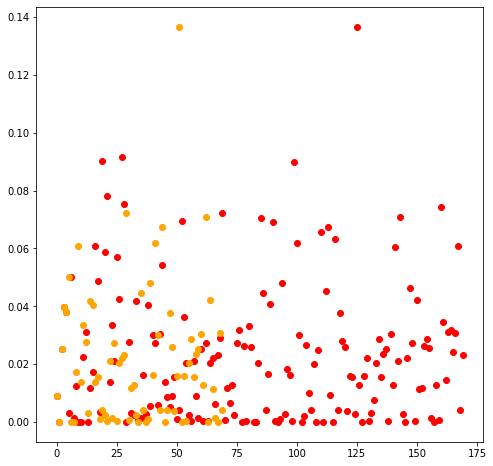

In [247]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)

corrects_unzipped = list(zip(*correct_zipped_stdevs))
corrects_unzipped_thresholded = list(zip(*correct_zipped_stdevs_thresholded))

ax.scatter(list(range(len(corrects_unzipped[0]))), corrects_unzipped[0], color='red')
ax.scatter(list(range(len(corrects_unzipped_thresholded[0]))), corrects_unzipped_thresholded[0], color='orange')

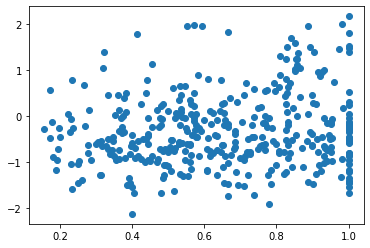

In [390]:
plt.scatter(rouge_scores, topk_passage_means)

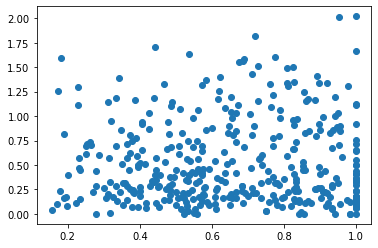

In [391]:
plt.scatter(rouge_scores, topk_passage_stdevs)

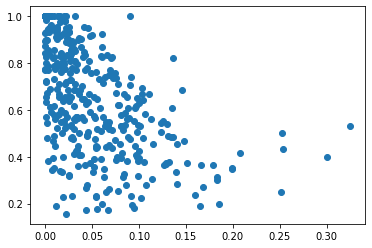

In [192]:
plt.scatter(log_probs, rouge_scores)

In [193]:
len(rouge_scores)

386

In [194]:
len(topk_passage_means)

386

Text(0.5, 1.0, 'max passage score vs rouge similarity')

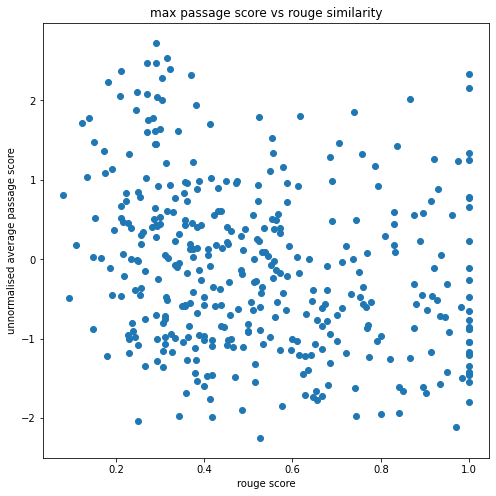

In [173]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(rouge_scores, max_savgols)
ax.set_xlabel("rouge score")
ax.set_ylabel("unnormalised average passage score")
ax.set_title("max passage score vs rouge similarity")

Text(0.5, 1.0, 'log prob score vs rouge similarity')

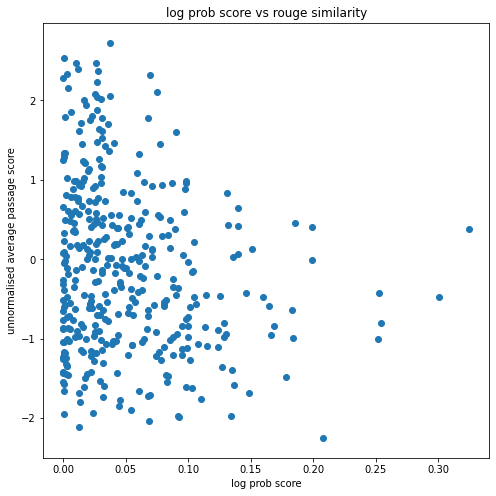

In [172]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(log_probs, max_savgols)
ax.set_xlabel("log prob score")
ax.set_ylabel("unnormalised average passage score")
ax.set_title("log prob score vs rouge similarity")

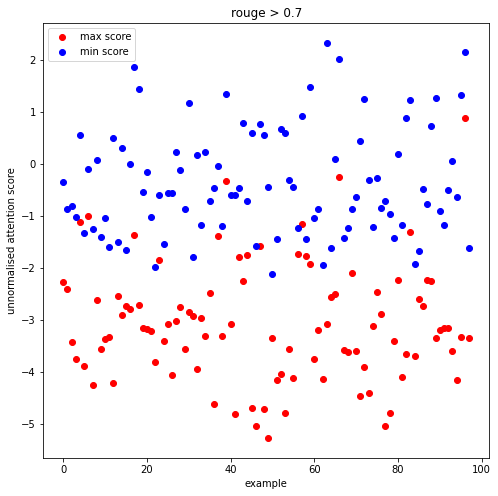

In [55]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_high_similarity))), min_savgols_high_similarity, color = 'red', label = 'max score')
ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'blue', label = 'min score')
ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("rouge > 0.7")
ax.legend()

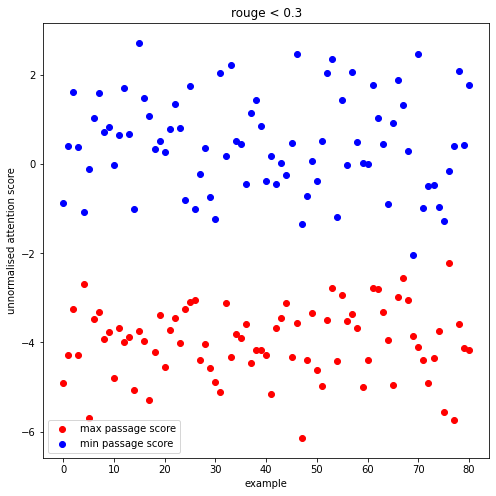

In [91]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_low_similarity))), min_savgols_low_similarity, color = 'red', label = 'max passage score')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'blue', label = 'min passage score')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("rouge < 0.3")

ax.legend()

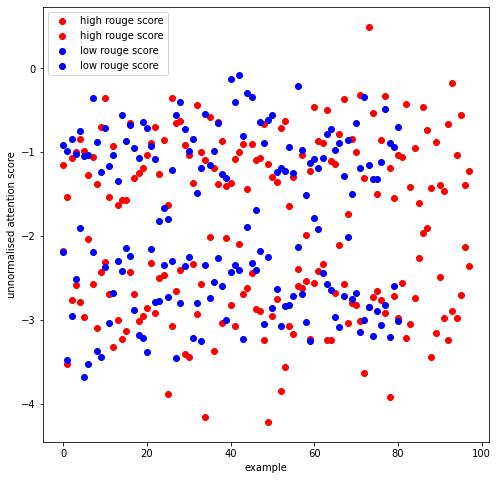

In [253]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(min_savgols_high_similarity))), min_savgols_high_similarity, color = 'red', label = 'high rouge score')
ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'red', label = 'high rouge score')

ax.scatter(list(range(len(min_savgols_low_similarity))), min_savgols_low_similarity, color = 'blue', label = 'low rouge score')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'blue', label = 'low rouge score')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")

ax.legend()

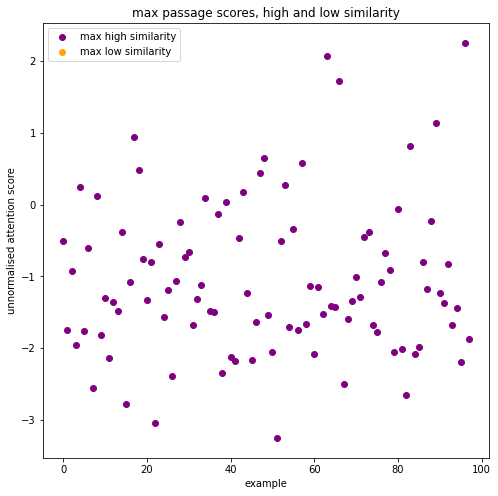

In [29]:
fig = plt.figure(figsize=(8, 8), facecolor="white")
ax = fig.add_subplot(111)

ax.scatter(list(range(len(max_savgols_high_similarity))), max_savgols_high_similarity, color = 'purple', label = 'max high similarity')
ax.scatter(list(range(len(max_savgols_low_similarity))), max_savgols_low_similarity, color = 'orange', label = 'max low similarity')

ax.set_xlabel("example")
ax.set_ylabel("unnormalised attention score")
ax.set_title("max passage scores, high and low similarity")
ax.legend()


In [333]:
for i, batch in enumerate(dataloader_dev):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i in example_indices:
        
        print(i)
        with torch.no_grad():
            model_forward = model.forward(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                decoder_input_ids=labels.cuda(),
                output_attentions=True,
                output_unnormalized_attentions=True,
            )

        cross_attentions = model_forward.cross_attentions
        stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
        msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

        masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

        avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()
        context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
        all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])



        start_pattern = ['▁title', ':', '▁context', ':']
        end_pattern = ['</s>']

        start_index_pattern = subfinder(all_input_tokens, start_pattern)
        end_index_pattern = subfinder(all_input_tokens, end_pattern)

        start_indices = [el[0] for el in start_index_pattern]
        end_indices = [el[0] for el in end_index_pattern]

        relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]
    
        print(relevant_ranges)
        for relevant_range in relevant_ranges:
            spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
            
        
            maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
            minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()

            m = maxpool
            savgol = scipy.signal.savgol_filter(m, 10, 3)

            print(np.mean(savgol))
        
        

2
[(30, 79), (110, 142), (190, 217), (270, 297), (350, 382)]
-2.0721357
-2.1593652
-1.7499658
-2.38584
-2.1786802
19
[(24, 49), (76, 97), (128, 151), (180, 204), (232, 259)]
-2.8978577
-2.9890633
-3.7407975
-1.7660357
-2.795567
20
[(47, 108), (156, 217), (265, 326), (374, 435), (483, 544)]
-0.7697247
-0.61158335
-0.61158335
-1.0574509
-1.0574509
32
[(43, 94), (167, 204), (291, 371), (415, 457), (539, 571)]
-2.859767
-3.9230573
-1.8172185
-2.726822
-3.6581523
35
[(27, 43), (80, 100), (133, 153), (186, 208), (239, 264)]
-2.1395733
-2.1110551
-2.1110551
-1.3048973
-2.1423478
48
[(37, 67), (105, 127), (173, 195), (241, 259), (309, 336)]
-2.1023934
-2.1352043
-2.1352043
-2.4023757
-1.4782554
86
[(32, 56), (110, 144), (188, 215), (266, 311), (344, 389)]
-1.5720788
-2.3206801
-1.6589932
-3.0161061
-3.0161061
102
[(57, 114), (203, 291), (349, 382), (495, 549), (641, 697)]
-0.23701674
-2.0918555
-1.603944
-2.70861
-2.9749825
109
[(25, 63), (102, 147), (179, 225), (256, 302), (333, 384)]
-3.2189

### Visualise question-stripped passages

In [152]:
with torch.no_grad():
    model_forward = model.forward(
    input_ids=context_ids.cuda(),
    attention_mask=context_mask.cuda(),
    decoder_input_ids=generated_output.cuda(),
    # decoder_input_ids=labels.cuda(),
    output_attentions=True,
    output_unnormalized_attentions=True,
    )

cross_attentions = model_forward.cross_attentions
stacked_forward_attentions = torch.cat(cross_attentions, dim=0)
msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()

masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, -10000.0)

avg_attn_matrix = torch.mean(masked_stacked_forward_attentions, dim=(0, 1)).cpu()

In [153]:
def subfinder(mylist, pattern):
    matches = []
    for i in range(len(mylist)):
        if mylist[i] == pattern[0] and mylist[i:i+len(pattern)] == pattern:
            matches.append((i + len(pattern), pattern))
    return matches

In [154]:
avg_attn_matrix.shape

torch.Size([54, 2112])

In [155]:
passage_len = context_mask.shape[2]

In [156]:
context_ids_reshaped = torch.reshape(context_ids, (1, context_ids.shape[1]*context_ids.shape[2]))
context_ids_reshaped.shape

torch.Size([1, 2112])

In [157]:
all_input_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])

In [158]:
start_pattern = ['▁title', ':', '▁context', ':']
end_pattern = ['</s>']

start_index_pattern = subfinder(all_input_tokens, start_pattern)
end_index_pattern = subfinder(all_input_tokens, end_pattern)

start_indices = [el[0] for el in start_index_pattern]
end_indices = [el[0] for el in end_index_pattern]

# remove end of sentence token
relevant_ranges = [(start_index, end_index - 1) for start_index, end_index in zip(start_indices, end_indices)]

relevant_ranges

[(33, 48),
 (209, 226),
 (385, 402),
 (561, 574),
 (737, 753),
 (913, 936),
 (1089, 1108),
 (1265, 1284),
 (1441, 1460),
 (1617, 1635),
 (1793, 1935),
 (1969, 2111)]

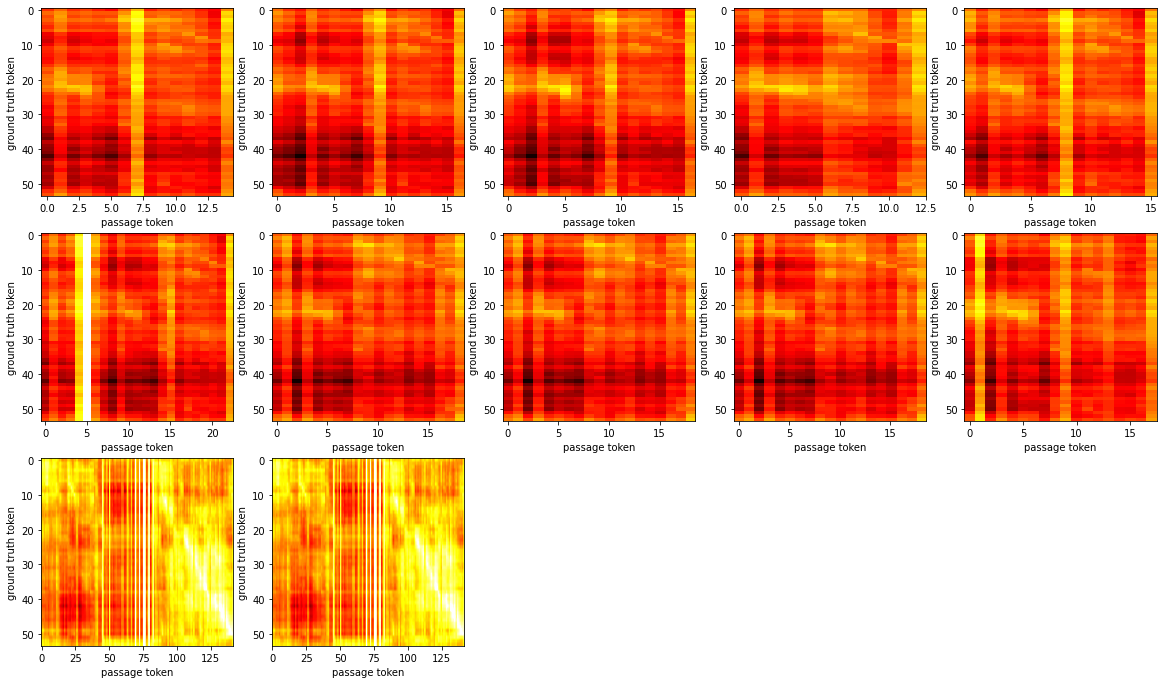

In [159]:
fig = plt.figure(figsize=(20, 20), facecolor="white")

for i in range(len(relevant_ranges)):
    plt.subplot(5, 5, i + 1)
    relevant_range = relevant_ranges[i]
    spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
    spliced_attn_matrix_np = spliced_attn_matrix.numpy()
    
    np.save(f'example_matrix_{i}.npy', spliced_attn_matrix_np)
    im = plt.imshow(spliced_attn_matrix, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=2)
    
    plt.xlabel('passage token')
    plt.ylabel('ground truth token')

-1.7025461
-1.7236701
-1.8351501
-2.2071123
-1.4666404
-1.6993278
-1.6993278
-1.6993278
-1.6993278
-1.6993278
-0.18874326
-0.18874326


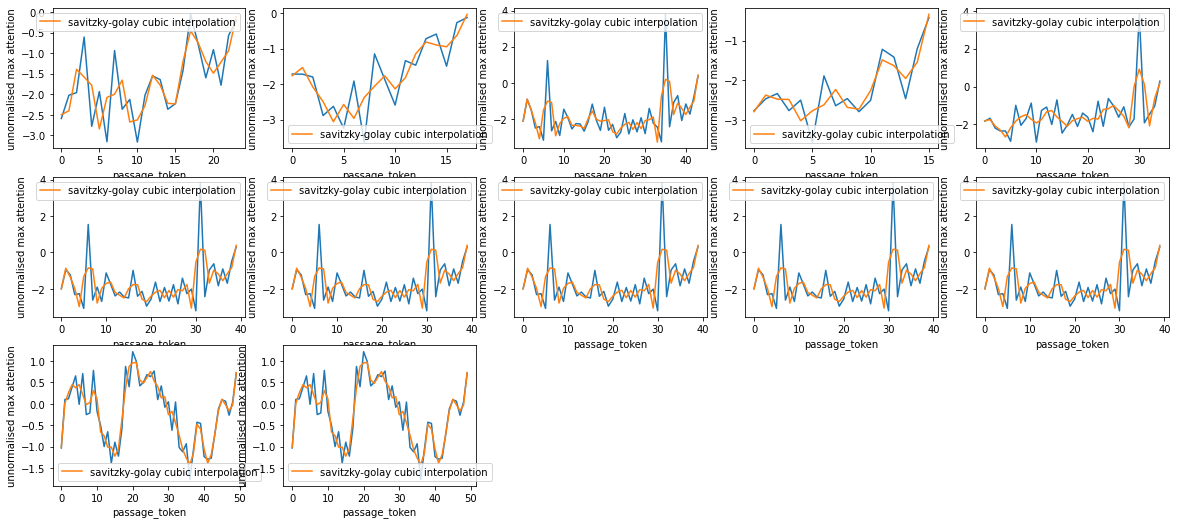

In [116]:
fig = plt.figure(figsize=(20, 15), facecolor="white")
savgols = []
for i in range(len(relevant_ranges)):
    plt.subplot(5, 5, i + 1)
    relevant_range = relevant_ranges[i]
    spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
    
    maxpool = torch.max(spliced_attn_matrix, axis=0).values.cpu().numpy()
    minpool = torch.min(spliced_attn_matrix, axis=0).values.cpu().numpy()
    
    # m = maxpool - minpool
    m = maxpool
    # print(np.mean(m))
    savgol = scipy.signal.savgol_filter(m, 5, 3)
    print(np.mean(savgol))
    savgols.append(savgol)
    
    plt.plot(m)
    plt.plot(savgol, label='savitzky-golay cubic interpolation')
    plt.legend()
    plt.xlabel('passage_token')
    plt.ylabel('unnormalised max attention')
    

In [ ]:
all_decoded_passage_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0])
decoded_labels = tokenizer.convert_ids_to_tokens(generated_output[0])

i = 0

relevant_range = relevant_ranges[i]
spliced_attn_matrix = avg_attn_matrix[:, relevant_range[0]:relevant_range[1]]
relevant_passage_tokens = all_decoded_passage_tokens[relevant_range[0]:relevant_range[1]]

# spliced_attn_matrix = np.load('example_matrix_1.npy')

fig = plt.figure(figsize=(20, 20), facecolor="white")
ax = fig.add_subplot(111)

im = ax.imshow(spliced_attn_matrix, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=2)

xticks = ax.set_xticks(range(len(relevant_passage_tokens)), rotation=90)
xlabels = ax.set_xticklabels(relevant_passage_tokens, rotation=90)

yticks = ax.set_yticks(range(len(decoded_labels)), rotation=90)
ylabels = ax.set_yticklabels(decoded_labels)


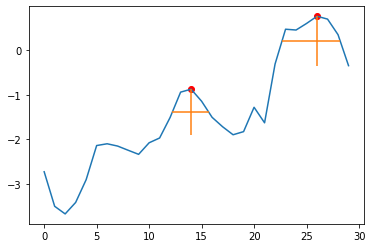

In [306]:
i = 10

peaks, properties = find_peaks(savgols[i], width=3)
plt.plot(savgols[i])
plt.scatter(list(peaks), [savgols[i][idx] for idx in list(peaks)], color='red')

plt.vlines(x=peaks, ymin=savgols[i][peaks] - properties["prominences"],
           ymax = savgols[i][peaks], color = "C1")

plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

### Visualise layer-head averaged cross-attention matrix

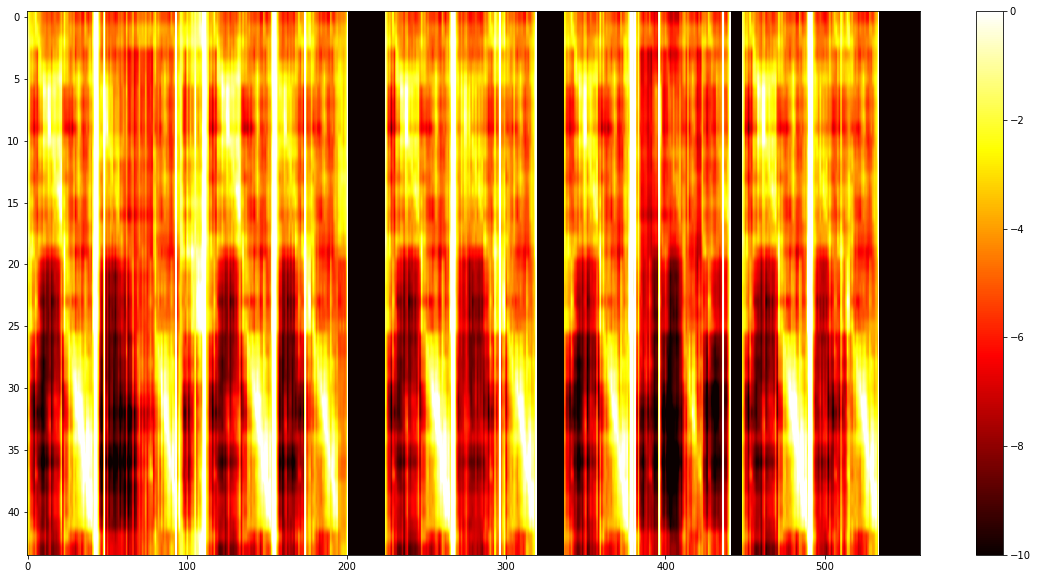

In [33]:
# ALL RELEVANT PASSAGES
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

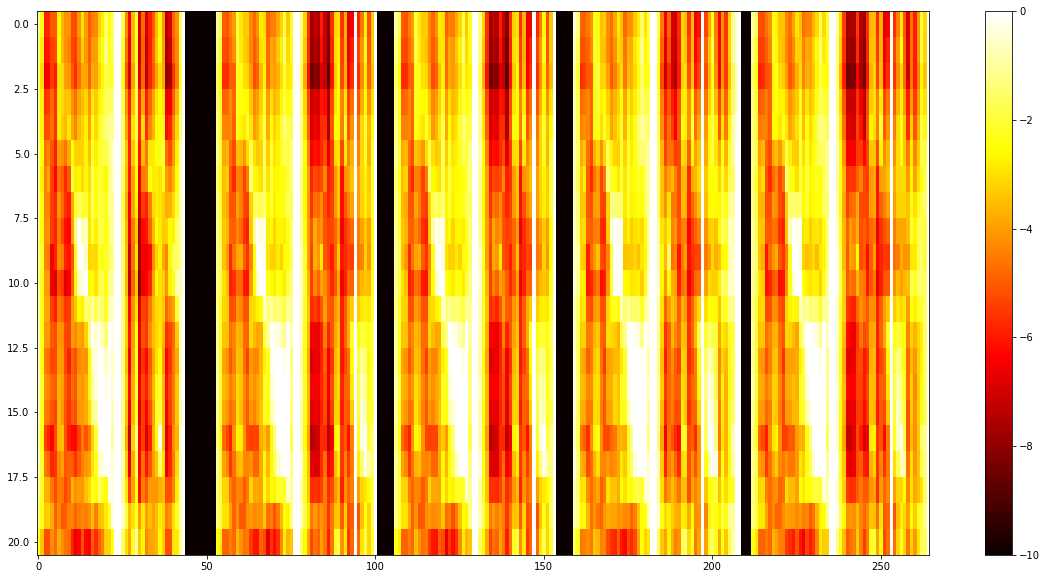

In [139]:
# ONLY FIRST PASSAGE RELEVANT 
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

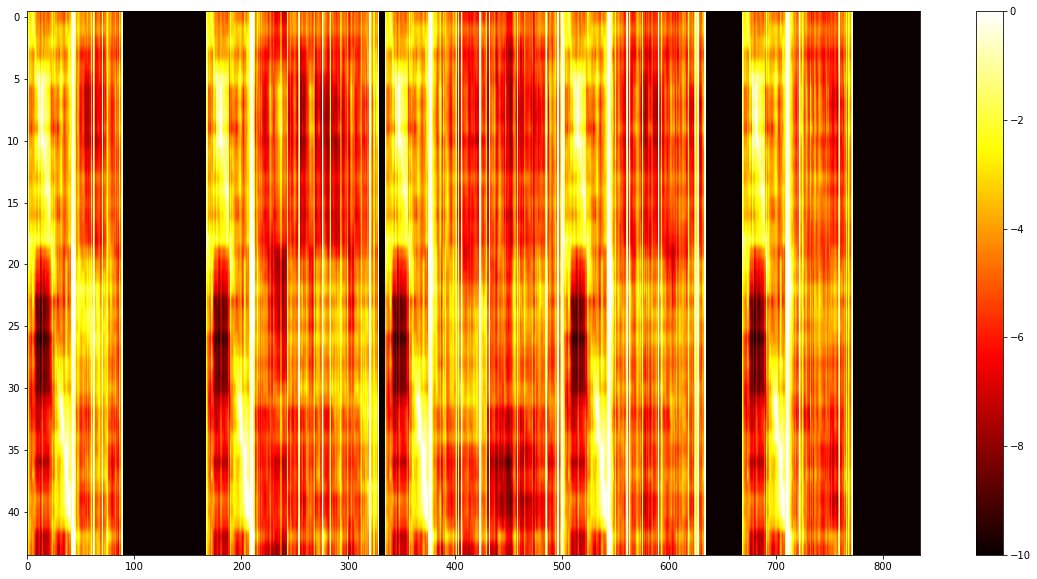

In [31]:
# ALL PASSAGES IRRELEVANT
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
im = ax.imshow(avg_attn_matrix.cpu().numpy(), cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)
fig.colorbar(im)

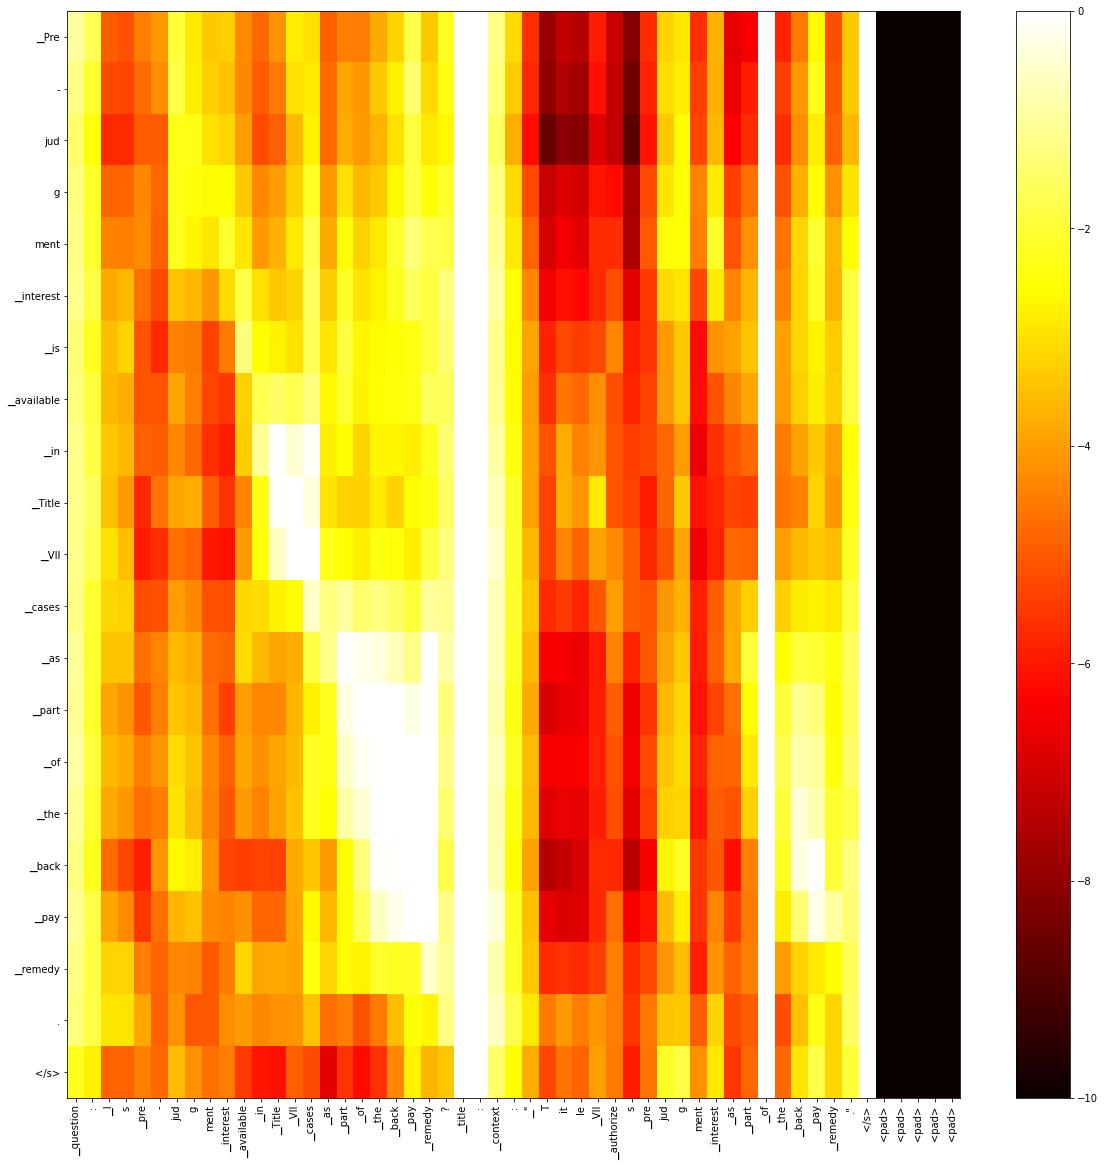

In [141]:
# FIRST PASSAGE RELEVANT
passage_len = context_mask.shape[2]
start = 1
end = 2


decoded_passage_tokens = tokenizer.convert_ids_to_tokens(context_ids_reshaped[0][(start*passage_len):(end*passage_len)])
decoded_labels = tokenizer.convert_ids_to_tokens(labels[0])

fig = plt.figure(figsize=(20, 20), facecolor="white")
ax = fig.add_subplot(111)
passage_1_sector = avg_attn_matrix[:, (start*passage_len):(end*passage_len)]
im = ax.imshow(passage_1_sector, cmap=plt.get_cmap('hot'), aspect='auto', vmin=-10, vmax=0)

ax.set_xticks(range(passage_len), rotation=90)
ax.set_xticklabels(decoded_passage_tokens, rotation=90)

ax.set_yticks(range(len(labels[0])), rotation=90)
ax.set_yticklabels(decoded_labels)

fig.colorbar(im)

## Obtaining the generative output score

In [17]:
len(dataloader)

386

### Figure out prevalence of very confident, correct vs incorrect answers

In [11]:
# only one context vector

exact_match_log_probabilities = []
incorrect_log_probabilities = []
exact_match_answers = []

for i, batch in tqdm(enumerate(dataloader)):
    
    (idx, _, _, context_ids, context_mask) = batch
    sequences = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=100,
                return_dict_in_generate=True,
                output_scores=True
            ).sequences

    
    for k, o in enumerate(sequences):
        ans = tokenizer.decode(o, skip_special_tokens=True)
        gold = eval_dataset.get_example(idx[k])['answers']
        score = ems(ans, gold)
        #print(score)
        # total += 1
        # exactmatch.append(score)
#         print("model generated output:")
#         print(ans)

#         print("")
#         print("ground truth:")
#         print(gold) 

    # print("extracting negative log probability ...")
    log_probability = model.obtain_log_generated_probability(
        input_ids=context_ids.cuda(),
        attention_mask=context_mask.cuda(),
        max_length=100

    )
    
    if score == True:
        exact_match_log_probabilities.append(log_probability.cpu().numpy())
        exact_match_answers.append(ans)
#         if len(exact_match_log_probabilities) >= 5:
#             print("exceeded five exact matches")
        
#         if len(exact_match_log_probabilities) >= 10:
#             print("exceeded ten exact matches")
    
    else:
        incorrect_log_probabilities.append(log_probability.cpu().numpy())
        
    if i >= 0:
        break


0it [00:00, ?it/s]/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:656: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
0it [00:05, ?it/s]


In [428]:
# load from local
exact_match_log_probabilities = np.load("../numpy_drops/exact_matches_dev.npy")
incorrect_log_probabilities = np.load("../numpy_drops/incorrects_dev.npy")
rouge_match_log_probabilities = np.load("../numpy_drops/rouge_matches_dev.npy")

In [429]:
with open("../numpy_drops/rouge_similarity_answers_dev_sampling", "rb") as f:
    rouge_matches = pickle.load(f)

len(rouge_matches)

169

In [430]:
len([el for el in rouge_matches if el[2] == 1.0])

41

In [431]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

In [432]:
print("rouge match distribution")
print(len(rouge_match_log_probabilities))
print(np.mean(rouge_match_log_probabilities))
print(np.std(rouge_match_log_probabilities))

rouge match distribution
170
0.023282405
0.023933623


In [433]:
print("exact match distribution")
print(len(exact_match_log_probabilities))
print(np.mean(exact_match_log_probabilities))
print(np.std(exact_match_log_probabilities))

exact match distribution
38
0.0065935003
0.015214035


In [434]:
print("incorrect match distribution")
print(len(incorrect_log_probabilities))
print(np.mean(incorrect_log_probabilities))
print(np.std(incorrect_log_probabilities))

incorrect match distribution
216
0.071162306
0.05587658


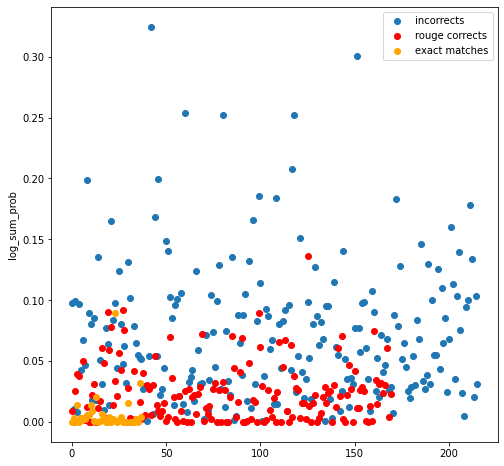

In [435]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(incorrect_log_probabilities))), incorrect_log_probabilities, label="incorrects")
ax.scatter(list(range(len(rouge_match_log_probabilities))), rouge_match_log_probabilities, color="red", label="rouge corrects")
ax.scatter(list(range(len(exact_match_log_probabilities))), exact_match_log_probabilities, color="orange", label="exact matches")
ax.set_ylabel("log_sum_prob")
ax.legend()

In [436]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

inexact_matches = [el for el in zipped_rouge if el[0][2] != 1.0]

inexact_match_log_probabilities = list(zip(*inexact_matches))[1]


In [437]:
# rouge-l correctness
corrects_rouge = list(rouge_match_log_probabilities)
incorrects_rouge = list(incorrect_log_probabilities)

y_scores_rouge = corrects_rouge + incorrects_rouge
y_true_rouge = list(np.zeros(len(corrects_rouge)).astype(int)) + list(np.ones(len(incorrects_rouge)).astype(int))

# exact match correctness
corrects_exact = list(exact_match_log_probabilities)
incorrects_exact = list(incorrect_log_probabilities) + list(inexact_match_log_probabilities)

y_scores_exact = corrects_exact + incorrects_exact
y_true_exact = list(np.zeros(len(corrects_exact)).astype(int)) + list(np.ones(len(incorrects_exact)).astype(int))

In [438]:
len(corrects_rouge) + len(incorrects_rouge)

386

In [440]:
threshold = 0.003

label_scores = list(zip(y_true_rouge, y_scores_rouge))

predicted_positive = [el for el in label_scores if el[1] <= threshold]
predicted_negative = [el for el in label_scores if el[1] > threshold]

true_positive = len([el for el in predicted_positive if el[0] == 0])
false_positive = len([el for el in predicted_positive if el[0] == 1])

true_negative = len([el for el in predicted_negative if el[0] == 1])
false_negative = len([el for el in predicted_negative if el[0] == 0])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)


print(f"precision: {precision}")
print(f"recall: {recall}")

precision: 0.875
recall: 0.24705882352941178


In [441]:
total_examples = len(rouge_match_log_probabilities) + len(incorrect_log_probabilities)

print(f"total examples: {total_examples}")

allowed_through = true_positive + false_positive

fraction_allowed_through = allowed_through / total_examples

print(f"fraction allowed through: {fraction_allowed_through}")

total examples: 386
fraction allowed through: 0.12435233160621761


### PR curve

In [60]:
def obtain_p_and_r(y_true, y_pred, thresholds):
    
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        label_scores = list(zip(y_true, y_pred))

        predicted_positive = [el for el in label_scores if el[1] <= threshold]
        predicted_negative = [el for el in label_scores if el[1] > threshold]

        true_positive = len([el for el in predicted_positive if el[0] == 0])
        false_positive = len([el for el in predicted_positive if el[0] == 1])

        true_negative = len([el for el in predicted_negative if el[0] == 1])
        false_negative = len([el for el in predicted_negative if el[0] == 0])

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls
        

In [61]:
thresholds = np.linspace(0, 1, 101)

precisions_rouge, recalls_rouge = obtain_p_and_r(y_true_rouge, y_scores_rouge, thresholds)
precisions_exact, recalls_exact = obtain_p_and_r(y_true_exact, y_scores_exact, thresholds)

precisions_rouge = [1.0] + precisions_rouge + [0.0]
recalls_rouge = [0.0] + recalls_rouge + [1.0]

precisions_exact = [1.0] + precisions_exact + [0.0]
recalls_exact = [0.0] + recalls_exact + [1.0]

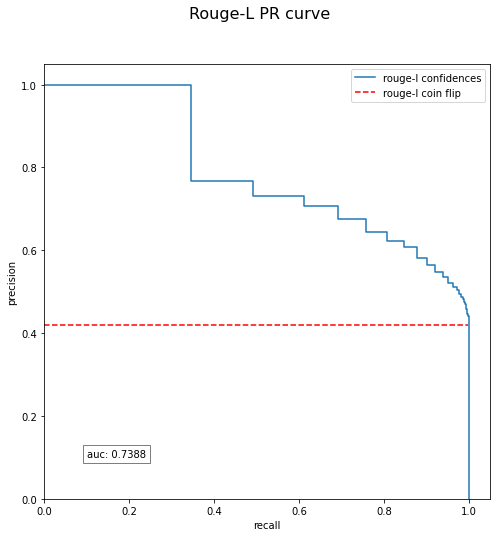

In [113]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Rouge-L PR curve", fontsize=16)
ax = fig.add_subplot(111)

ax.step(recalls_rouge, precisions_rouge, label="rouge-l confidences", where='post')
plt.axhline(1 - sum(y_true_rouge) / len(y_true_rouge), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="rouge-l coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.1, 0.1, "auc: {:.4f}".format(auc(recalls_rouge, precisions_rouge)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

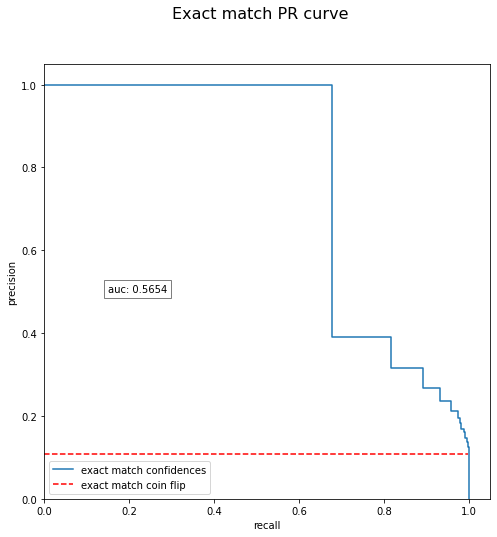

In [83]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Exact match PR curve", fontsize=16)
ax = fig.add_subplot(111)

# ax.plot(recalls_exact, precisions_exact)
ax.step(recalls_exact, precisions_exact, label="exact match confidences", where='post')
plt.axhline(1 - sum(y_true_exact) / len(y_true_exact), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="exact match coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.15, 0.5, "auc: {:.4f}".format(auc(recalls_exact, precisions_exact)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

### inspect some generated sentences

In [46]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            if j >= 0:
                break
    
    if i > 0:
        break


====
0
question: When does the statute of limitations period begin for a plaintiff who experiences a continuing practice and policy of discrimination? title: context: Under this approach, if a plaintiff experienced a continuous policy or practice of discrimination, the continuing-violation doctrine delays the commencement of the statute-of-limitations period until the occurrence of the last discriminatory act in furtherance of that discriminatory practice.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [242]:
[el for el in rouge_matches if el[2] == 1.0][:20]

[('An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  'An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  1.0,
  2),
 ('A defendant who obtains a dismissal can be considered the prevailing party.\xa0',
  'A defendant who obtains a dismissal can be considered the prevailing party.',
  1.0,
  19),
 ('Pre-judgment interest is available in Title VII cases as part of the back pay remedy.',
  'Pre-judgment interest is available in Title VII cases as part of the back pay remedy.',
  1.0,
  35),
 ('When taking an oral deposition, a party can choose whether to adjourn the examination before moving for an order, or move for such an order after the completion of the deposition.',
  'When taking an oral deposition, a party can choose whether to adjourn the examination before moving for an order, or move for such an order after the completion of the deposit

#### 

### Obtain example generated vs ground truth outputs

In [47]:
# only one context vector
for i, batch in enumerate(dataloader):
    
    if i == 7:
        print(f"training example: {i}")
        (idx, _, _, context_ids, context_mask) = batch
        sequences = model.generate(
                    input_ids=context_ids.cuda(),
                    attention_mask=context_mask.cuda(),
                    max_length=10,
                    return_dict_in_generate=True,
                    output_scores=True
                ).sequences

        print(sequences)
        for k, o in enumerate(sequences):
            ans = tokenizer.decode(o, skip_special_tokens=True)
            gold = eval_dataset.get_example(idx[k])['answers']
            score = ems(ans, gold)
            #print(score)
            # total += 1
            # exactmatch.append(score)
            print("model generated output:")
            print(ans)

            print("")
            print("ground truth:")
            print(gold) 
        
        print("extracting negative log probability ...")
        log_probability = model.obtain_log_generated_probability(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            max_length=10
            
        )
        
        print(score)
        
        print(log_probability)
        
        break


training example: 7
tensor([[   0, 4407,    1]], device='cuda:0')
model generated output:
2002

ground truth:
['2002']
extracting negative log probability ...
True
tensor(0.6189, device='cuda:0')


In [92]:
softmax = torch.nn.Softmax(dim=1)
total_log_prob = 0
for i in range(len(outputs.scores)):
    print(torch.log(torch.max(softmax(outputs.scores[i]))))
    total_log_prob -= torch.log(torch.max(softmax(outputs.scores[i])))

total_log_prob

tensor(-0.9990, device='cuda:0')
tensor(-0.0031, device='cuda:0')
tensor(-2.1935e-05, device='cuda:0')
tensor(-7.8800e-05, device='cuda:0')
tensor(-0.0035, device='cuda:0')


tensor(1.0057, device='cuda:0')

## Comparing tokenizers

In [31]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')

In [32]:
input_sequence = "Welcome to the HuggingFace Library"

In [35]:
bert_tokenized = bert_tokenizer(input_sequence, return_tensors='pt')
t5_tokenized = t5_tokenizer(input_sequence, return_tensors='pt')

print(bert_tokenized.input_ids)
print("===")
print(t5_tokenized.input_ids)

tensor([[  101,  6160,  2000,  1996, 17662, 12172,  3075,   102]])
===
tensor([[ 5242,    12,     8, 11560,  3896,   371,  3302,  5355,     1]])


In [40]:
print(bert_tokenizer.decode(bert_tokenized.input_ids[0]))
print("===")
print(t5_tokenizer.decode(t5_tokenized.input_ids[0]))

[CLS] welcome to the huggingface library [SEP]
===
Welcome to the HuggingFace Library</s>


In [46]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenized.input_ids[0])

['[CLS]', 'welcome', 'to', 'the', 'hugging', '##face', 'library', '[SEP]']

In [45]:
t5_tokenizer.convert_ids_to_tokens(t5_tokenized.input_ids[0])

['▁Welcome', '▁to', '▁the', '▁Hug', 'ging', 'F', 'ace', '▁Library', '</s>']

In [52]:
z = torch.randn((2, 4))

In [54]:
msk = torch.tensor([[True, False, True], [False, True, False]])
msk2 = torch.tensor([[True, False, True, True]])

In [43]:
z

tensor([[-1.1771,  0.8998, -0.6725],
        [-1.0138,  1.7796, -0.3884]])

In [55]:
z.masked_fill(msk2 == 0, 0.0)

tensor([[ 1.3247,  0.0000, -0.0618, -0.7110],
        [-0.9271,  0.0000,  0.5299,  0.6540]])

In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')
import torch

In [2]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [3]:
input_ids = tokenizer.encode("summarise: I am originally from siberia, where the sky is green", return_tensors="pt")  # Batch size 1


In [30]:
outputs = model.generate(input_ids, 
                          return_dict_in_generate=True, 
                          output_scores=True, 
                          num_beams=1,
                          do_sample=True,
                          top_k=3,
                          temperature=1.0
                          )


outputs.sequences

tensor([[    0,  2432,  2160,     7,    15,    10,  1674, 26212,   403,   108,
          8781,  1779, 22655,     6,  2275,    67, 23537,     7, 22387,     3]])

In [31]:
scores = outputs.scores

In [36]:
torch.topk(scores[2][0], k=3).indices

tensor([   7, 2248, 5202])

In [21]:
len(scores)

12

In [22]:
softmax = torch.nn.Softmax(dim=1)
softmax(scores[0])

tensor([[8.6265e-07, 1.0719e-02, 7.2606e-06,  ..., 6.3396e-19, 6.0439e-19,
         6.1077e-19]])

In [145]:
scores[4][0]

tensor([-25.0806, -11.4120, -15.4883,  ..., -47.4939, -47.5193, -47.6304])

In [147]:
scores[4][0][sequence[0][5]]

tensor(-3.8385)

In [155]:
torch.argmax(scores[11])

tensor(1)

In [26]:
ans = []
for i in range(len(scores)):
    sfx = softmax(scores[i])
    ans.append(sfx[0][sequence[0][i + 1]])

In [384]:
y_true = np.array([0, 0, 1, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.9])

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)


In [391]:
threshold = 0.35

label_scores = list(zip(y_true, y_scores))

predicted_positive = [el for el in label_scores if el[1] >= threshold]
predicted_negative = [el for el in label_scores if el[1] < threshold]

true_positive = len([el for el in predicted_positive if el[0] == 1])
false_positive = len([el for el in predicted_positive if el[0] == 0])

true_negative = len([el for el in predicted_negative if el[0] == 0])
false_negative = len([el for el in predicted_negative if el[0] == 1])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(precision)
print(recall)


0.75
1.0


In [381]:
thresholds

array([0.1 , 0.35, 0.4 , 0.8 , 0.9 ])

In [386]:
precisions

array([0.6       , 0.75      , 0.66666667, 1.        , 1.        ,
       1.        ])

In [387]:
recalls

array([1.        , 1.        , 0.66666667, 0.66666667, 0.33333333,
       0.        ])